<a href="https://colab.research.google.com/github/julwdo/thesis/blob/main/01_codes/01_gcolab/03_thesis_extract_additional_features_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def plot_numeric(df, feature, label_col="label"):
    weights = df.groupby(label_col)[feature].transform(lambda x: 1 / len(x))

    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df,
        x=feature,
        hue=label_col,
        bins=50,
        weights=weights,
        alpha=0.6
    )
    plt.title(f"{feature} by {label_col} (normalized)")
    plt.ylabel("Relative frequency")
    plt.show()


def plot_boolean(df, feature, label_col="label"):
    prop_df = (
        df
        .groupby(label_col)[feature]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=prop_df,
        x=feature,
        y="proportion",
        hue=label_col
    )
    plt.title(f"{feature} by {label_col}")
    plt.ylabel("Proportion")
    plt.show()

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.linear_model import LinearRegression

USER_PATTERN = r"(?<!\w)@([A-Za-z0-9_]{1,15})\b"

def cosine_sim(a, b):
    if not isinstance(a, np.ndarray) or not isinstance(b, np.ndarray):
        return np.nan
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0, 0]

def enrich_tweet_features(df):
    df = df.copy()

    # --- Basic type normalization ---
    df["created_at"] = pd.to_datetime(
        df["created_at"],
        errors="coerce",
        utc=True
    )

    df["in_reply_to_user_id"] = np.where(
        df["in_reply_to_user_id"].isna(),
        np.nan,
        "u" + df["in_reply_to_user_id"].astype("Int64").astype(str)
    )

    # --- Retweet target extraction ---
    df["retweeted_username"] = (
        df.loc[df["is_retweet"], "text"]
        .str.extract(USER_PATTERN, expand=False)
    )

    # --- Temporal features ---
    df["tweet_hour"] = df["created_at"].dt.hour
    df["tweet_day_of_week"] = df["created_at"].dt.dayofweek
    df["tweet_is_weekend"] = df["tweet_day_of_week"].isin([5, 6]).astype(int)

    # Cyclical encoding
    df["tweet_hour_sin"] = np.sin(2 * np.pi * df["tweet_hour"] / 24)
    df["tweet_hour_cos"] = np.cos(2 * np.pi * df["tweet_hour"] / 24)

    df["tweet_dow_sin"] = np.sin(2 * np.pi * df["tweet_day_of_week"] / 7)
    df["tweet_dow_cos"] = np.cos(2 * np.pi * df["tweet_day_of_week"] / 7)

    # --- Sort for sequential features ---
    df = df.sort_values(["author_id", "created_at"])

    # --- Inter-tweet timing ---
    df["tweet_time_delta_sec"] = (
        df.groupby("author_id")["created_at"]
        .diff()
        .dt.total_seconds()
    )

    # --- Previous embedding ---
    df["prev_embedding"] = (
        df.groupby("author_id")["embedding"]
        .shift(1)
    )

    df["tweet_cosine_sim_prev"] = df.apply(
        lambda row: cosine_sim(row["embedding"], row["prev_embedding"]),
        axis=1
    )

    # --- User centroid ---
    user_centroids = (
        df.groupby("author_id")["embedding"]
        .apply(lambda x: np.mean(np.vstack(x), axis=0))
    )

    df = df.join(
        user_centroids.rename("user_embedding_centroid"),
        on="author_id"
    )

    # --- Similarity to centroid ---
    df["tweet_cosine_sim_centroid"] = df.apply(
        lambda row: cosine_sim(
            row["embedding"], row["user_embedding_centroid"]
        ),
        axis=1
    )

    return df

def build_user_features_from_tweets(tweet_features, user_features):

  user_features["created_at"] = pd.to_datetime(
      user_features["created_at"],
      errors="coerce",
      utc=True
      )

  # ---------- helpers ----------
  def entropy(x):
    x = x.dropna()
    if len(x) == 0:
        return 0.0

    p = x.value_counts(normalize=True)
    return -(p * np.log(p)).sum()

  def pct_within_threshold(x, threshold):
    x = x.dropna()
    if len(x) == 0:
        return 0.0
    return (x <= threshold).mean()

  def sentiment_slope(group):
    if len(group) < 2:
        return 0.0

    t = (
        group["created_at"] - group["created_at"].min()
    ).dt.total_seconds().values.reshape(-1, 1)

    y = group["sentiment"].values

    model = LinearRegression()
    model.fit(t, y)
    return model.coef_[0]

  # ---------- ordering ----------
  tf = tweet_features.sort_values(["author_id", "created_at"])

  # ---------- conversation / replies ----------
  replies = tf[tf["is_reply"] == 1]

  user_unique_replied = (
      replies
      .groupby("author_id")["in_reply_to_user_id"]
      .nunique()
      .rename("n_unique_users_replied_to")
  )

  user_reply_entropy = (
      replies
      .groupby("author_id")["in_reply_to_user_id"]
      .apply(entropy)
      .rename("reply_user_entropy")
  )

  # ---------- generic aggregation of tweet features ----------
  feature_cols = [
      'is_reply', 'is_sensitive', 'like_count', 'quote_count',
      'reply_count', 'retweet_count', 'is_present', 'length',
      'num_words', 'num_sentences', 'avg_sentence_length',
      'avg_word_length', 'std_word_length', 'unique_word_ratio',
      'guiraud_index', 'repetition_ratio', 'hapax_ratio',
      'digit_ratio', 'uppercase_ratio', 'lowercase_ratio',
      'special_char_ratio', 'punctuation_ratio',
      'whitespace_ratio', 'emoji_count', 'emoji_ratio',
      'mention_count', 'contains_mention', 'url_count',
      'contains_url', 'hashtag_count', 'cashtag_count',
      'email_count', 'contains_bot_word_or_hashtag',
      'contains_ai_hashtag', 'sentiment', 'sentiment_abs',
      'sentiment_neutrality', 'sentiment_subjectivity',
      'flesch_reading_ease', 'flesch_kincaid_grade',
      'avg_syllables_per_word', 'polysyllabic_word_ratio',
      'char_entropy', 'word_entropy', 'avg_word_repetition',
      'compression_ratio', 'starts_with_emoji', 'ends_with_emoji',
      'starts_with_url', 'ends_with_url',
      'contains_pipe_or_bullet', 'contains_call_to_action',
      'contains_ai_phrase', 'function_word_ratio', 'noun_ratio',
      'verb_ratio', 'pronoun_ratio', 'adjective_ratio',
      'contains_repeated_chars', 'is_retweet', 'is_quote'
      ]

  bool_cols = tf[feature_cols].select_dtypes(include=[bool]).columns
  numeric_cols = tf[feature_cols].select_dtypes(include=[np.number]).columns

  agg_dict = {c: "mean" for c in bool_cols}
  agg_dict.update({c: ["mean", "std"] for c in numeric_cols})

  generic_aggregation = (
      tf.groupby("author_id")
      .agg(agg_dict)
      )

  generic_aggregation.columns = [
      f"{col}_{stat}" for col, stat in generic_aggregation.columns
      ]

  # ---------- temporal behavior ----------
  user_temporal_features = (
      tf
      .groupby("author_id")
      .agg(
          weekend_post_ratio=("tweet_is_weekend", "mean"),
          mean_posting_hour=("tweet_hour", "mean"),
          posting_hour_std=("tweet_hour", "std"),
          posting_hour_entropy=("tweet_hour", entropy),
          posting_dow_entropy=("tweet_day_of_week", entropy)
          )
      )

  # ---------- inter-tweet dynamics ----------
  user_delta_stats = (
      tf.groupby("author_id")["tweet_time_delta_sec"]
      .agg(
          delta_mean="mean",
          delta_median="median",
          delta_std="std",
          delta_min="min"
          )
      )

  user_delta_stats["delta_burstiness"] = (
      user_delta_stats["delta_std"] / user_delta_stats["delta_mean"]
      )

  user_fast_posting = (
      tf.groupby("author_id")["tweet_time_delta_sec"]
      .agg(
          pct_within_10s=lambda x: pct_within_threshold(x, 10),
          pct_within_60s=lambda x: pct_within_threshold(x, 60),
          pct_within_5min=lambda x: pct_within_threshold(x, 300)
          )
      )

  user_intertweet_features = (
      pd.concat([user_delta_stats, user_fast_posting], axis=1)
      )

  # ---------- semantic / embedding ----------
  user_semantic_features = (
      tf.groupby("author_id")["tweet_cosine_sim_centroid"]
      .agg(
          sem_centroid_sim_mean="mean",
          sem_centroid_sim_max="max",
          sem_centroid_sim_std="std"
          )
      )

  user_embedding_features = (
      tf.groupby("author_id")["embedding"]
      .apply(lambda x: np.std(np.vstack(x), axis=0).mean())
      .rename("embedding_std_mean")
      .to_frame()
      )

  # ---------- style & sentiment ----------
  user_style_features = (
      pd.concat(
          [
              tf.groupby("author_id")["flesch_reading_ease"]
              .std()
              .rename("readability_std_over_time"),
              tf.groupby("author_id", group_keys=False)
              .apply(sentiment_slope, include_groups=False)
              .rename("sentiment_time_slope")
              ],
          axis=1
          )
      )

  # ---------- attribute × behavior interaction ----------
  user_hashtag_ratio = (
      tf
      .groupby("author_id")["hashtag_count"]
      .mean()
      .rename("avg_hashtag_count")
      )

  user_features["tw_followers_x_hashtag"] = (
      user_features["followers_count"]
      * user_features["id"].map(user_hashtag_ratio)
      )

  user_emoji_ratio = (
      tf
      .groupby("author_id")["emoji_ratio"]
      .mean()
      .rename("avg_emoji_ratio")
      )

  user_features["tw_verified_x_emoji"] = (
      user_features["is_verified"]
      * user_features["id"].map(user_emoji_ratio)
      )

  user_features_from_tweets = (
      pd.concat([
          user_unique_replied,
          user_reply_entropy,
          generic_aggregation,
          user_temporal_features,
          user_intertweet_features,
          user_semantic_features,
          user_embedding_features,
          user_style_features
          ], axis=1)
      .add_prefix("tw_")
      .reset_index()
      )

  user_features = user_features.merge(
    user_features_from_tweets,
    left_on="id",
    right_on="author_id",
    how="left"
    )
  user_features.drop(columns="author_id", inplace=True)

  return user_features

def extract_node_features(G):
  return pd.DataFrame({
      "out_degree": dict(G.out_degree()),
      "in_degree": dict(G.in_degree()),
      "pagerank": nx.pagerank(G),
      "clustering": nx.clustering(G.to_undirected()),
      "n_neighbors": dict(nx.degree(G.to_undirected()))
      })

def extract_node_features_weighted(G):
  return pd.DataFrame({
      "out_degree": dict(G.out_degree(weight="weight")),
      "in_degree": dict(G.in_degree(weight="weight")),
      "pagerank": nx.pagerank(G, weight="weight"),
      "clustering": nx.clustering(G.to_undirected(), weight="weight"),
      "n_neighbors": dict(nx.degree(G.to_undirected()))
      })

In [71]:
def report_split(y, split_name):
  n = len(y)
  pct = n / len(enriched_user_features) * 100
  class_counts = y.value_counts()
  class_pct = y.value_counts(normalize=True) * 100

  print(f"{split_name} set: {n} rows ({pct:.2f}% of dataset)")
  for cls in class_counts.index:
    print(f"  Class {cls}: {class_counts[cls]} rows ({class_pct[cls]:.2f}%)")
  print("-" * 40)

In [43]:
import joblib

path = "/content/drive/MyDrive/twibot-22/processed"

user_features = joblib.load(f"{path}/user_features_3.joblib")
user_features.head(1)

id  name_length  username_length  \
0  u1000115670657318912            4                6   

   username_name_length_ratio  \
0                         1.5   

                                         description  has_name  has_username  \
0  Open source tool for data & models versioning ...      True          True   

   has_url  has_location  has_pinned_tweet  has_bot_word_in_name  \
0    False          True              True                 False   

   ratio_digits_in_name  ratio_digits_in_username  \
0                   0.0                       0.0   

   ratio_special_chars_in_name  ratio_special_chars_in_username  \
0                         0.25                              0.0   

   name_upper_to_lower_ratio  username_upper_to_lower_ratio  name_entropy  \
0                        3.0                            1.0           2.0   

   username_entropy  username_name_levenshtein  is_protected  is_verified  \
0          2.584963                   0.666667         False        False   

                  created_at  account_age_seconds  followers_count  \
0  2018-05-25 20:45:31+00:00            241981329             3488   

   following_count  listed_count  tweet_count  followers_over_following  \
0              325            79          911                 10.732308   

   double_followers_over_following  following_over_followers  \
0                        21.464615                  0.093177   

   following_over_followers_squared  following_over_total_connections  \
0                          0.000027                          0.085235   

   listed_over_followers  tweets_over_followers  listed_over_tweets  \
0               0.022649               0.261181            0.086718   

   follower_rate  following_rate   listed_rate  tweet_rate  label  \
0       0.000014        0.000001  3.264715e-07    0.000004      0   

   desc_is_present  desc_length  desc_num_words  desc_num_sentences  \
0             True        127.0            20.0                 2.0   

   desc_avg_sentence_length  desc_avg_word_length  desc_std_word_length  \
0                      10.0                  5.05              2.312466   

   desc_unique_word_ratio  desc_guiraud_index  desc_repetition_ratio  \
0                     0.9            4.024922                    0.1   

   desc_hapax_ratio  desc_digit_ratio  desc_uppercase_ratio  \
0              0.85               0.0              0.069307   

   desc_lowercase_ratio  desc_special_char_ratio  desc_punctuation_ratio  \
0              0.930693                 0.047244                0.047244   

   desc_whitespace_ratio  desc_emoji_count  desc_emoji_ratio  \
0                0.15748               0.0               0.0   

   desc_mention_count  desc_contains_mention  desc_url_count  \
0                 0.0                  False             1.0   

   desc_contains_url  desc_hashtag_count  desc_cashtag_count  \
0               True                 0.0                 0.0   

   desc_email_count  desc_contains_bot_word_or_hashtag  \
0               0.0                              False   

   desc_contains_ai_hashtag  desc_sentiment  desc_sentiment_abs  \
0                     False           0.765               0.765   

   desc_sentiment_neutrality  desc_sentiment_subjectivity  \
0                      0.235                        0.375   

   desc_flesch_reading_ease  desc_flesch_kincaid_grade  \
0                    57.095                       7.78   

   desc_avg_syllables_per_word  desc_polysyllabic_word_ratio  \
0                         1.65                           0.1   

   desc_char_entropy  desc_word_entropy  desc_avg_word_repetition  \
0           4.407766           4.084184                  1.111111   

   desc_compression_ratio  desc_starts_with_emoji  desc_ends_with_emoji  \
0                0.889764                   False                 False   

   desc_starts_with_url  desc_ends_with_url  desc_contains_pipe_or_bullet  \
0                 False               False  

In [6]:
tweet_features = joblib.load(f"{path}/tweet_features_3_100000_200000.joblib")
tweet_features.drop(columns="label", inplace=True)

tweet_features.head(1)

author_id                    id  \
100000  u416605149  t1502669087213858816   

                                                     text  \
100000  RT @drbellezzo: Properly trained ER doctors ca...   

                       created_at  in_reply_to_user_id  is_reply  \
100000  2022-03-12 15:33:23+00:00                  NaN         0   

        is_sensitive  like_count  quote_count  reply_count  retweet_count  \
100000             0           0          0.0          0.0             82   

        is_present  length  num_words  num_sentences  avg_sentence_length  \
100000        True     129         18              2                  9.0   

        avg_word_length  std_word_length  unique_word_ratio  guiraud_index  \
100000         4.666667         2.516611           0.944444       4.006938   

        repetition_ratio  hapax_ratio  digit_ratio  uppercase_ratio  \
100000          0.055556     0.888889     0.007752         0.161616   

        lowercase_ratio  special_char_ratio  punctuation_ratio  \
100000         0.838384            0.069767           0.062016   

        whitespace_ratio  emoji_count  emoji_ratio  mention_count  \
100000          0.155039            0          0.0              2   

        contains_mention  url_count  contains_url  hashtag_count  \
100000              True          0         False              1   

        cashtag_count  email_count  contains_bot_word_or_hashtag  \
100000              0            0                         False   

        contains_ai_hashtag  sentiment  sentiment_abs  sentiment_neutrality  \
100000                False        0.0            0.0                   1.0   

        sentiment_subjectivity  flesch_reading_ease  flesch_kincaid_grade  \
100000                   0.425            52.577143             11.142857   

        avg_syllables_per_word  polysyllabic_word_ratio  char_entropy  \
100000                1.571429                 0.166667      4.530889   

        word_entropy  avg_word_repetition  compression_ratio  \
100000      4.058814             1.058824           0.945736   

        starts_with_emoji  ends_with_emoji  starts_with_url  ends_with_url  \
100000              False            False            False          False   

        contains_pipe_or_bullet  contains_call_to_action  contains_ai_phrase  \
100000                    False                    False               False   

        function_word_ratio  noun_ratio  verb_ratio  pronoun_ratio  \
100000             0.166667    0.277778    0.277778            0.0   

        adjective_ratio  contains_repeated_chars  is_retweet  is_quote  \
100000         0.111111                    False        True     False   

                                          text_normalized  \
100000  RT @USER : Properly trained ER doctors can do ...   

                                                embedding  
100000  [-0.019854356, 0.12913522, 0.11976584, -0.0916...

In [7]:
tweet_features_1 = enrich_tweet_features(tweet_features)
tweet_features_1.head(1)

author_id                    id  \
184555  u1000446125843931139  t1479445055979073536   

                                                     text  \
184555  We're looking for talented students for a PhD ...   

                      created_at in_reply_to_user_id  is_reply  is_sensitive  \
184555 2022-01-07 13:29:22+00:00                 NaN         0             0   

        like_count  quote_count  reply_count  retweet_count  is_present  \
184555           2          NaN          NaN              2        True   

        length  num_words  num_sentences  avg_sentence_length  \
184555     127         22              1                 22.0   

        avg_word_length  std_word_length  unique_word_ratio  guiraud_index  \
184555         4.181818         2.248967           0.954545       4.477215   

        repetition_ratio  hapax_ratio  digit_ratio  uppercase_ratio  \
184555          0.045455     0.909091     0.015748         0.083333   

        lowercase_ratio  special_char_ratio  punctuation_ratio  \
184555         0.916667            0.047244           0.047244   

        whitespace_ratio  emoji_count  emoji_ratio  mention_count  \
184555          0.181102            0          0.0              0   

        contains_mention  url_count  contains_url  hashtag_count  \
184555             False          1          True              0   

        cashtag_count  email_count  contains_bot_word_or_hashtag  \
184555              0            0                         False   

        contains_ai_hashtag  sentiment  sentiment_abs  sentiment_neutrality  \
184555                False     0.5106         0.5106                0.4894   

        sentiment_subjectivity  flesch_reading_ease  flesch_kincaid_grade  \
184555                0.355556            81.136413              4.799348   

        avg_syllables_per_word  polysyllabic_word_ratio  char_entropy  \
184555                1.347826                 0.045455       4.39996   

        word_entropy  avg_word_repetition  compression_ratio  \
184555      4.368523             1.047619           0.913386   

        starts_with_emoji  ends_with_emoji  starts_with_url  ends_with_url  \
184555              False            False            False           True   

        contains_pipe_or_bullet  contains_call_to_action  contains_ai_phrase  \
184555                    False                     True               False   

        function_word_ratio  noun_ratio  verb_ratio  pronoun_ratio  \
184555             0.318182    0.272727    0.136364       0.045455   

        adjective_ratio  contains_repeated_chars  is_retweet  is_quote  \
184555         0.272727                    False       False     False   

                                          text_normalized  \
184555  We're looking for talented students for a PhD ...   

                                                embedding retweeted_username  \
184555  [-0.15718871, 0.17527923, 0.06463352, -0.02482...                NaN   

        tweet_hour  tweet_day_of_week  tweet_is_weekend  tweet_hour_sin  \
184555          13                  4                 0       -0.258819   

        tweet_hour_cos  tweet_dow_sin  tweet_dow_cos  tweet_time_delta_sec  \
184555       -0.965926      -0.433884      -0.900969                   NaN   

       prev_embedding  tweet_cosine_sim_prev  \
184555            NaN                    NaN   

                                  user_embedding_centroid  \
184555  [-0.017848223, 0.12486335, 0.17793736, -0.1098...   

        tweet_cosine_sim_centroid  
184555                   0.970331

In [8]:
username_to_id = dict(zip(user_features["username"], user_features["id"]))

tweet_features_1["retweeted_user_id"] = tweet_features_1["retweeted_username"].map(username_to_id)
tweet_features_1.head(1)

author_id                    id  \
184555  u1000446125843931139  t1479445055979073536   

                                                     text  \
184555  We're looking for talented students for a PhD ...   

                      created_at in_reply_to_user_id  is_reply  is_sensitive  \
184555 2022-01-07 13:29:22+00:00                 NaN         0             0   

        like_count  quote_count  reply_count  retweet_count  is_present  \
184555           2          NaN          NaN              2        True   

        length  num_words  num_sentences  avg_sentence_length  \
184555     127         22              1                 22.0   

        avg_word_length  std_word_length  unique_word_ratio  guiraud_index  \
184555         4.181818         2.248967           0.954545       4.477215   

        repetition_ratio  hapax_ratio  digit_ratio  uppercase_ratio  \
184555          0.045455     0.909091     0.015748         0.083333   

        lowercase_ratio  special_char_ratio  punctuation_ratio  \
184555         0.916667            0.047244           0.047244   

        whitespace_ratio  emoji_count  emoji_ratio  mention_count  \
184555          0.181102            0          0.0              0   

        contains_mention  url_count  contains_url  hashtag_count  \
184555             False          1          True              0   

        cashtag_count  email_count  contains_bot_word_or_hashtag  \
184555              0            0                         False   

        contains_ai_hashtag  sentiment  sentiment_abs  sentiment_neutrality  \
184555                False     0.5106         0.5106                0.4894   

        sentiment_subjectivity  flesch_reading_ease  flesch_kincaid_grade  \
184555                0.355556            81.136413              4.799348   

        avg_syllables_per_word  polysyllabic_word_ratio  char_entropy  \
184555                1.347826                 0.045455       4.39996   

        word_entropy  avg_word_repetition  compression_ratio  \
184555      4.368523             1.047619           0.913386   

        starts_with_emoji  ends_with_emoji  starts_with_url  ends_with_url  \
184555              False            False            False           True   

        contains_pipe_or_bullet  contains_call_to_action  contains_ai_phrase  \
184555                    False                     True               False   

        function_word_ratio  noun_ratio  verb_ratio  pronoun_ratio  \
184555             0.318182    0.272727    0.136364       0.045455   

        adjective_ratio  contains_repeated_chars  is_retweet  is_quote  \
184555         0.272727                    False       False     False   

                                          text_normalized  \
184555  We're looking for talented students for a PhD ...   

                                                embedding retweeted_username  \
184555  [-0.15718871, 0.17527923, 0.06463352, -0.02482...                NaN   

        tweet_hour  tweet_day_of_week  tweet_is_weekend  tweet_hour_sin  \
184555          13                  4                 0       -0.258819   

        tweet_hour_cos  tweet_dow_sin  tweet_dow_cos  tweet_time_delta_sec  \
184555       -0.965926      -0.433884      -0.900969                   NaN   

       prev_embedding  tweet_cosine_sim_prev  \
184555            NaN                    NaN   

                                  user_embedding_centroid  \
184555  [-0.017848223, 0.12486335, 0.17793736, -0.1098...   

        tweet_cosine_sim_centroid retweeted_user_id  
184555                   0.970331               NaN

In [9]:
if tweet_features_1.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features_1.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features_1.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                         Missing Count  Missing Percentage
in_reply_to_user_id              83908              83.908
quote_count                      75671              75.671
reply_count                      75671              75.671
avg_word_length                      4               0.004
std_word_length                      4               0.004
unique_word_ratio                    4               0.004
guiraud_index                        4               0.004
repetition_ratio                     4               0.004
hapax_ratio                          4               0.004
polysyllabic_word_ratio              4               0.004
word_entropy                         4               0.004
avg_word_repetition                  4               0.004
function_word_ratio                  4               0.004
noun_ratio                           4               0.004
verb_ratio                           4            

In [10]:
tweet_features_2 = tweet_features_1.copy()

tweet_features_2[["quote_count", "reply_count"]] = (
    tweet_features_2[["quote_count", "reply_count"]]
    .fillna(0)
    .astype("int64")
)

text_cols = [
    "avg_word_length", "std_word_length", "unique_word_ratio",
    "guiraud_index", "repetition_ratio", "hapax_ratio",
    "polysyllabic_word_ratio", "word_entropy",
    "avg_word_repetition", "function_word_ratio",
    "noun_ratio", "verb_ratio", "pronoun_ratio", "adjective_ratio"
]

tweet_features_2[text_cols] = tweet_features_2[text_cols].fillna(0)

tweet_features_2["tweet_time_delta_sec"] = tweet_features_2["tweet_time_delta_sec"].fillna(0)
tweet_features_2["tweet_cosine_sim_prev"] = tweet_features_2["tweet_cosine_sim_prev"].fillna(0)

tweet_features_2["is_first_tweet"] = tweet_features_2["prev_embedding"].isna().astype(bool)
tweet_features_2 = tweet_features_2.drop(columns=["prev_embedding"])

In [11]:
if tweet_features_2.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features_2.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features_2.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                     Missing Count  Missing Percentage
in_reply_to_user_id          83908              83.908
retweeted_username           67018              67.018
retweeted_user_id            91670              91.670


In [12]:
for col in tweet_features_2.columns:
  print(f"{col}: {tweet_features_2[col].dtype}")

author_id: object
id: object
text: object
created_at: datetime64[ns, UTC]
in_reply_to_user_id: object
is_reply: int32
is_sensitive: int32
like_count: int64
quote_count: int64
reply_count: int64
retweet_count: int64
is_present: bool
length: int64
num_words: int64
num_sentences: int64
avg_sentence_length: float64
avg_word_length: float64
std_word_length: float64
unique_word_ratio: float64
guiraud_index: float64
repetition_ratio: float64
hapax_ratio: float64
digit_ratio: float64
uppercase_ratio: float64
lowercase_ratio: float64
special_char_ratio: float64
punctuation_ratio: float64
whitespace_ratio: float64
emoji_count: int64
emoji_ratio: float64
mention_count: int64
contains_mention: bool
url_count: int64
contains_url: bool
hashtag_count: int64
cashtag_count: int64
email_count: int64
contains_bot_word_or_hashtag: bool
contains_ai_hashtag: bool
sentiment: float64
sentiment_abs: float64
sentiment_neutrality: float64
sentiment_subjectivity: float64
flesch_reading_ease: float64
flesch_kincai

In [13]:
tweet_features_2[["is_reply", "is_sensitive"]] = (
    tweet_features_2[["is_reply", "is_sensitive"]].astype(bool)
)

In [55]:
user_features_1 = build_user_features_from_tweets(tweet_features_2, user_features)
user_features_1.head(1)

id  name_length  username_length  \
0  u1000115670657318912            4                6   

   username_name_length_ratio  \
0                         1.5   

                                         description  has_name  has_username  \
0  Open source tool for data & models versioning ...      True          True   

   has_url  has_location  has_pinned_tweet  has_bot_word_in_name  \
0    False          True              True                 False   

   ratio_digits_in_name  ratio_digits_in_username  \
0                   0.0                       0.0   

   ratio_special_chars_in_name  ratio_special_chars_in_username  \
0                         0.25                              0.0   

   name_upper_to_lower_ratio  username_upper_to_lower_ratio  name_entropy  \
0                        3.0                            1.0           2.0   

   username_entropy  username_name_levenshtein  is_protected  is_verified  \
0          2.584963                   0.666667         False        False   

                 created_at  account_age_seconds  followers_count  \
0 2018-05-25 20:45:31+00:00            241981329             3488   

   following_count  listed_count  tweet_count  followers_over_following  \
0              325            79          911                 10.732308   

   double_followers_over_following  following_over_followers  \
0                        21.464615                  0.093177   

   following_over_followers_squared  following_over_total_connections  \
0                          0.000027                          0.085235   

   listed_over_followers  tweets_over_followers  listed_over_tweets  \
0               0.022649               0.261181            0.086718   

   follower_rate  following_rate   listed_rate  tweet_rate  label  \
0       0.000014        0.000001  3.264715e-07    0.000004      0   

   desc_is_present  desc_length  desc_num_words  desc_num_sentences  \
0             True        127.0            20.0                 2.0   

   desc_avg_sentence_length  desc_avg_word_length  desc_std_word_length  \
0                      10.0                  5.05              2.312466   

   desc_unique_word_ratio  desc_guiraud_index  desc_repetition_ratio  \
0                     0.9            4.024922                    0.1   

   desc_hapax_ratio  desc_digit_ratio  desc_uppercase_ratio  \
0              0.85               0.0              0.069307   

   desc_lowercase_ratio  desc_special_char_ratio  desc_punctuation_ratio  \
0              0.930693                 0.047244                0.047244   

   desc_whitespace_ratio  desc_emoji_count  desc_emoji_ratio  \
0                0.15748               0.0               0.0   

   desc_mention_count  desc_contains_mention  desc_url_count  \
0                 0.0                  False             1.0   

   desc_contains_url  desc_hashtag_count  desc_cashtag_count  \
0               True                 0.0                 0.0   

   desc_email_count  desc_contains_bot_word_or_hashtag  \
0               0.0                              False   

   desc_contains_ai_hashtag  desc_sentiment  desc_sentiment_abs  \
0                     False           0.765               0.765   

   desc_sentiment_neutrality  desc_sentiment_subjectivity  \
0                      0.235                        0.375   

   desc_flesch_reading_ease  desc_flesch_kincaid_grade  \
0                    57.095                       7.78   

   desc_avg_syllables_per_word  desc_polysyllabic_word_ratio  \
0                         1.65                           0.1   

   desc_char_entropy  desc_word_entropy  desc_avg_word_repetition  \
0           4.407766           4.084184                  1.111111   

   desc_compression_ratio  desc_starts_with_emoji  desc_ends_with_emoji  \
0                0.889764                   False                 False   

   desc_starts_with_url  desc_ends_with_url  desc_contains_pipe_or_bullet  \
0                 False               False    

In [56]:
import networkx as nx

edges_rt = (
    tweet_features_2[tweet_features_2["is_retweet"]]
    .dropna(subset=["retweeted_user_id"])
    .groupby(["author_id", "retweeted_user_id"])
    .size()
    .reset_index(name="weight")
    )

G_rt = nx.DiGraph()
G_rt.add_weighted_edges_from(edges_rt.values)

rt_network_features = (
    extract_node_features_weighted(G_rt)
    .reset_index()
    .rename(columns={"index": "id"})
    )
rt_network_features.rename(columns={c: f"rt_{c}" for c in rt_network_features.columns if c != "id"}, inplace=True)
rt_network_features.head(1)

id  rt_out_degree  rt_in_degree  rt_pagerank  \
0  u1000446125843931139              1             0     0.000094   

   rt_clustering  rt_n_neighbors  
0            0.0               1

In [57]:
edges_rp = (
    tweet_features_2[tweet_features_2["is_reply"]]
    .dropna(subset=["in_reply_to_user_id"])
    .groupby(["author_id", "in_reply_to_user_id"])
    .size()
    .reset_index(name="weight")
    )

G_rp = nx.DiGraph()
G_rp.add_weighted_edges_from(edges_rp.values)

rp_network_features = (
    extract_node_features_weighted(G_rp)
    .reset_index()
    .rename(columns={"index": "id"})
    )
rp_network_features.rename(columns={c: f"rp_{c}" for c in rp_network_features.columns if c != "id"}, inplace=True)
rp_network_features.head(1)

id  rp_out_degree  rp_in_degree  rp_pagerank  \
0  u1000446125843931139              3             0     0.000054   

   rp_clustering  rp_n_neighbors  
0            0.0               3

In [58]:
edges = pd.read_parquet(f"{path}/edges_filtered.parquet", engine='pyarrow')
edges.head(1)

target_id   source_id   relation
0  u1000115670657318912  u894057794  followers

In [59]:
edges["relation"].unique()

array(['followers', 'following'], dtype=object)

In [60]:
edges_fw = (
    edges
    .loc[edges["relation"] == "following",
         ["source_id", "target_id"]]
    .reset_index(drop=True)
    )

G_fw = nx.DiGraph()
G_fw.add_edges_from(edges_fw.values)

fw_network_features = (
    extract_node_features(G_fw)
    .reset_index()
    .rename(columns={"index": "id"})
    )
fw_network_features.rename(columns={c: f"fw_{c}" for c in fw_network_features.columns if c != "id"}, inplace=True)
fw_network_features.head()

id  fw_out_degree  fw_in_degree  fw_pagerank  \
0             u55857505            210             2     0.000026   
1  u1000115670657318912              0             7     0.000025   
2            u398087684            192            14     0.000029   
3            u147491637            151             2     0.000024   
4            u246939962            179            58     0.000037   

   fw_clustering  fw_n_neighbors  
0       0.007583             211  
1       0.238095               7  
2       0.008383             206  
3       0.020309             151  
4       0.026343             233

In [61]:
rt_network_features["rt_out_in_ratio"] = rt_network_features["rt_out_degree"] / (rt_network_features["rt_in_degree"] + 1)
rp_network_features["rp_out_in_ratio"] = rp_network_features["rp_out_degree"] / (rp_network_features["rp_in_degree"] + 1)
fw_network_features["fw_out_in_ratio"] = fw_network_features["fw_out_degree"] / (fw_network_features["fw_in_degree"] + 1)

In [62]:
user_features_2 = (
    user_features_1
    .merge(rt_network_features, on="id", how="left")
    .merge(rp_network_features, on="id", how="left")
    .merge(fw_network_features, on="id", how="left")
    )
user_features_2.head(1)

id  name_length  username_length  \
0  u1000115670657318912            4                6   

   username_name_length_ratio  \
0                         1.5   

                                         description  has_name  has_username  \
0  Open source tool for data & models versioning ...      True          True   

   has_url  has_location  has_pinned_tweet  has_bot_word_in_name  \
0    False          True              True                 False   

   ratio_digits_in_name  ratio_digits_in_username  \
0                   0.0                       0.0   

   ratio_special_chars_in_name  ratio_special_chars_in_username  \
0                         0.25                              0.0   

   name_upper_to_lower_ratio  username_upper_to_lower_ratio  name_entropy  \
0                        3.0                            1.0           2.0   

   username_entropy  username_name_levenshtein  is_protected  is_verified  \
0          2.584963                   0.666667         False        False   

                 created_at  account_age_seconds  followers_count  \
0 2018-05-25 20:45:31+00:00            241981329             3488   

   following_count  listed_count  tweet_count  followers_over_following  \
0              325            79          911                 10.732308   

   double_followers_over_following  following_over_followers  \
0                        21.464615                  0.093177   

   following_over_followers_squared  following_over_total_connections  \
0                          0.000027                          0.085235   

   listed_over_followers  tweets_over_followers  listed_over_tweets  \
0               0.022649               0.261181            0.086718   

   follower_rate  following_rate   listed_rate  tweet_rate  label  \
0       0.000014        0.000001  3.264715e-07    0.000004      0   

   desc_is_present  desc_length  desc_num_words  desc_num_sentences  \
0             True        127.0            20.0                 2.0   

   desc_avg_sentence_length  desc_avg_word_length  desc_std_word_length  \
0                      10.0                  5.05              2.312466   

   desc_unique_word_ratio  desc_guiraud_index  desc_repetition_ratio  \
0                     0.9            4.024922                    0.1   

   desc_hapax_ratio  desc_digit_ratio  desc_uppercase_ratio  \
0              0.85               0.0              0.069307   

   desc_lowercase_ratio  desc_special_char_ratio  desc_punctuation_ratio  \
0              0.930693                 0.047244                0.047244   

   desc_whitespace_ratio  desc_emoji_count  desc_emoji_ratio  \
0                0.15748               0.0               0.0   

   desc_mention_count  desc_contains_mention  desc_url_count  \
0                 0.0                  False             1.0   

   desc_contains_url  desc_hashtag_count  desc_cashtag_count  \
0               True                 0.0                 0.0   

   desc_email_count  desc_contains_bot_word_or_hashtag  \
0               0.0                              False   

   desc_contains_ai_hashtag  desc_sentiment  desc_sentiment_abs  \
0                     False           0.765               0.765   

   desc_sentiment_neutrality  desc_sentiment_subjectivity  \
0                      0.235                        0.375   

   desc_flesch_reading_ease  desc_flesch_kincaid_grade  \
0                    57.095                       7.78   

   desc_avg_syllables_per_word  desc_polysyllabic_word_ratio  \
0                         1.65                           0.1   

   desc_char_entropy  desc_word_entropy  desc_avg_word_repetition  \
0           4.407766           4.084184                  1.111111   

   desc_compression_ratio  desc_starts_with_emoji  desc_ends_with_emoji  \
0                0.889764                   False                 False   

   desc_starts_with_url  desc_ends_with_url  desc_contains_pipe_or_bullet  \
0                 False               False    

In [63]:
if user_features_2.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = user_features_2.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / user_features_2.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                          Missing Count  Missing Percentage
desc_length                        3260            3.261076
desc_num_words                     3260            3.261076
desc_num_sentences                 3260            3.261076
desc_avg_sentence_length           3260            3.261076
desc_avg_word_length               3522            3.523163
...                                 ...                 ...
fw_in_degree                      59296           59.315574
fw_pagerank                       59296           59.315574
fw_clustering                     59296           59.315574
fw_n_neighbors                    59296           59.315574
fw_out_in_ratio                   59296           59.315574

[190 rows x 2 columns]


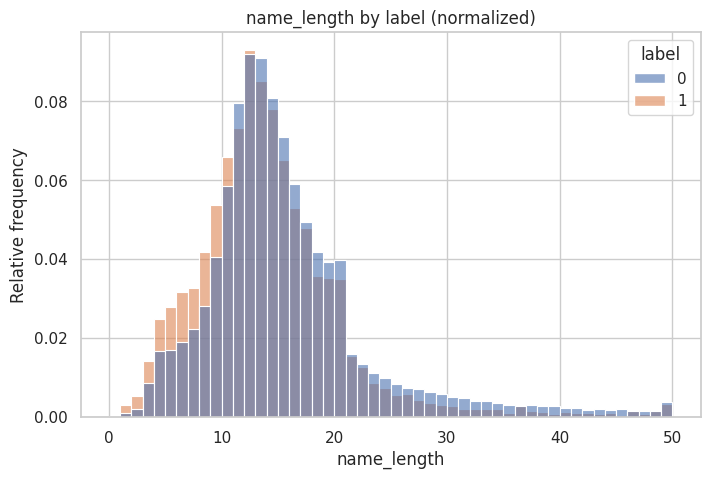

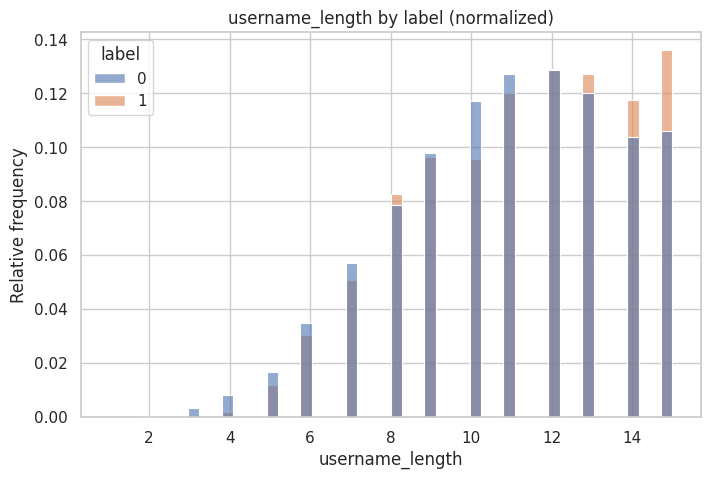

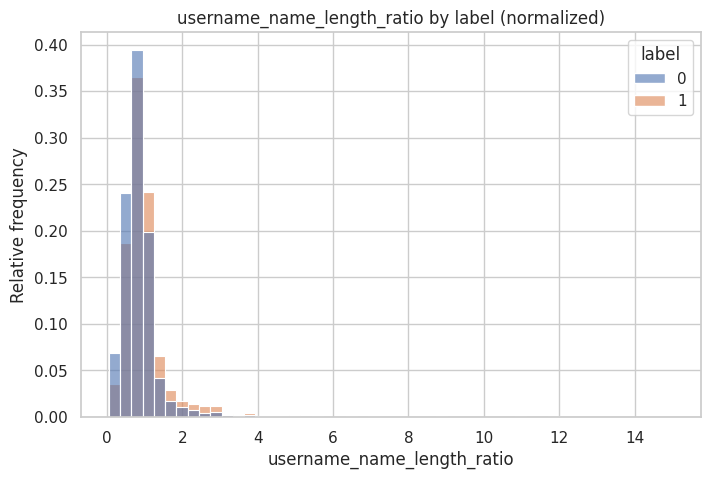

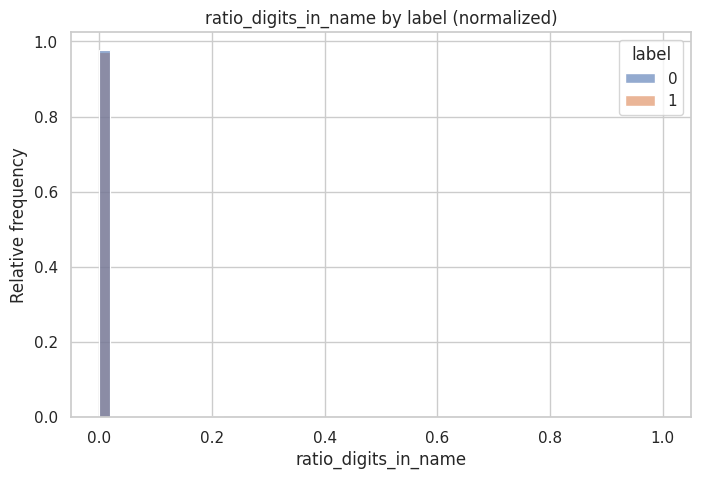

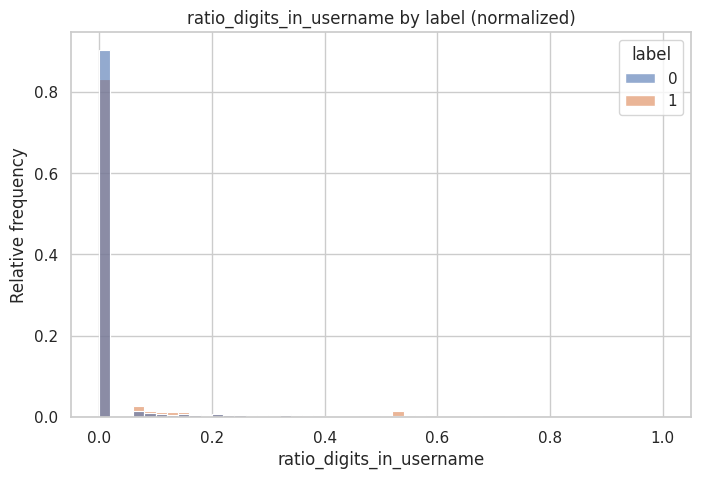

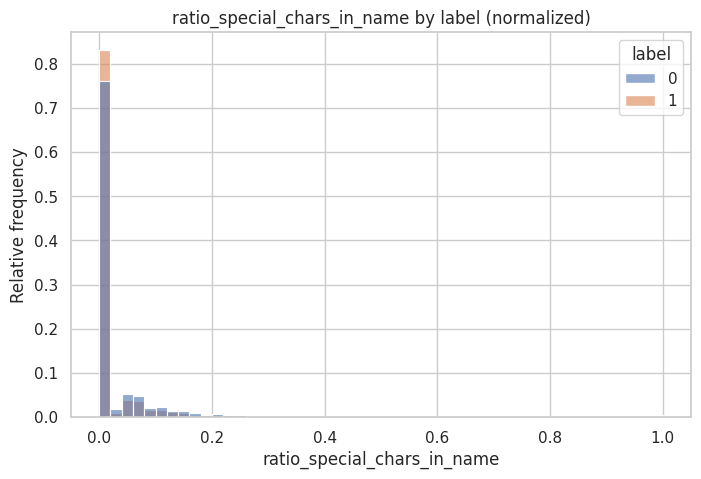

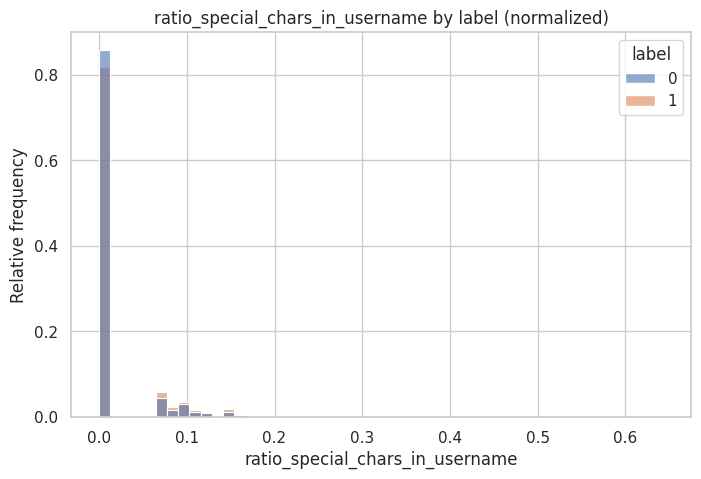

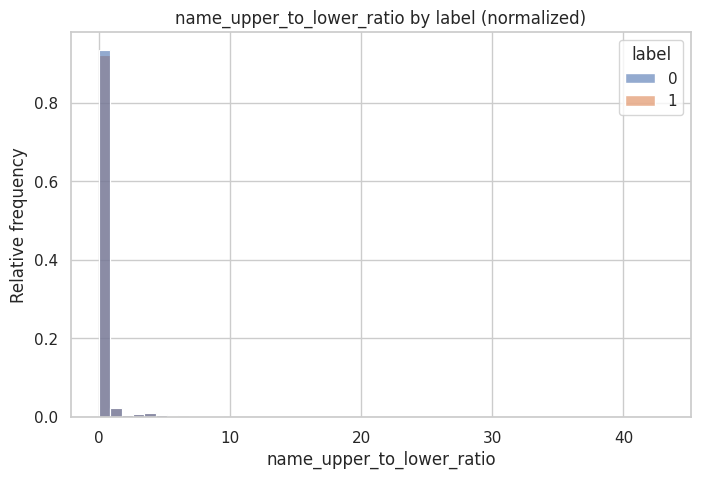

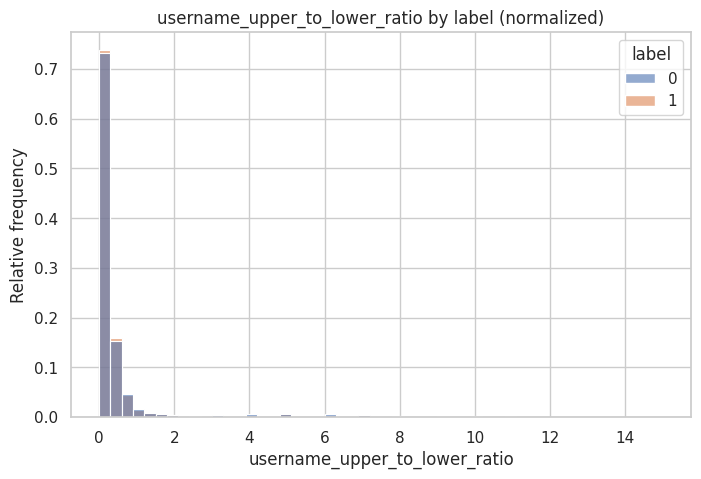

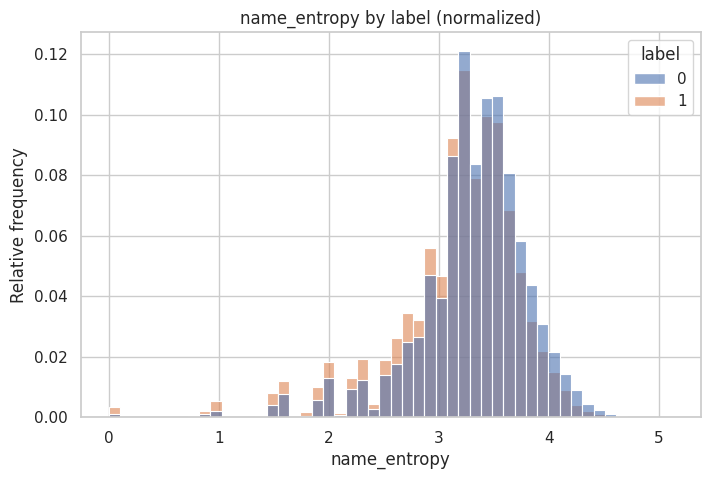

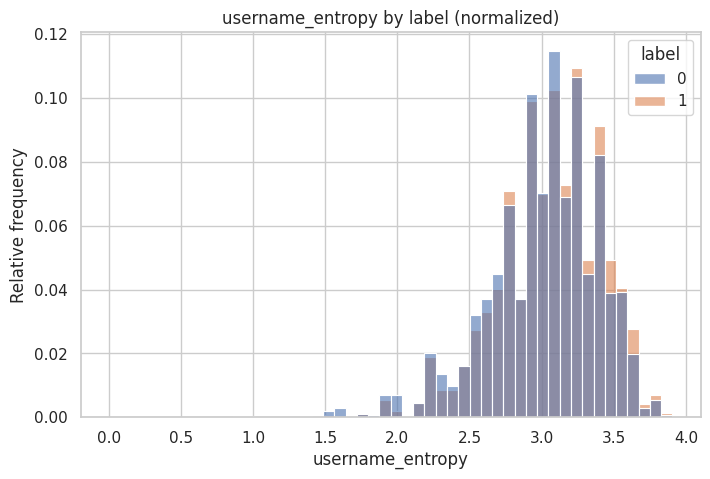

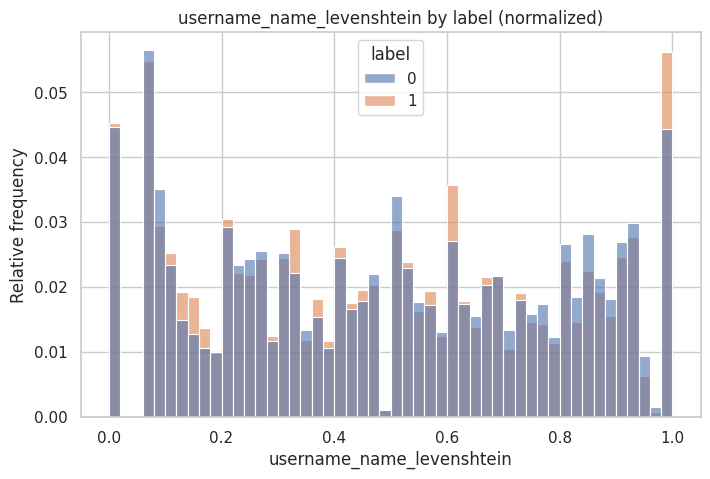

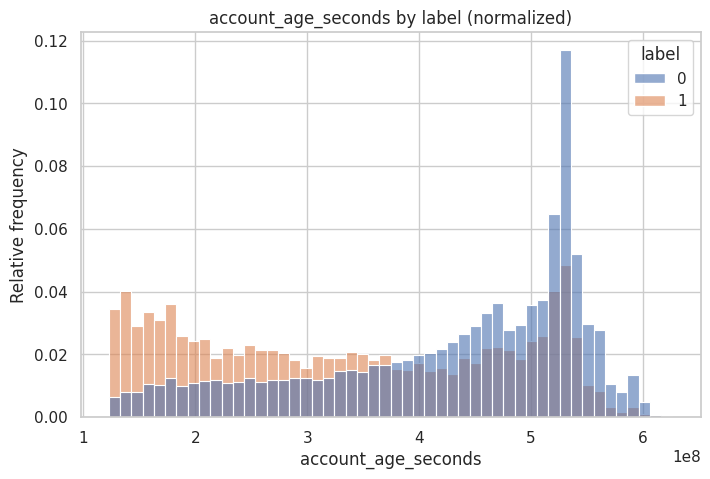

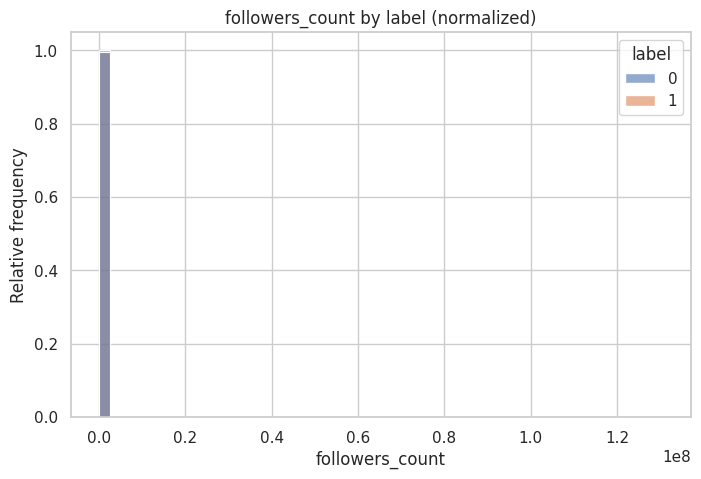

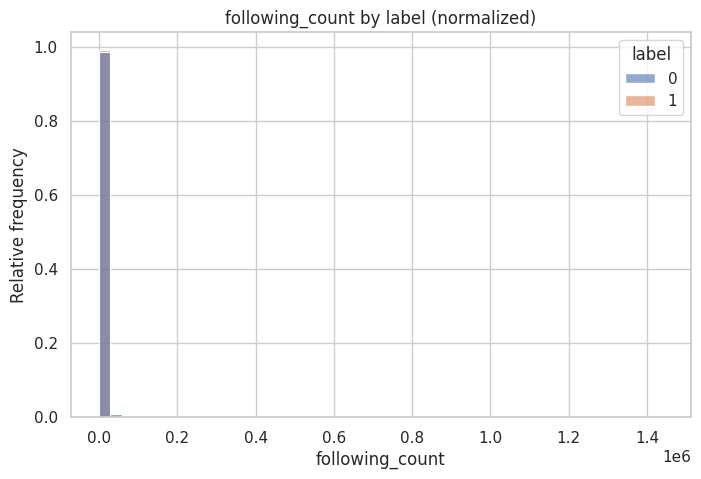

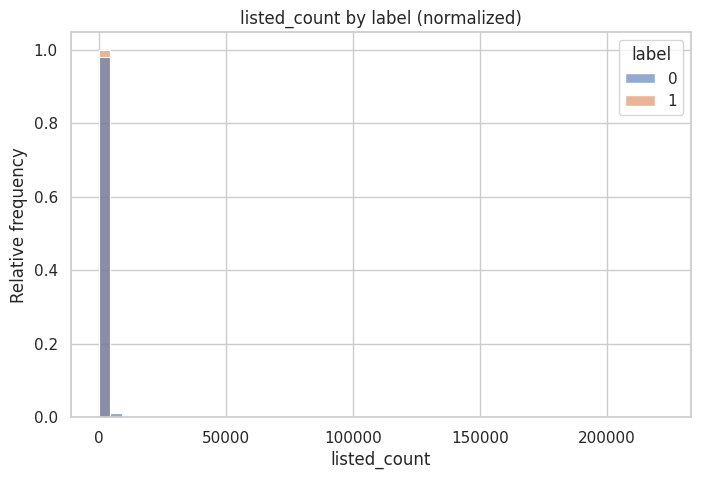

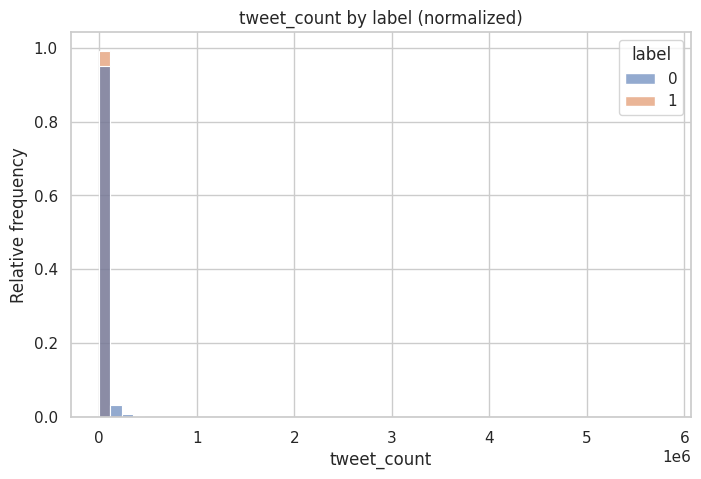

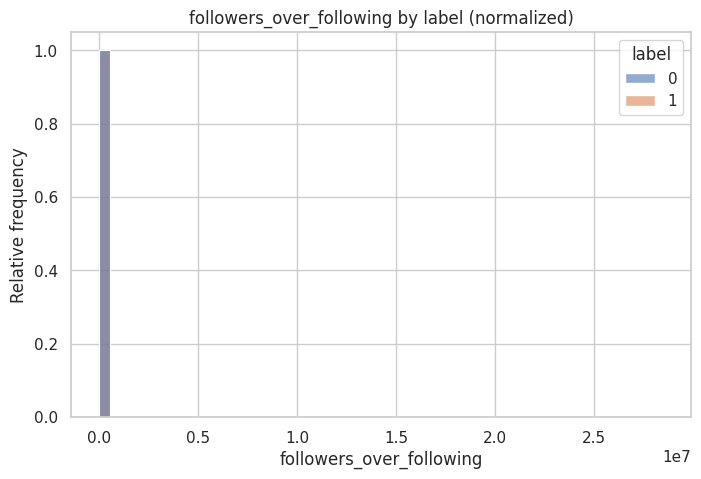

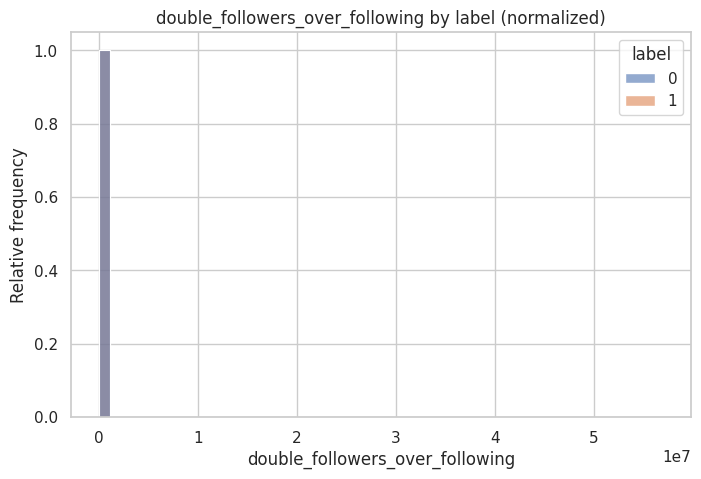

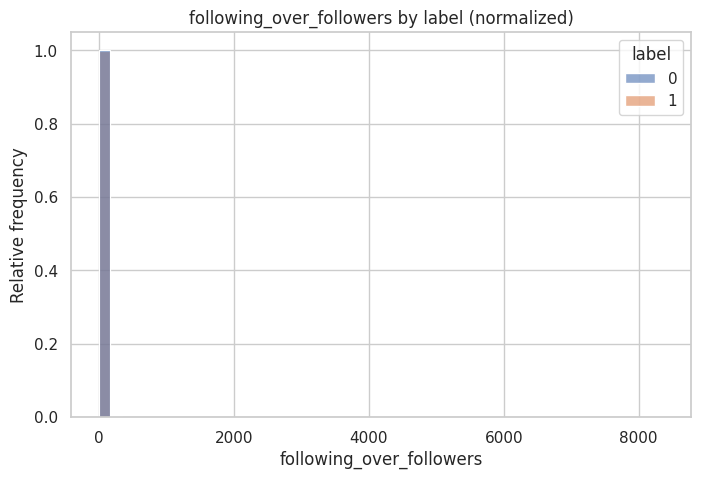

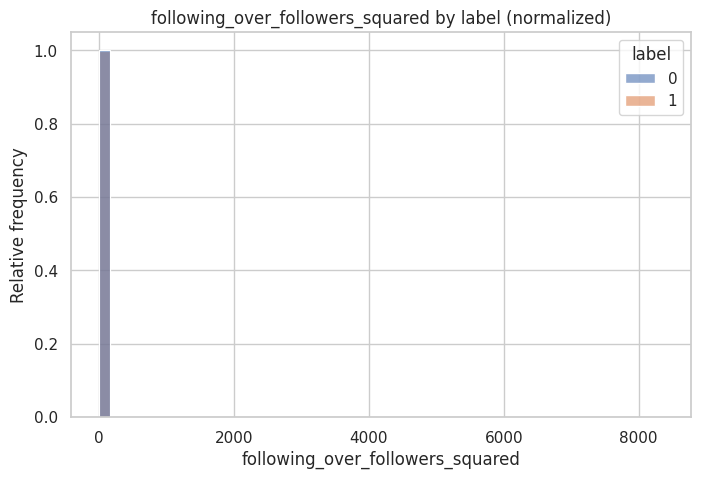

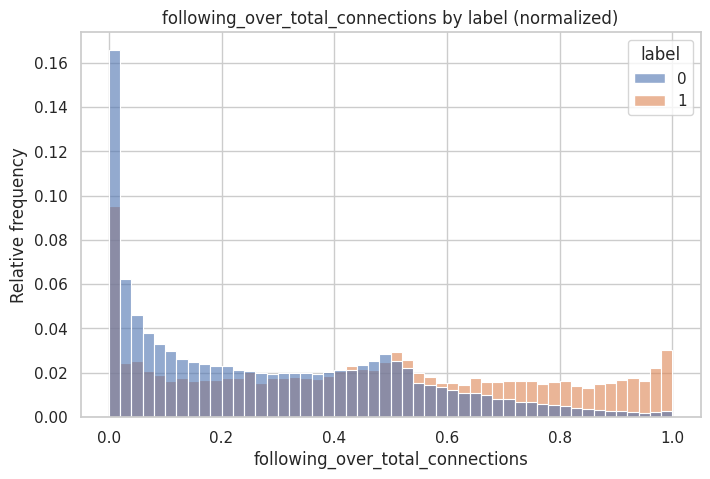

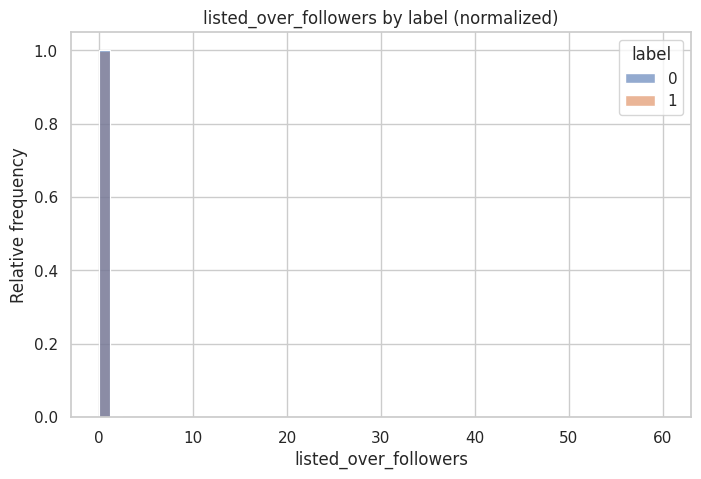

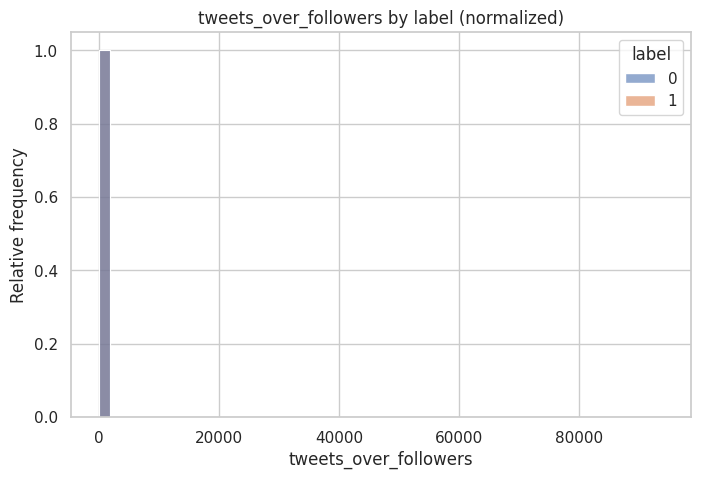

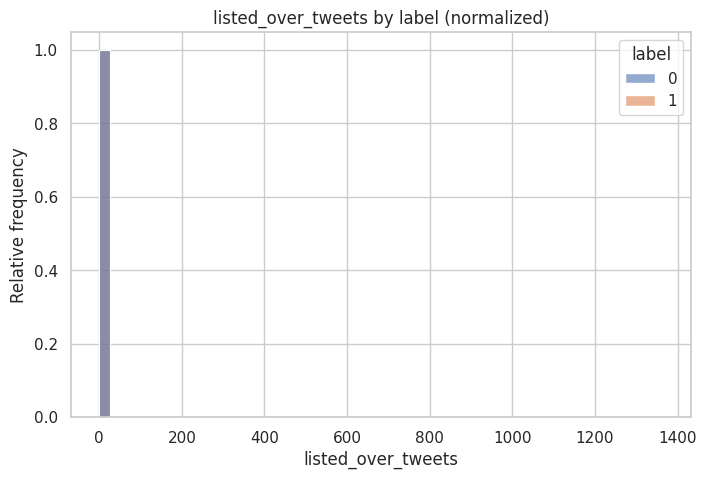

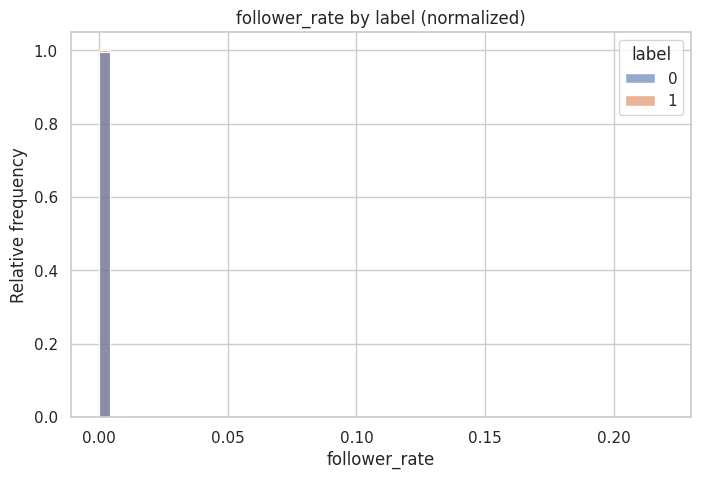

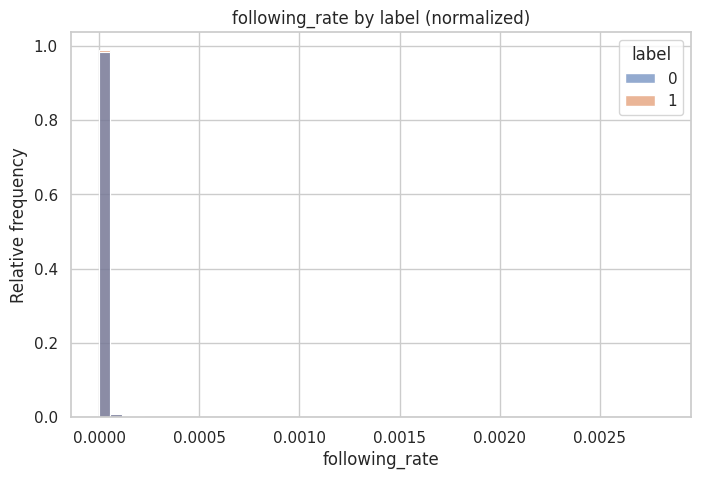

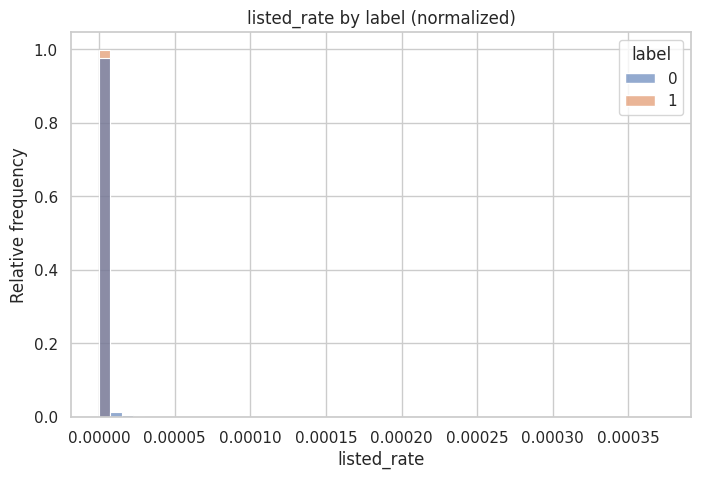

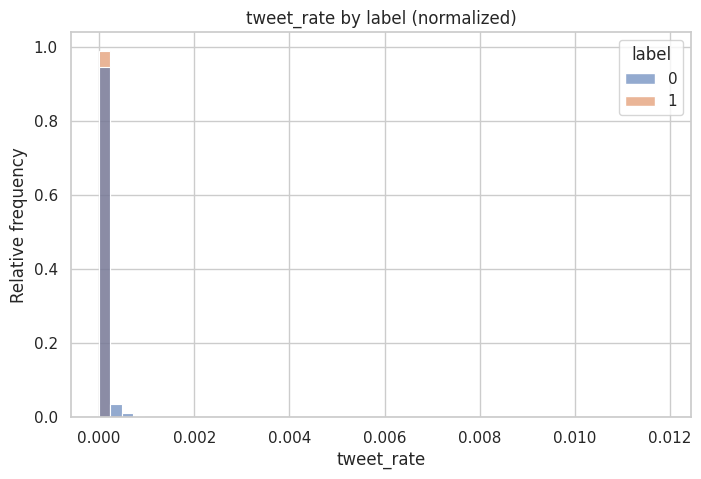

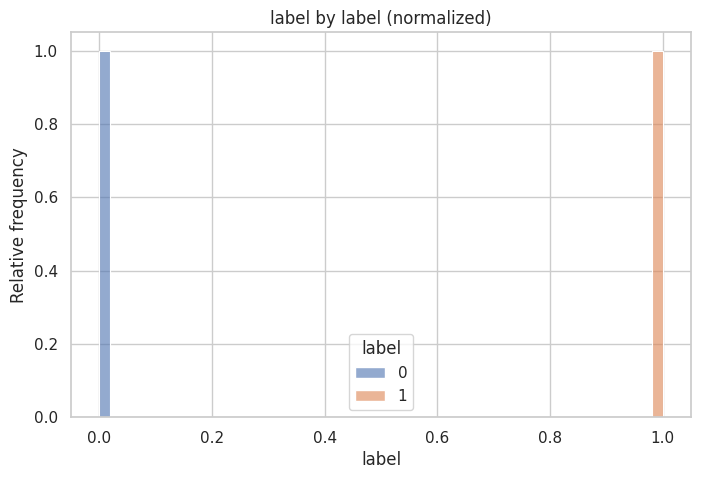

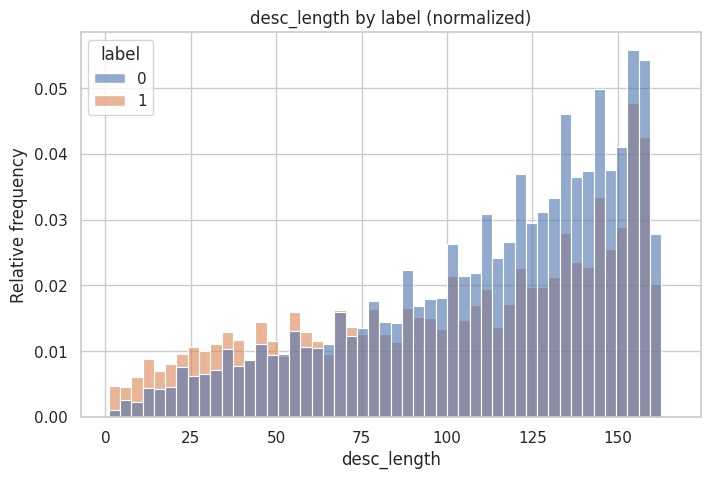

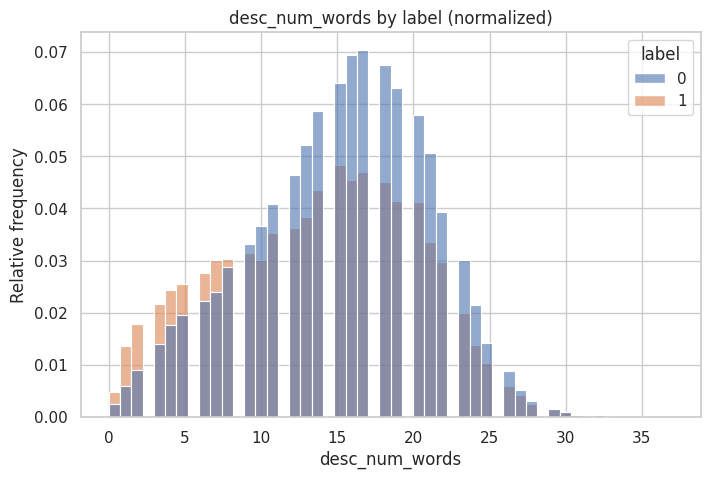

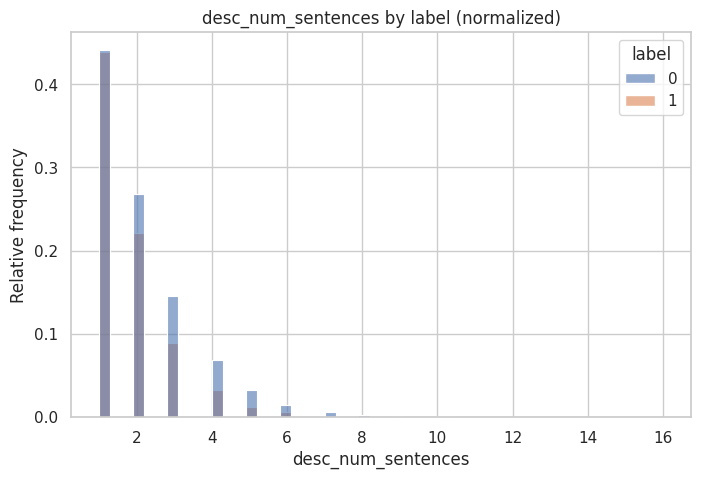

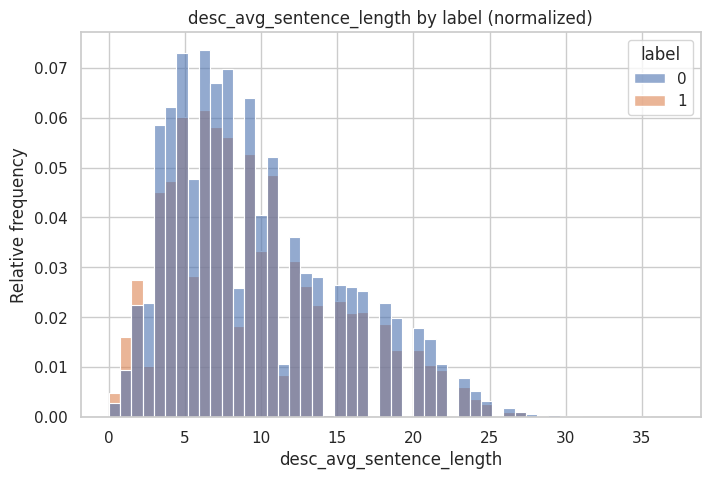

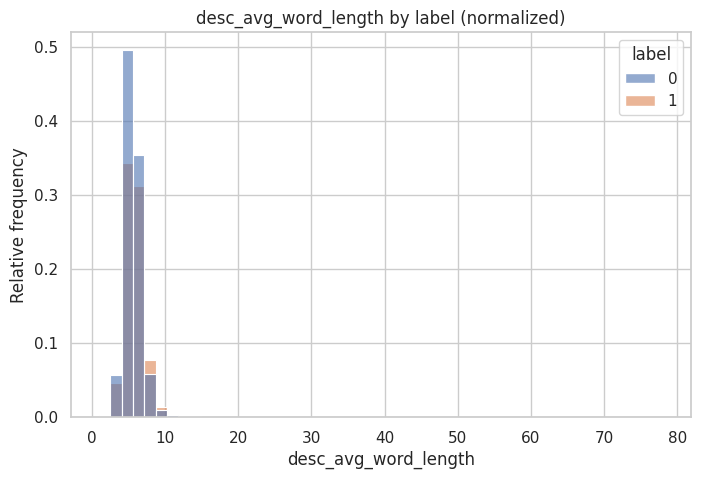

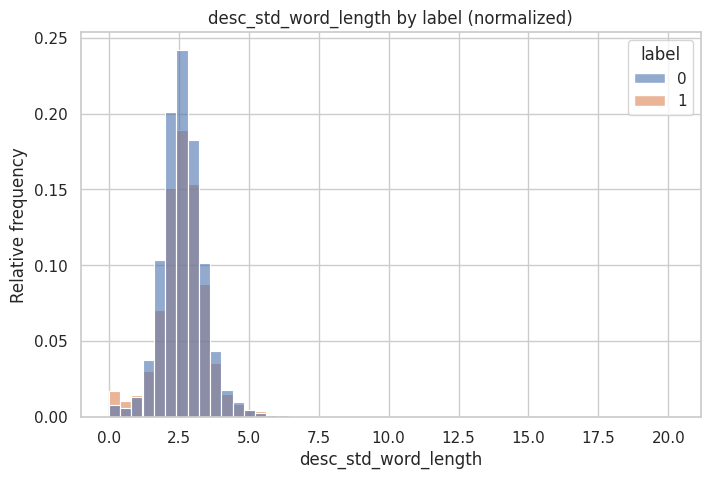

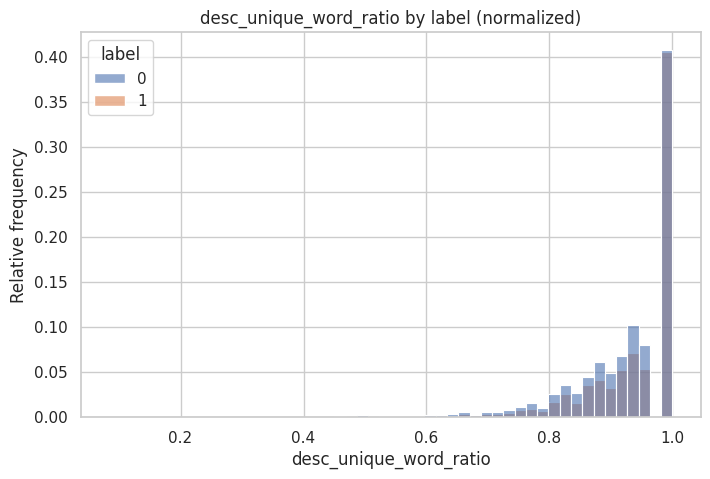

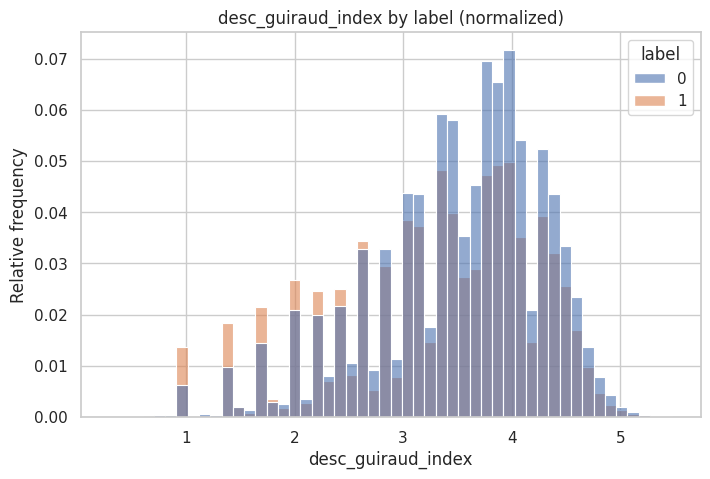

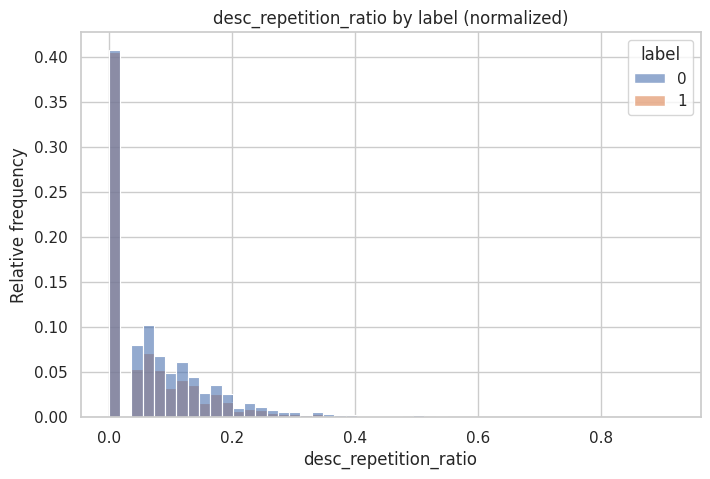

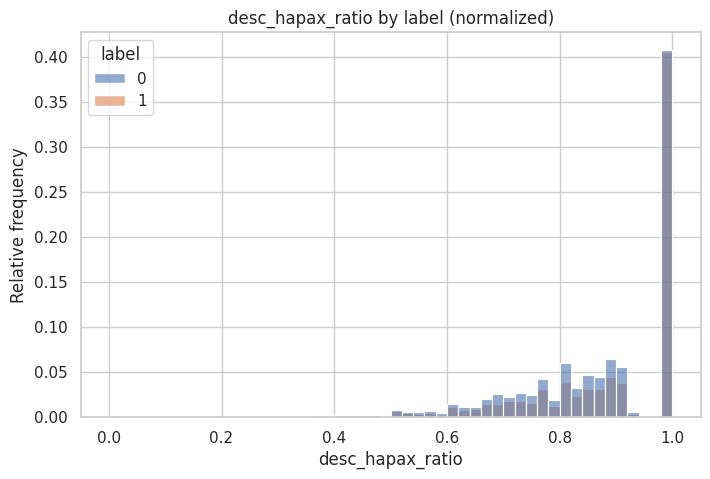

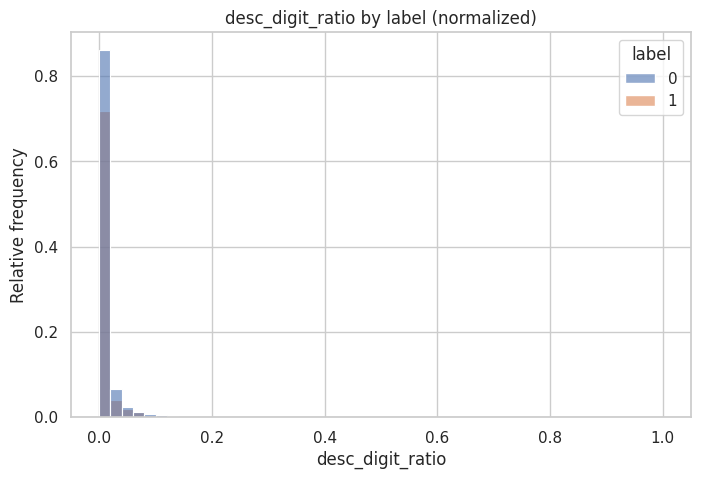

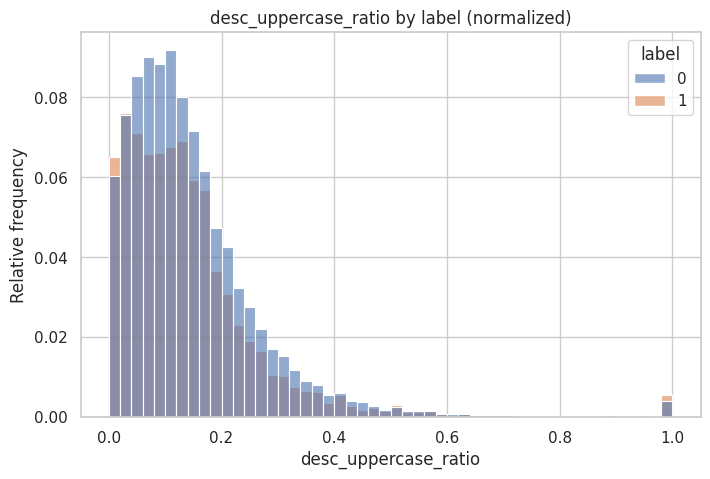

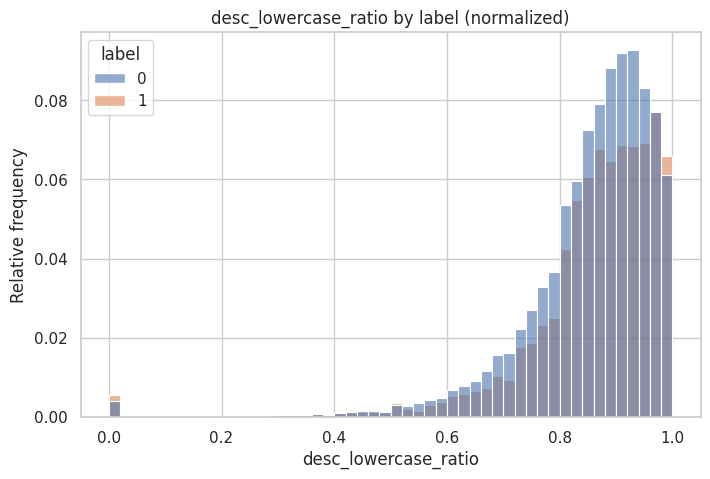

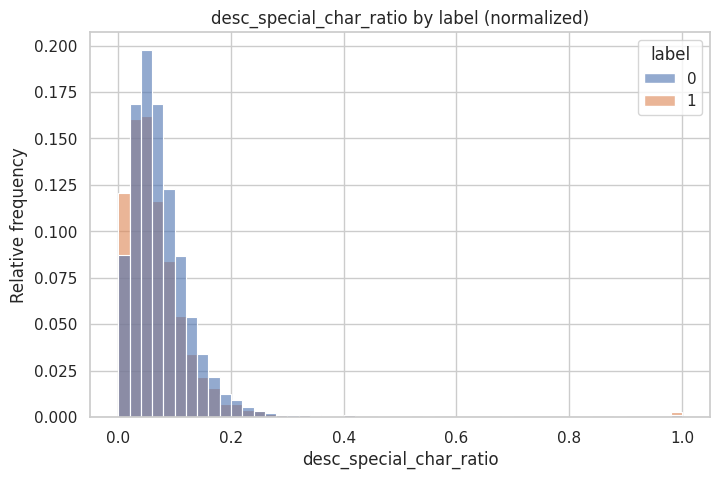

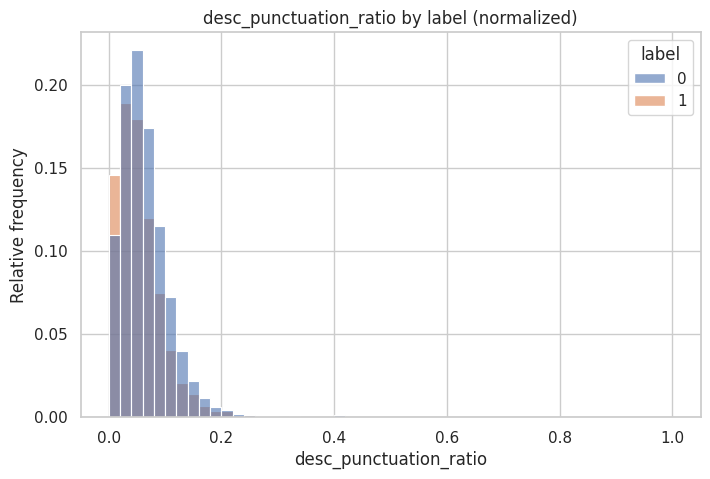

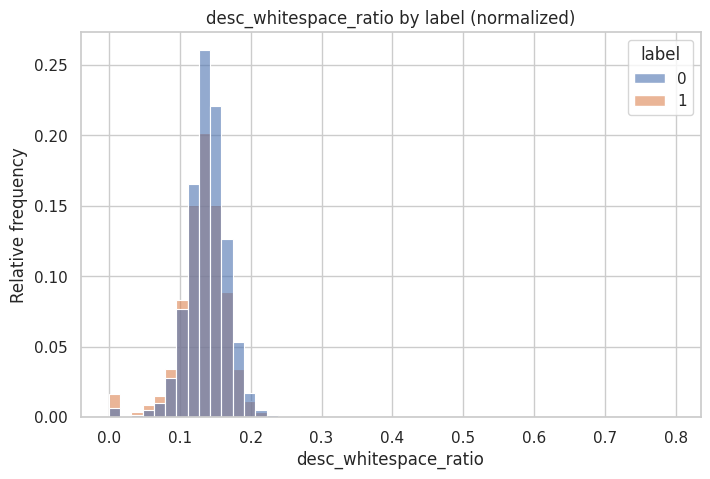

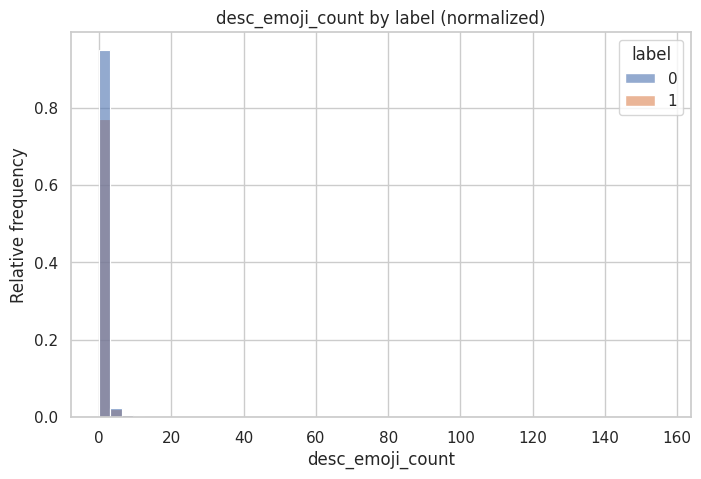

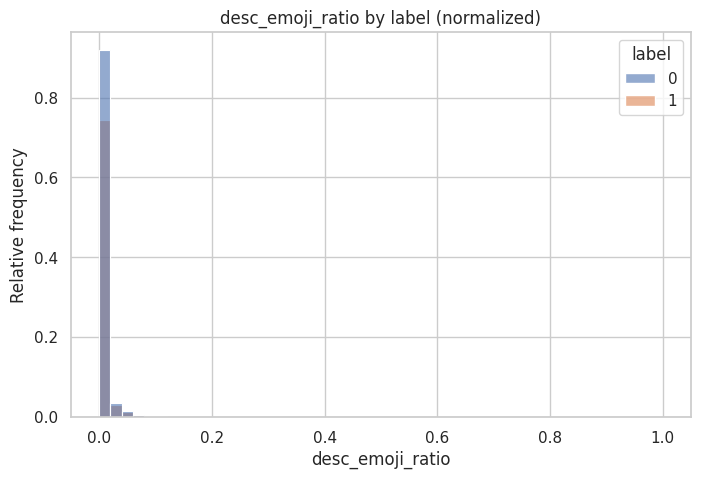

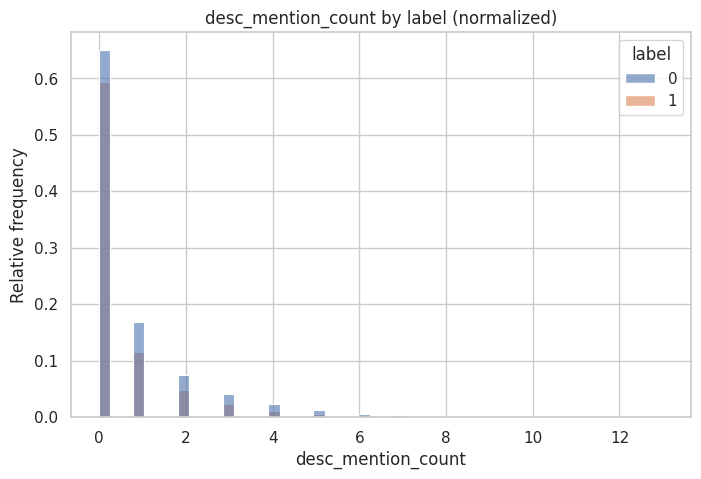

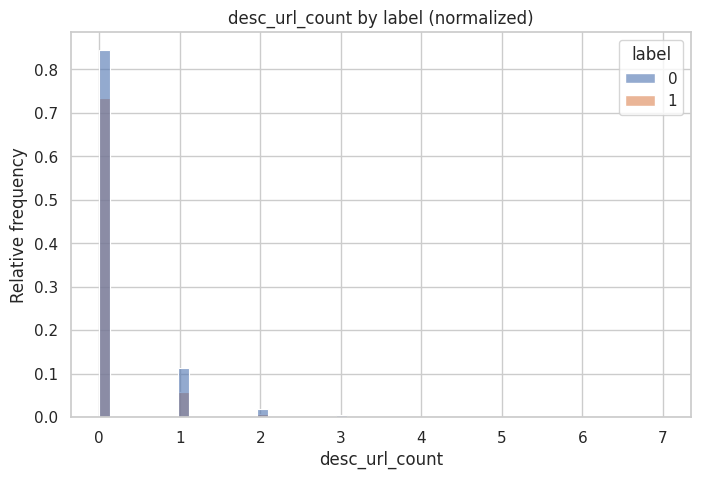

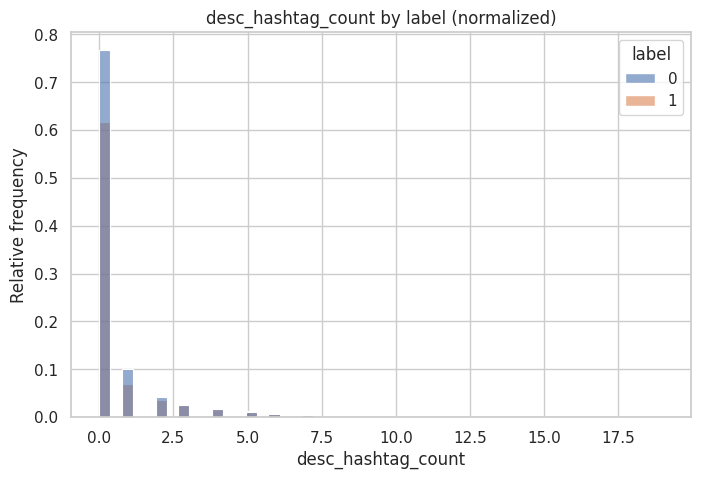

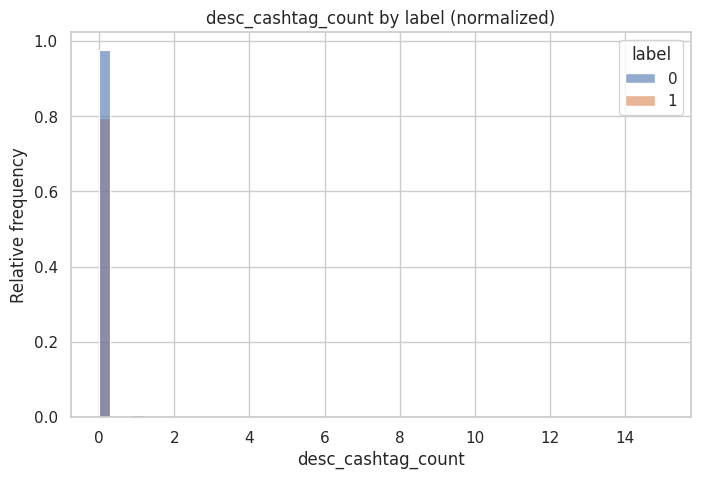

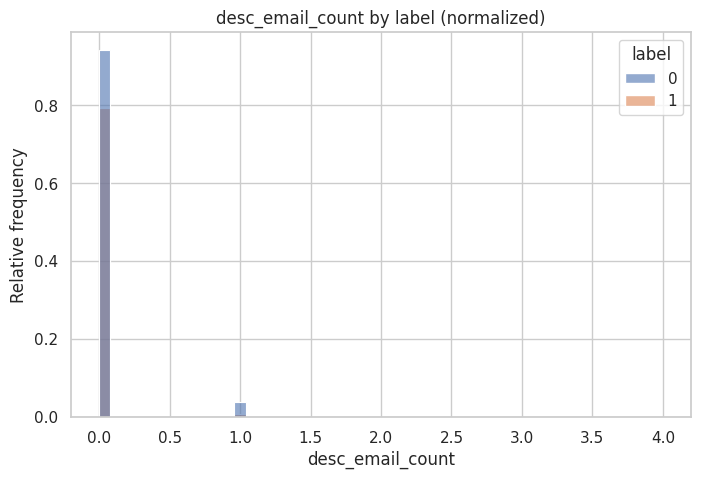

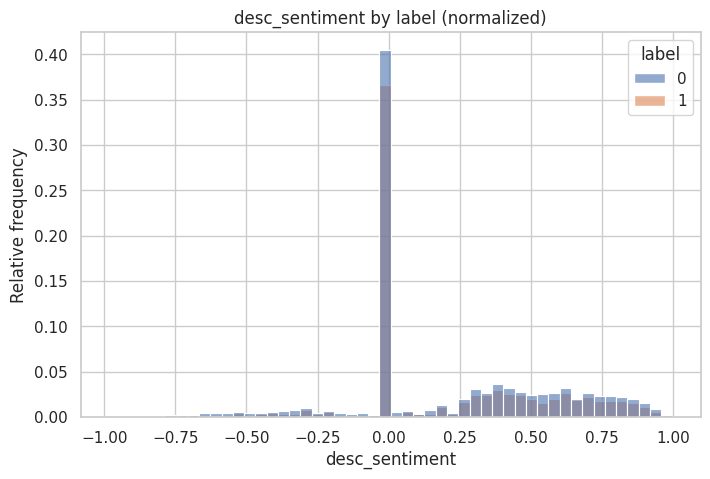

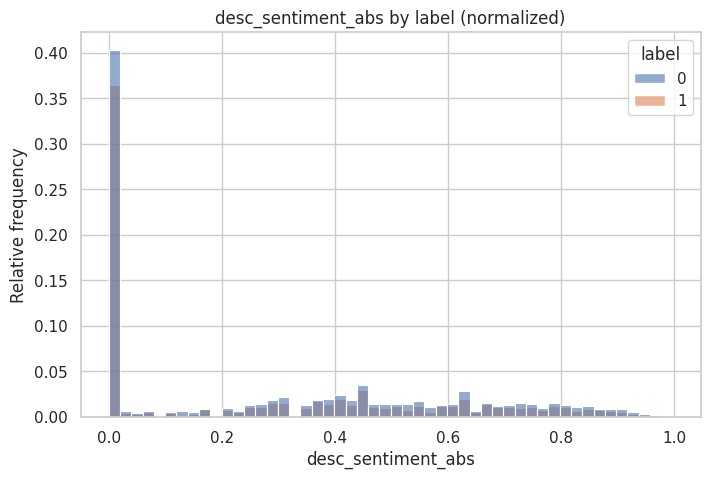

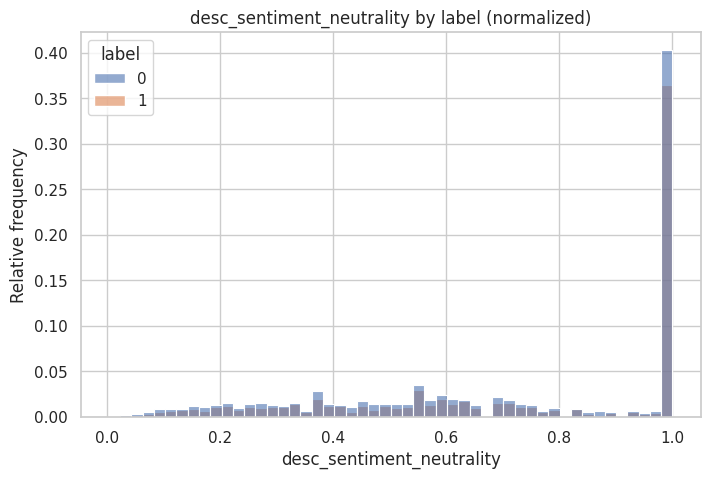

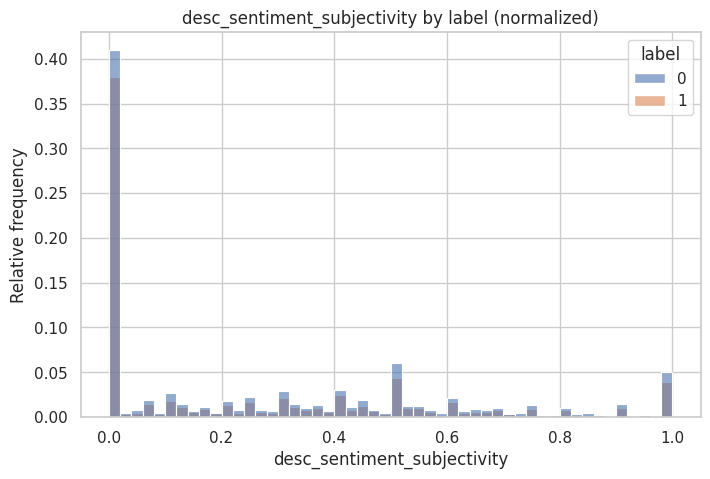

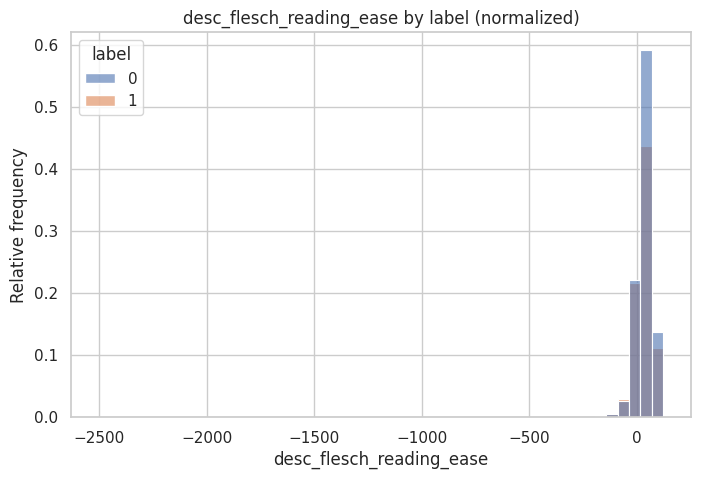

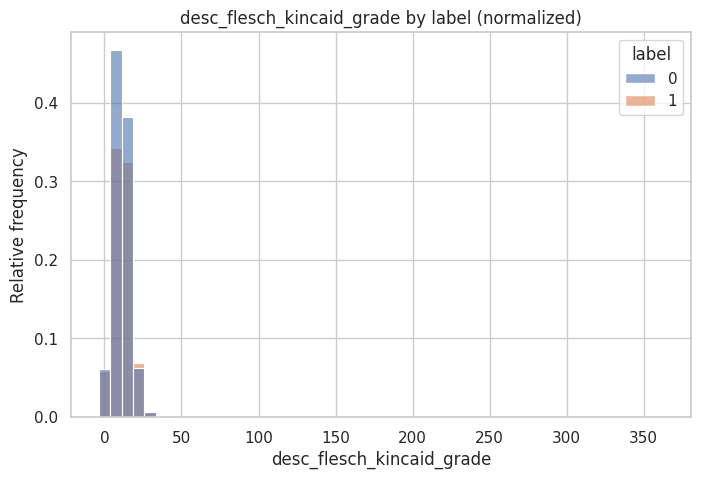

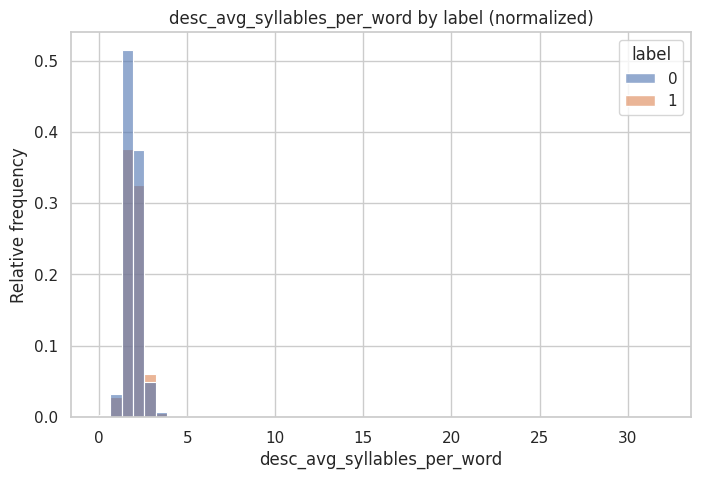

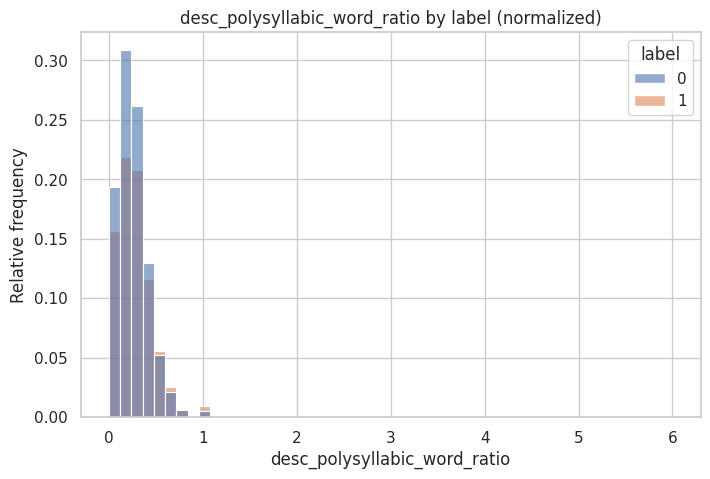

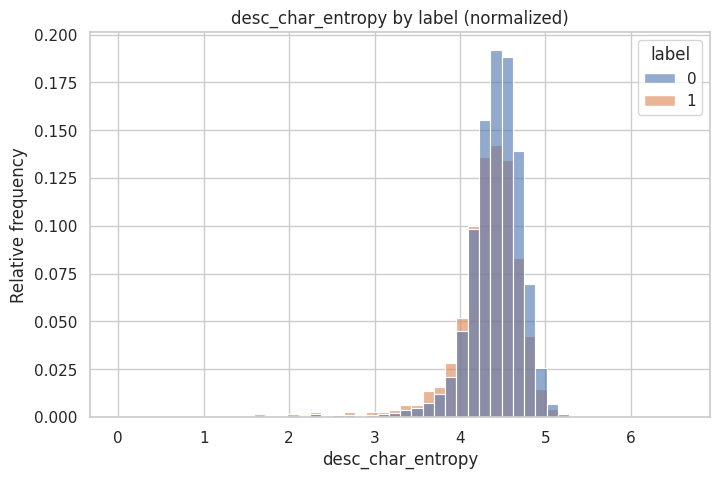

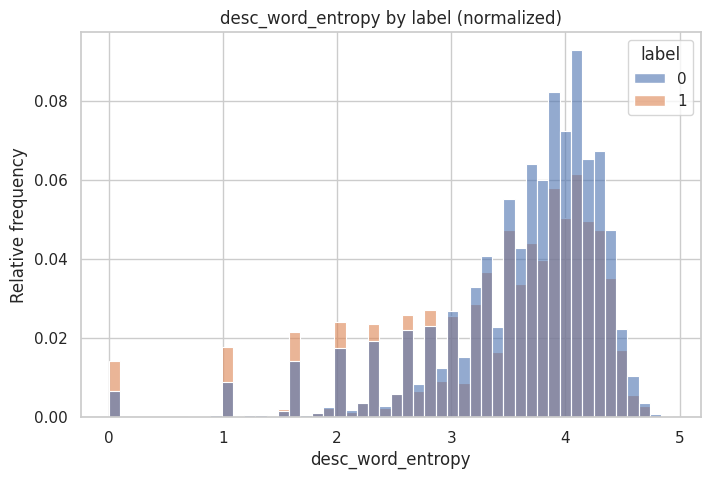

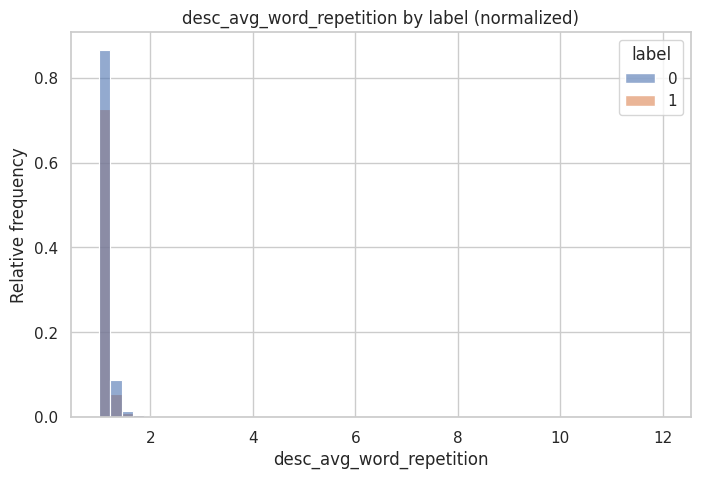

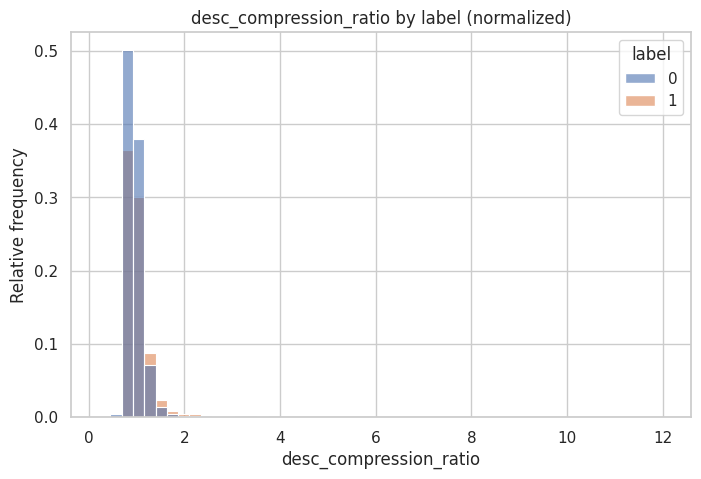

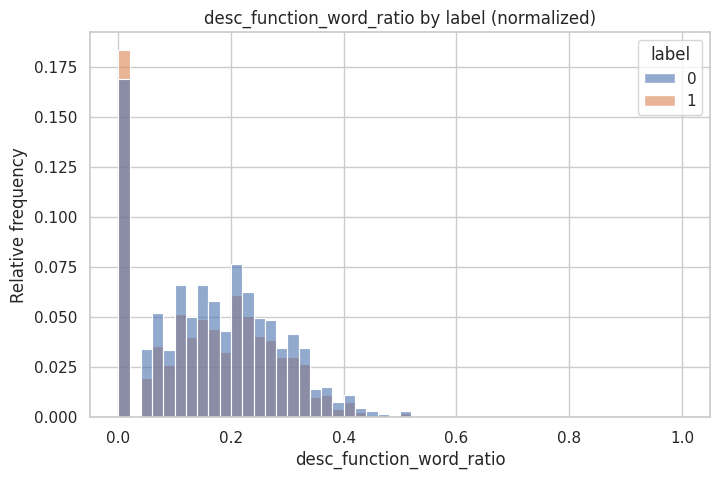

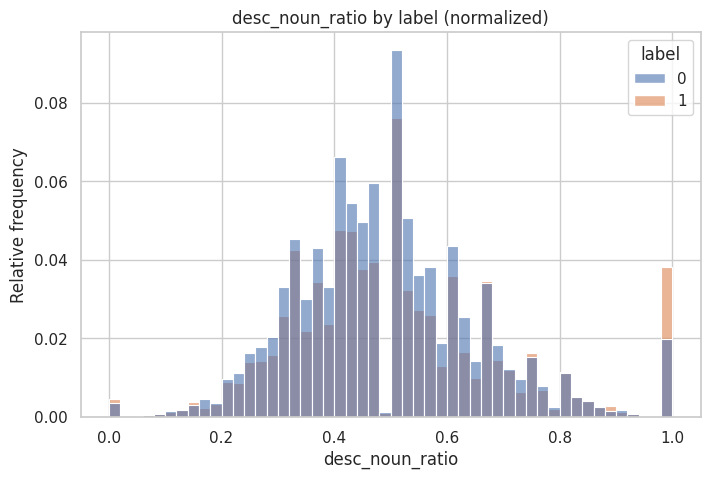

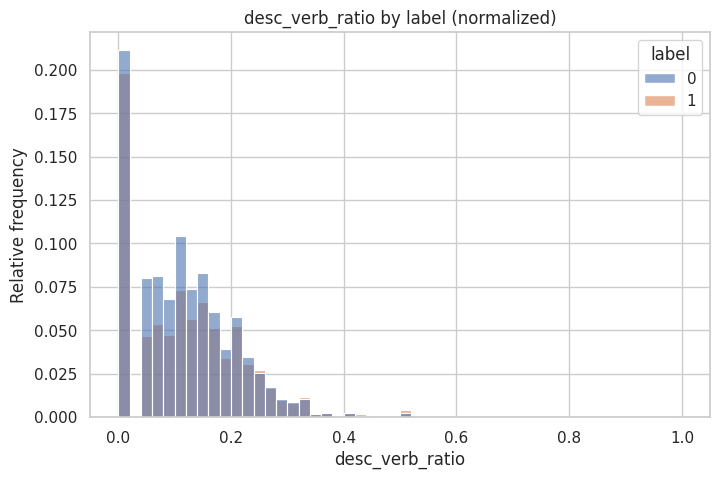

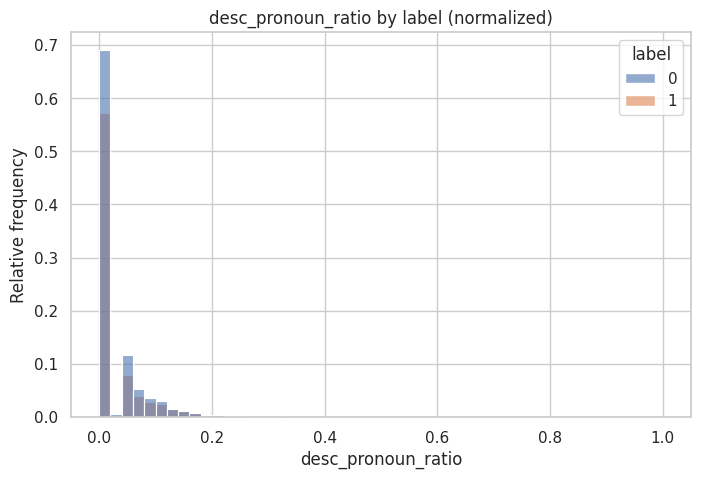

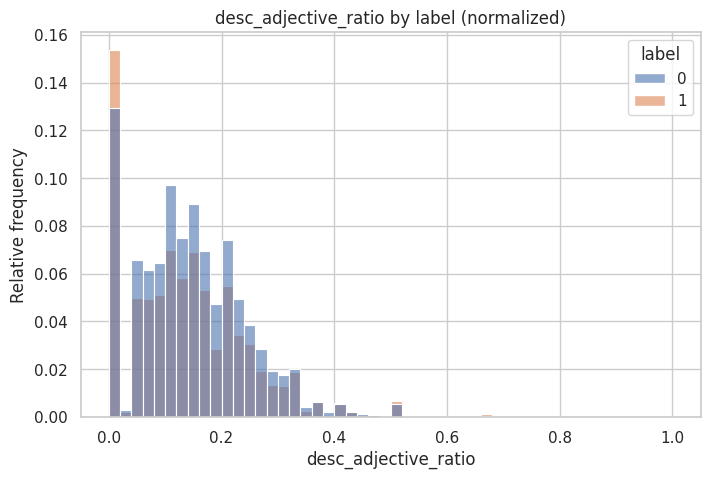

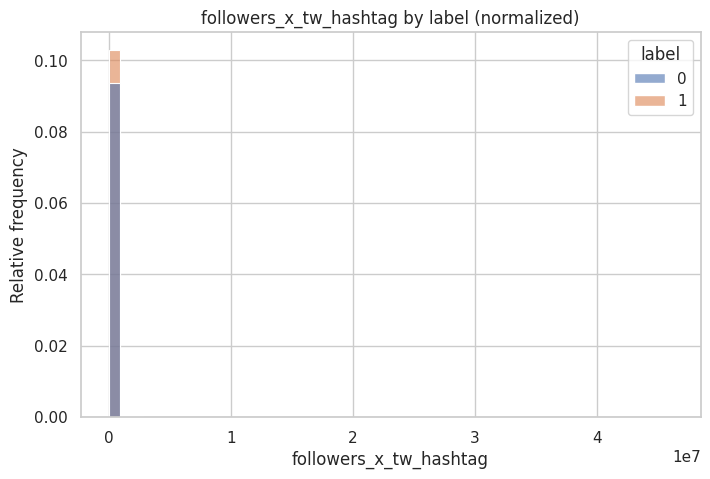

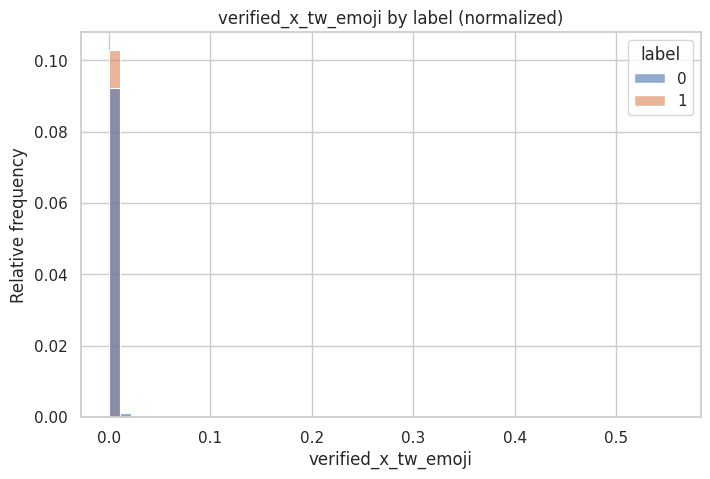

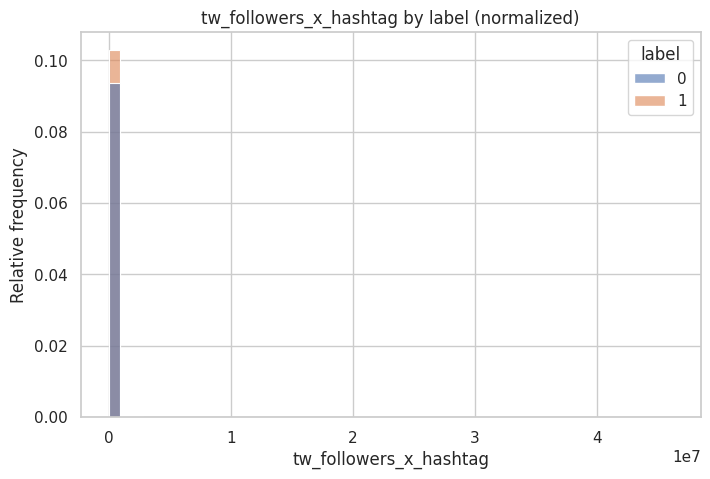

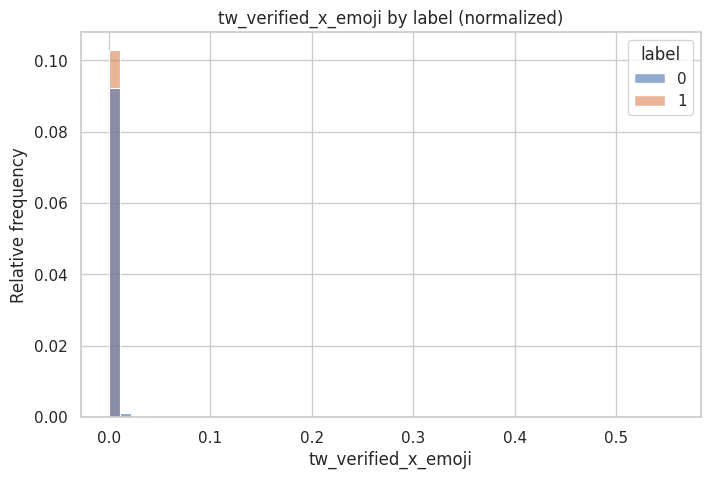

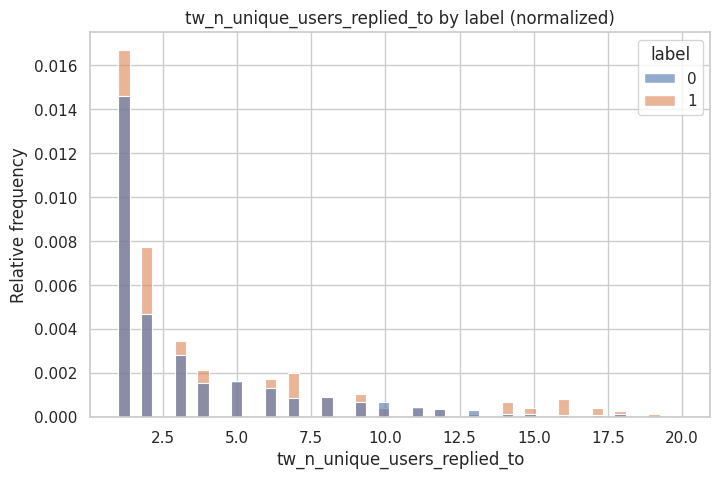

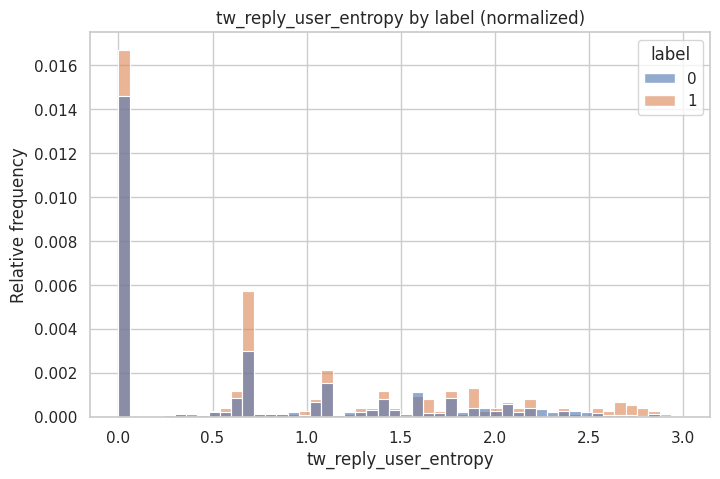

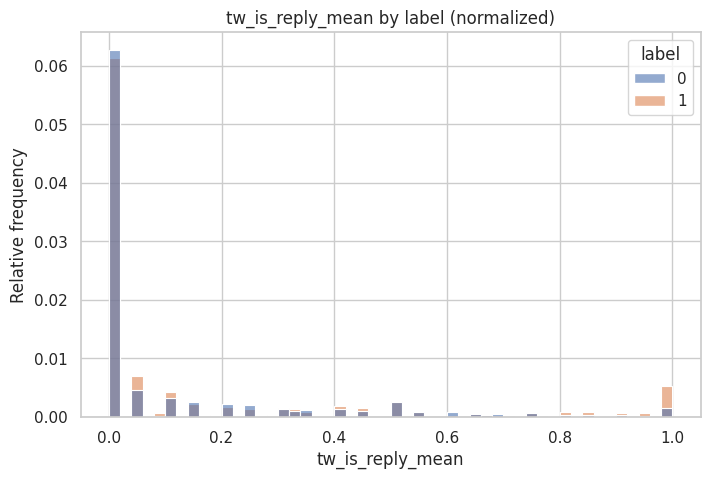

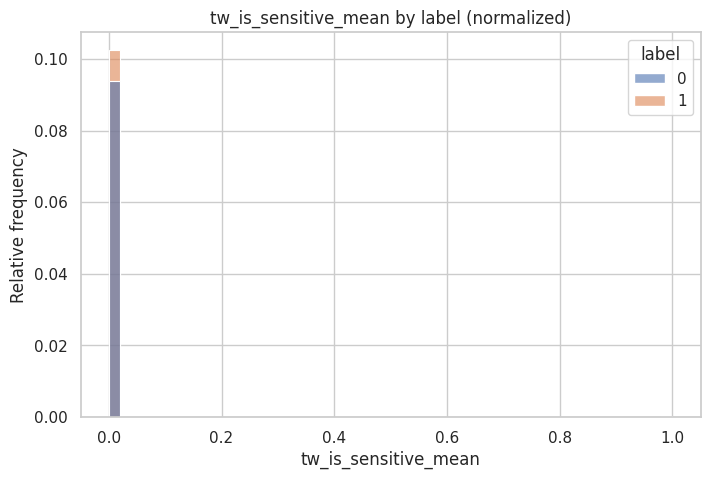

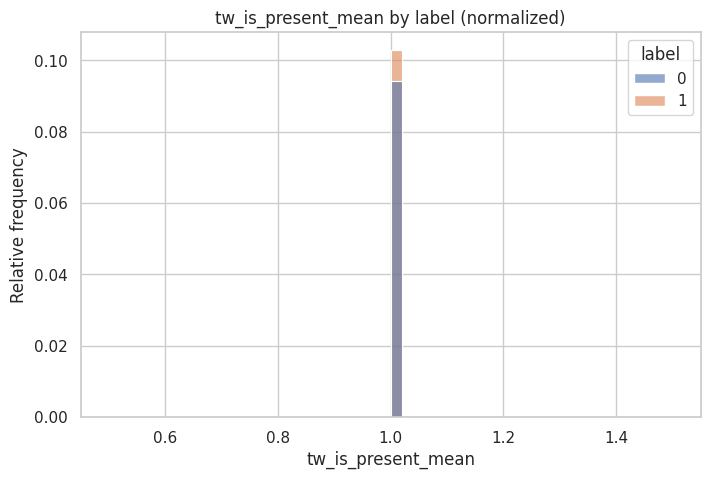

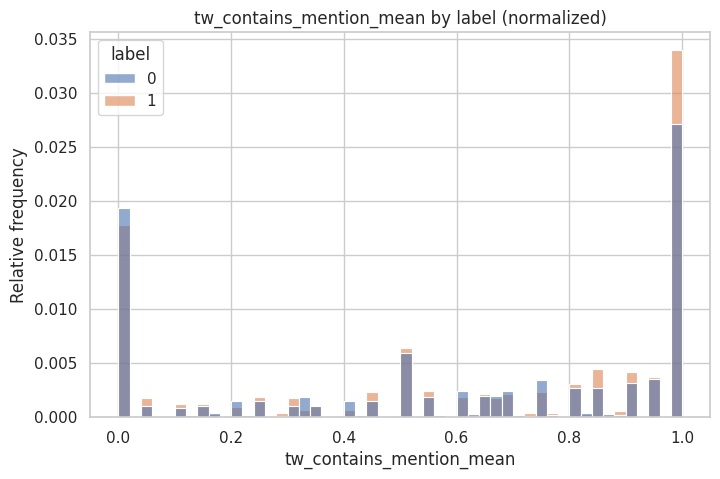

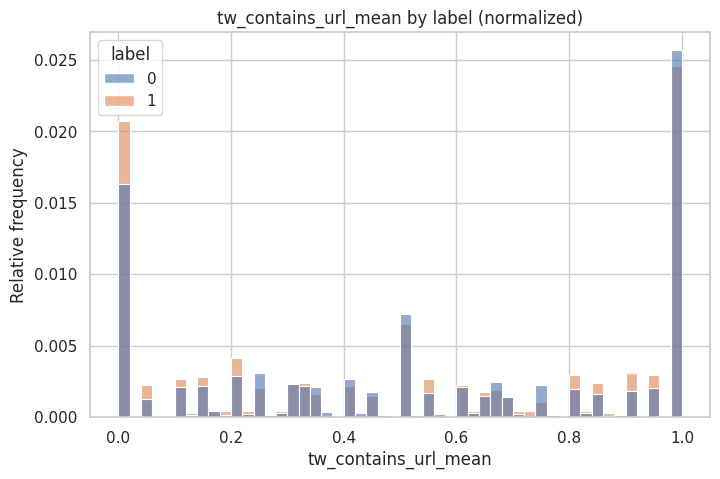

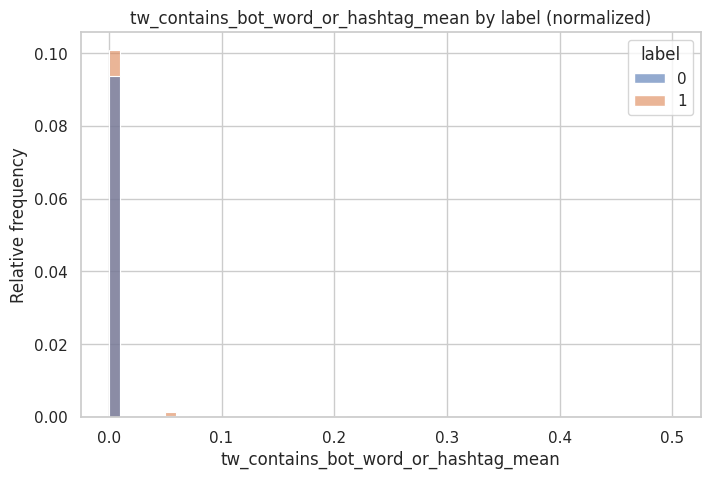

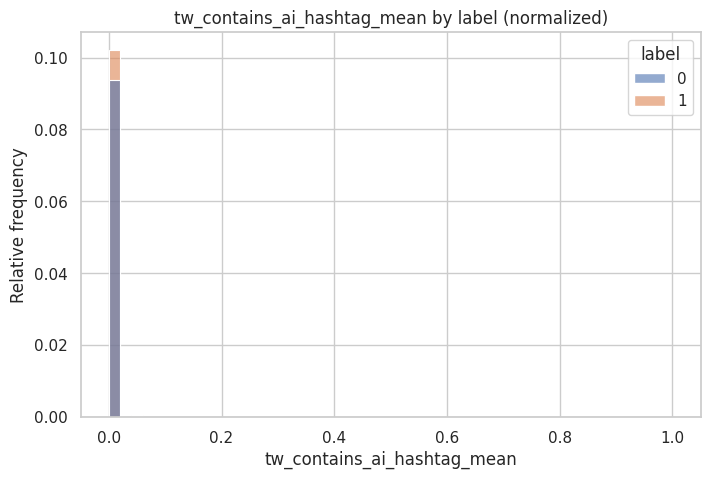

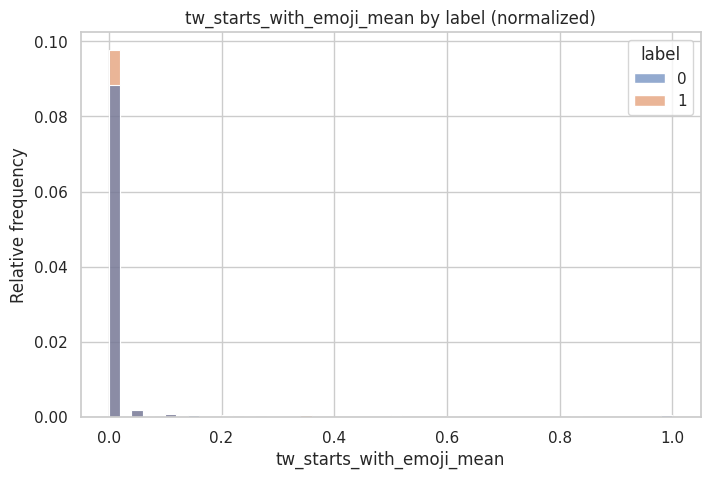

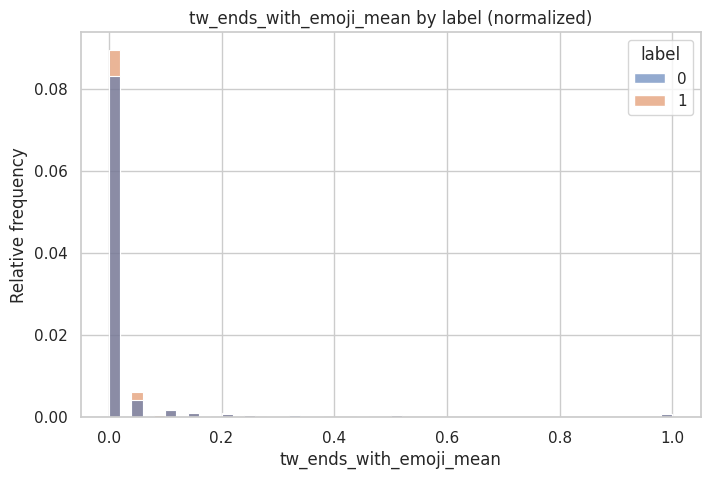

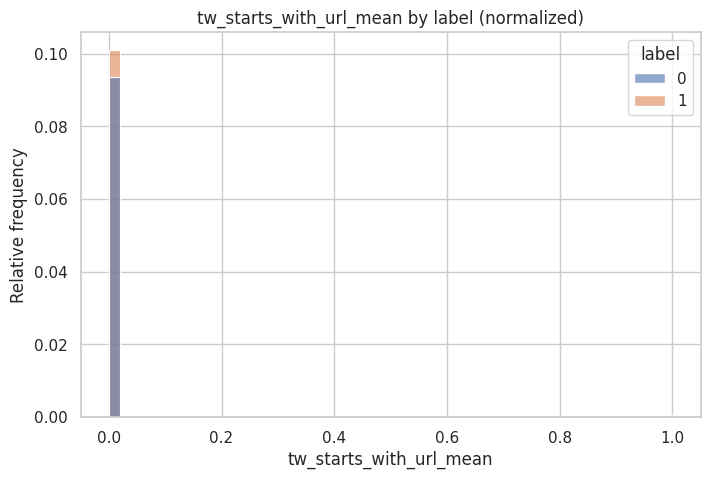

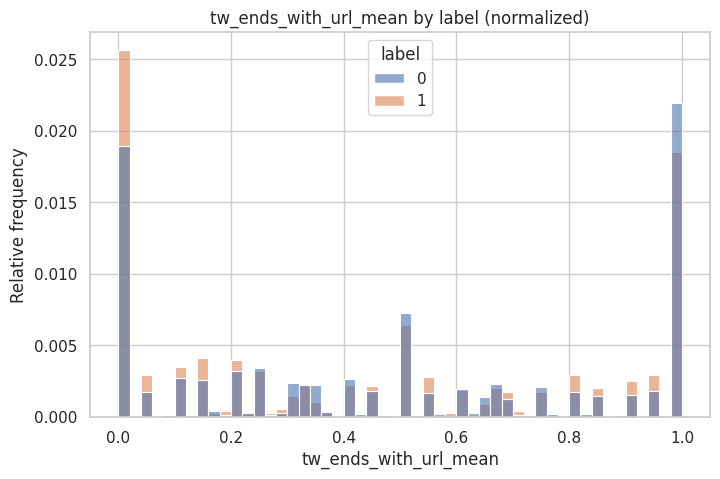

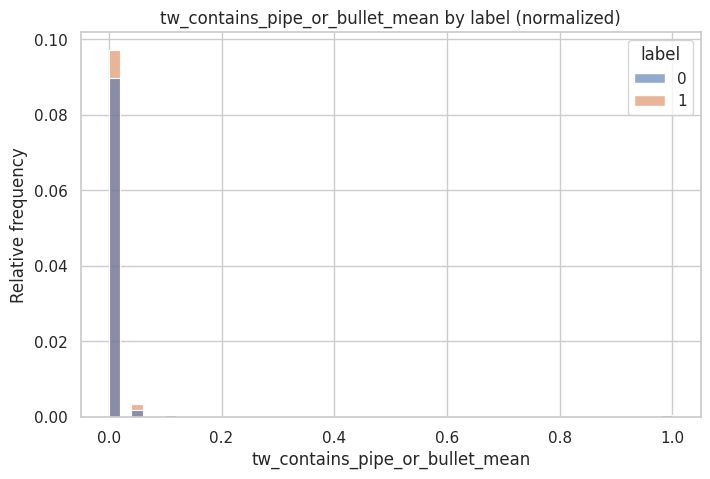

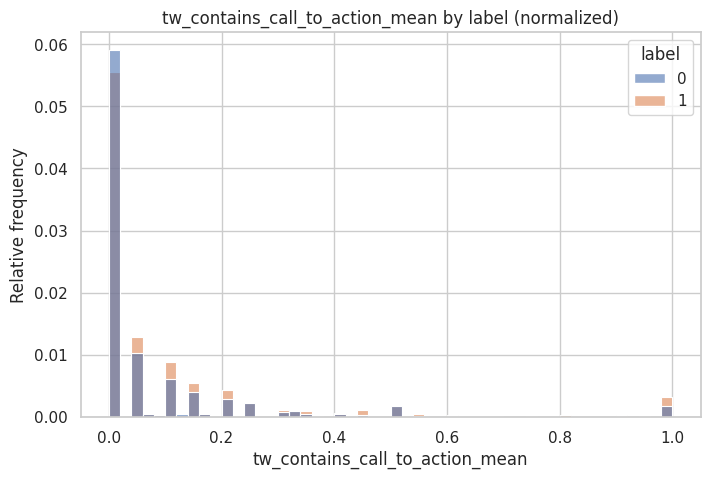

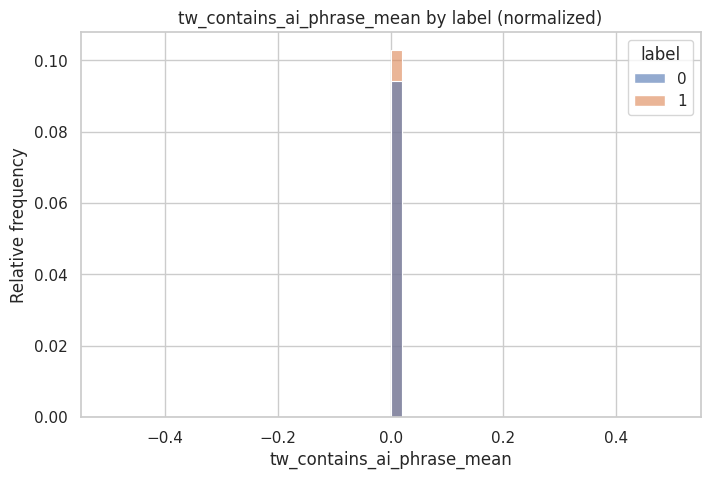

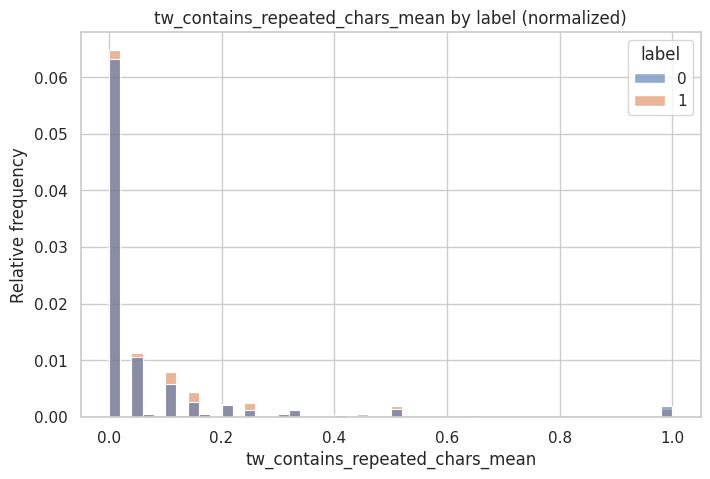

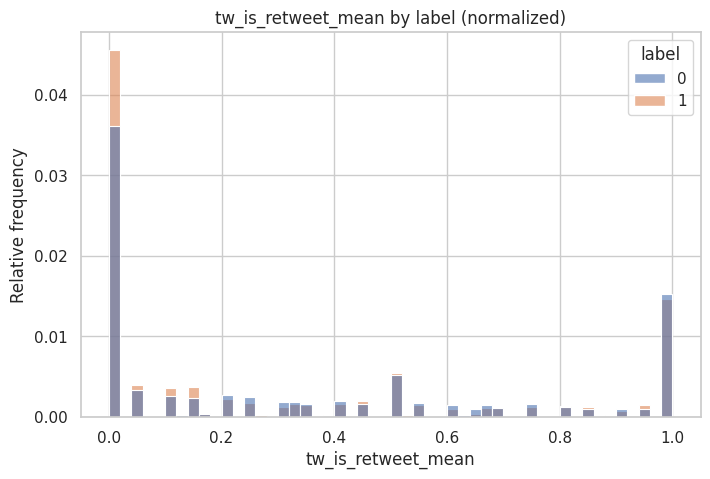

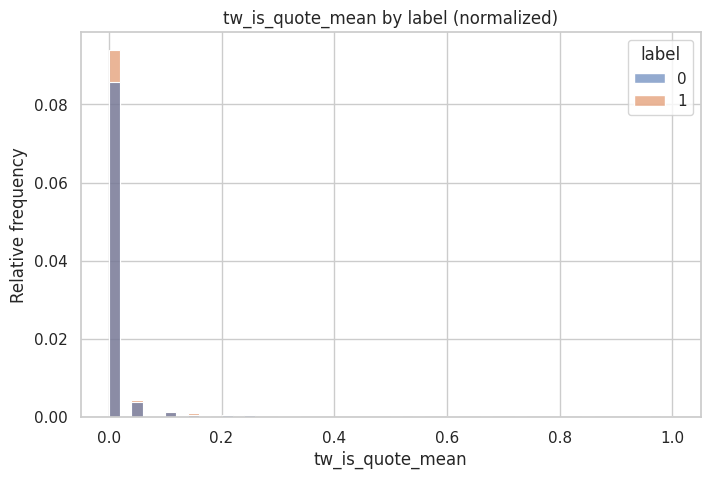

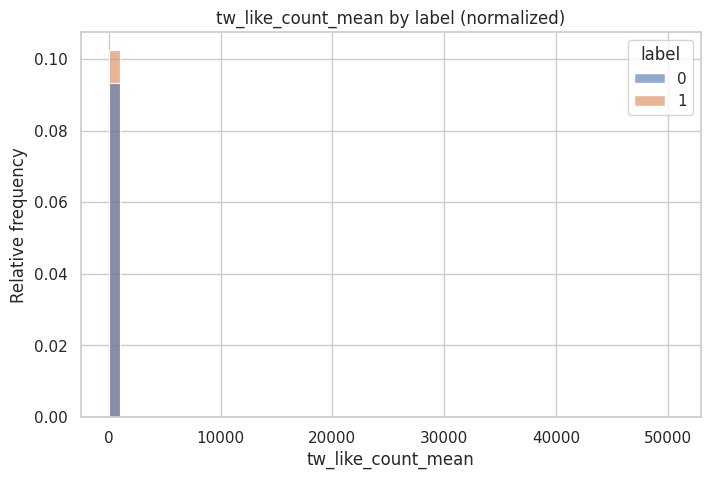

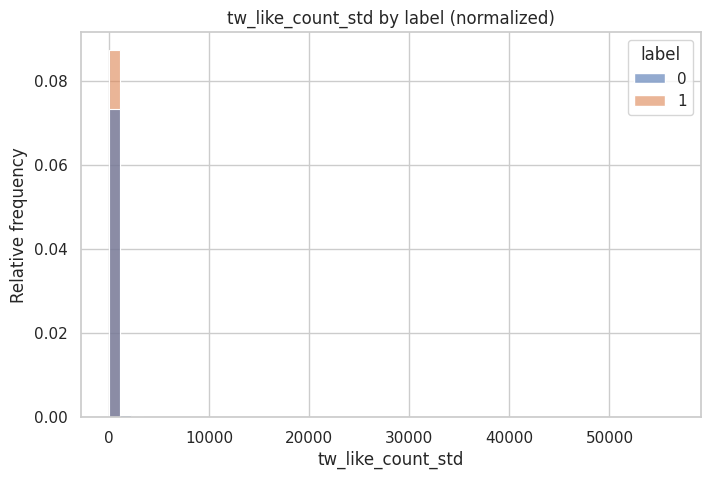

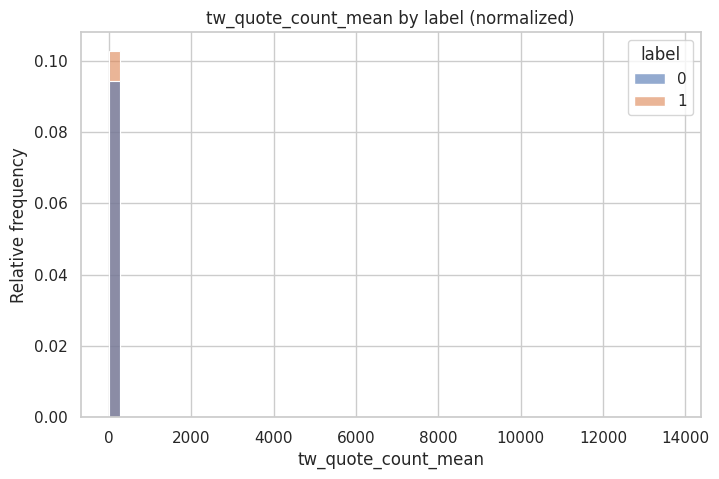

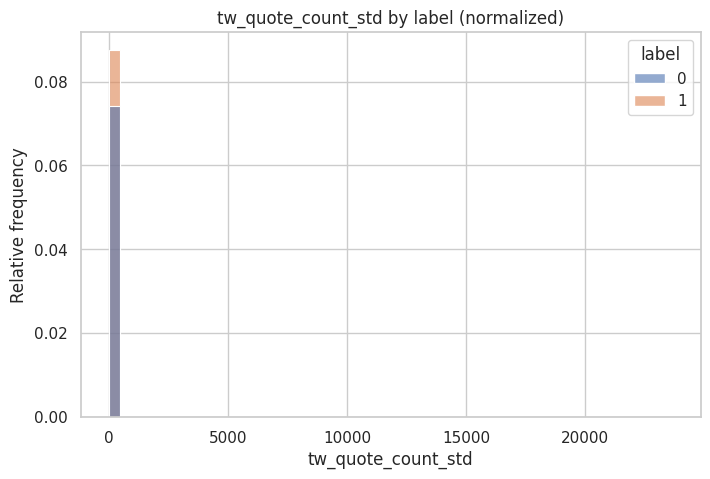

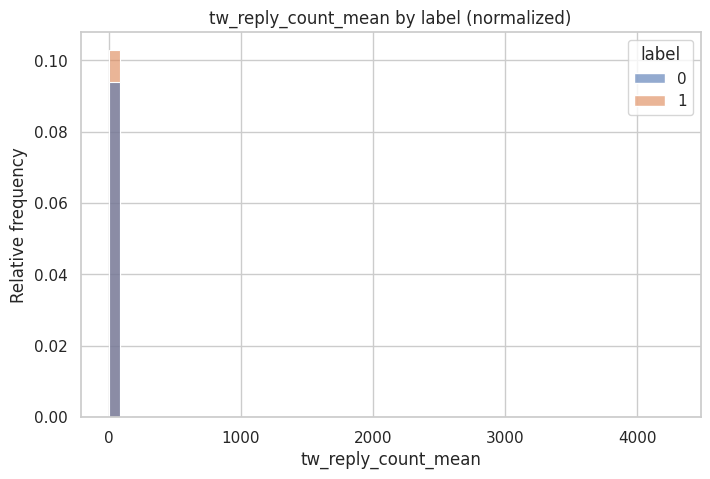

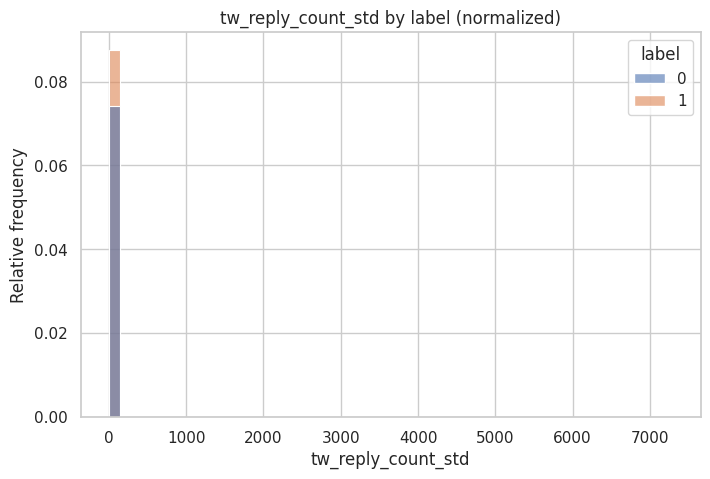

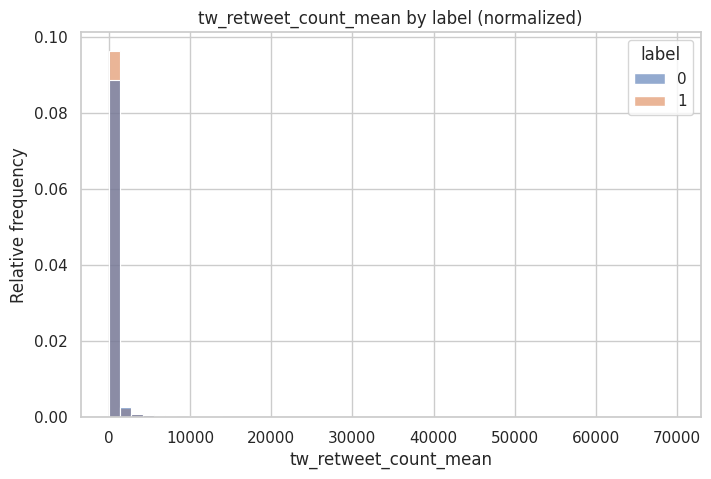

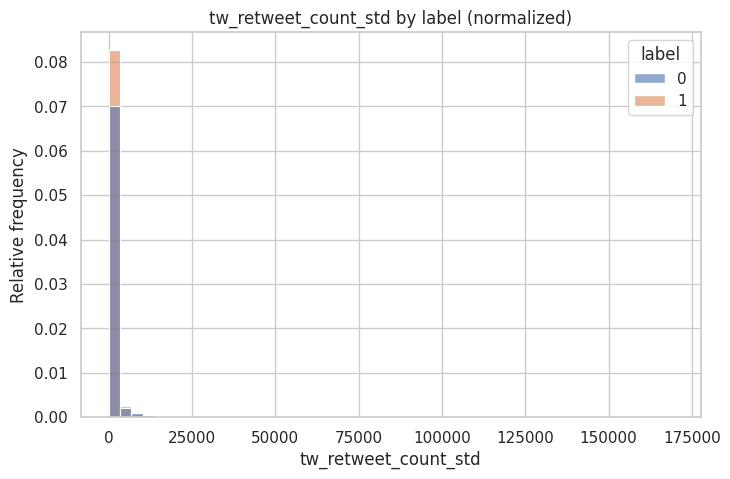

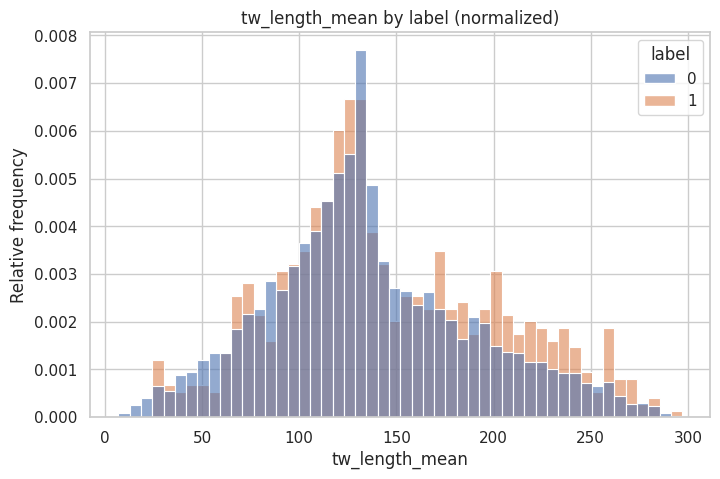

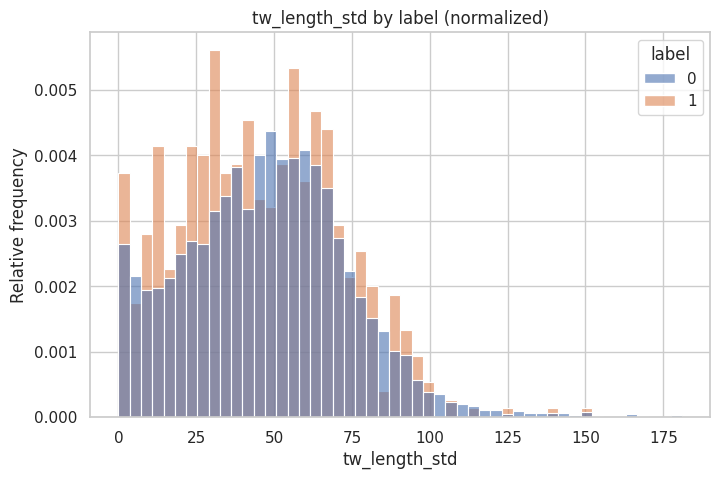

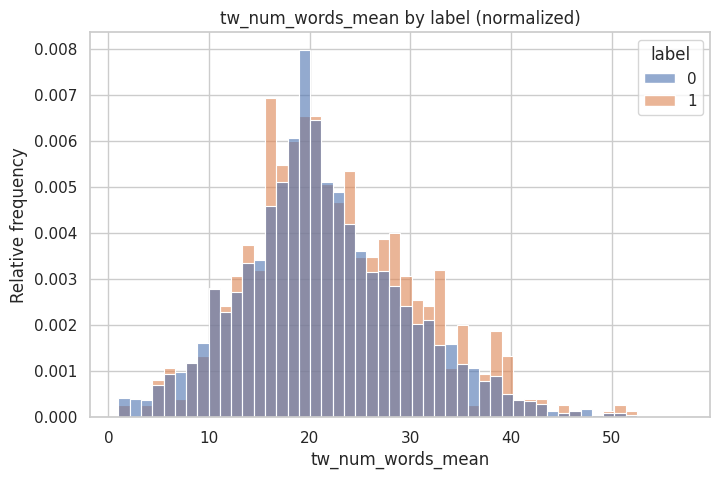

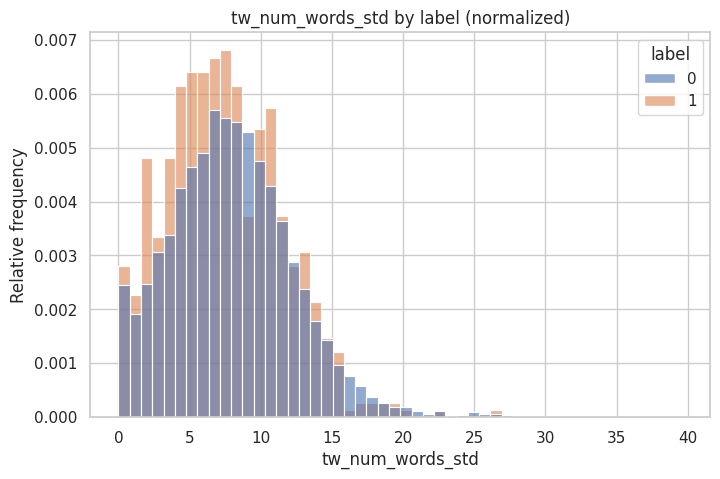

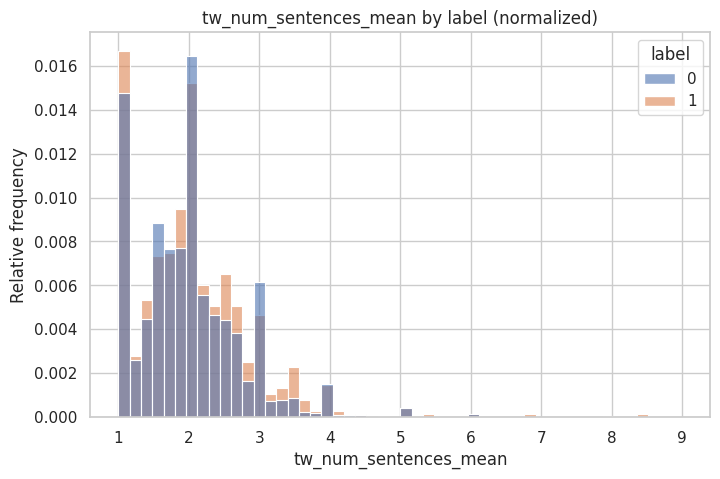

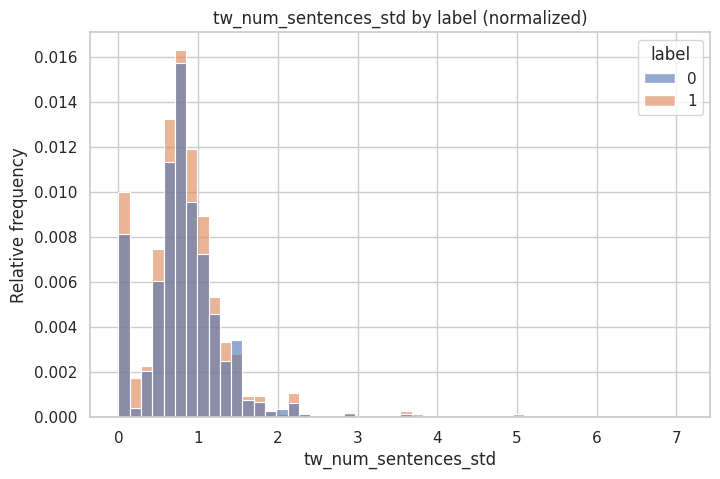

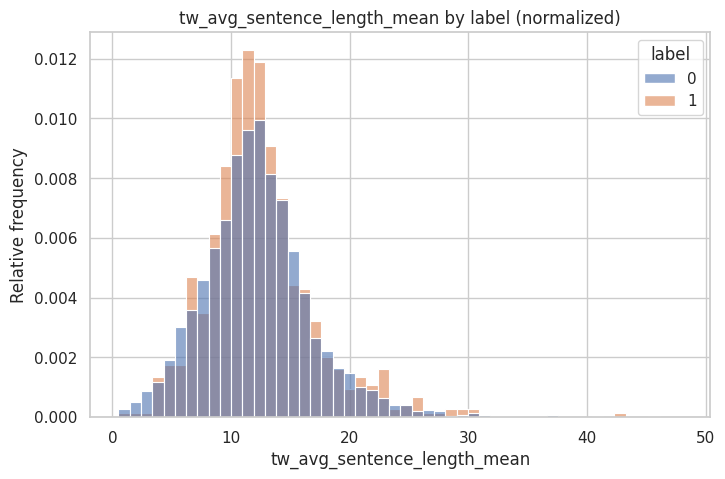

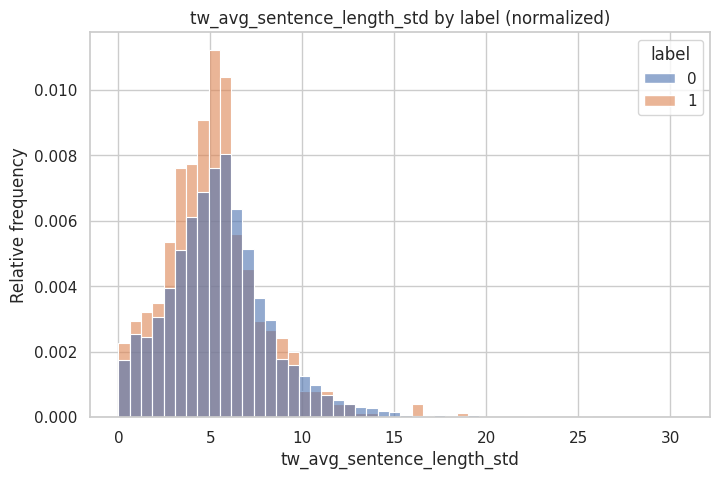

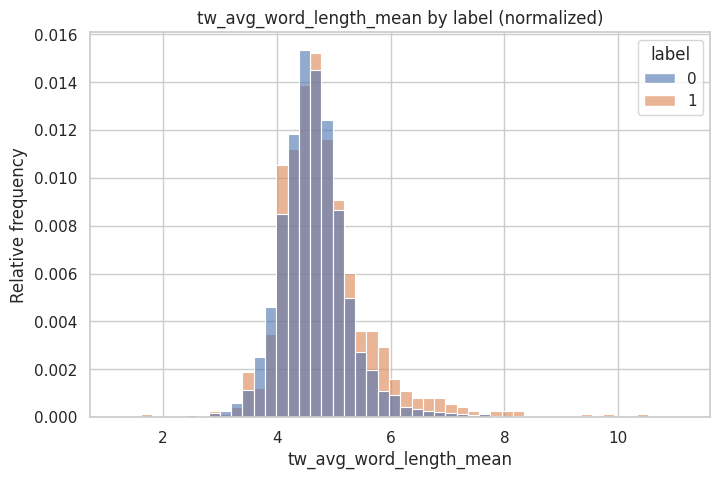

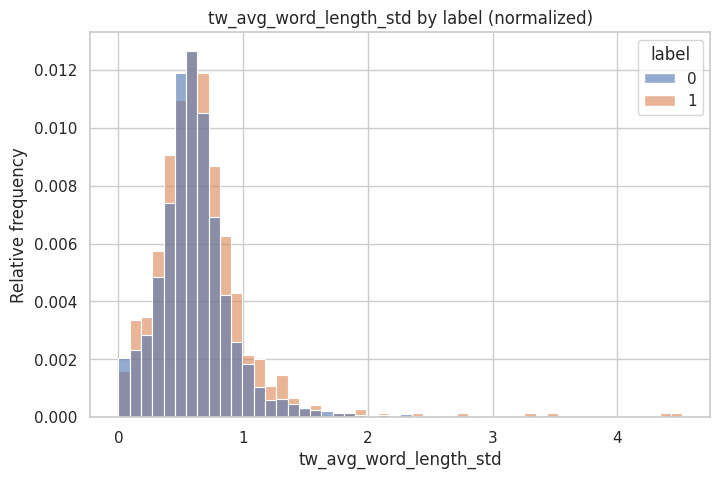

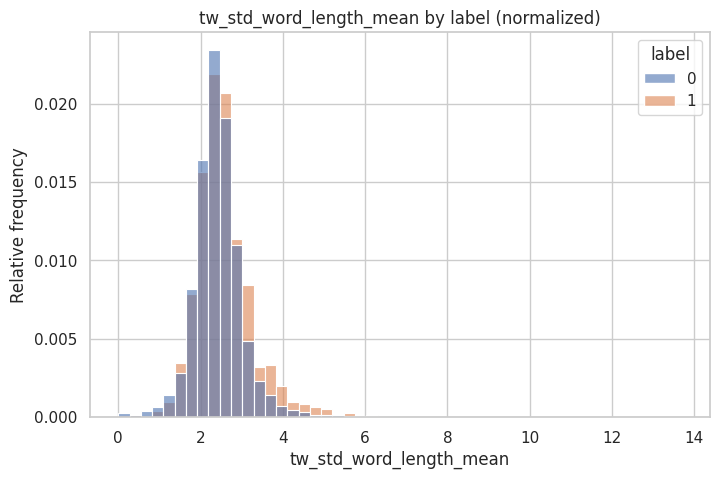

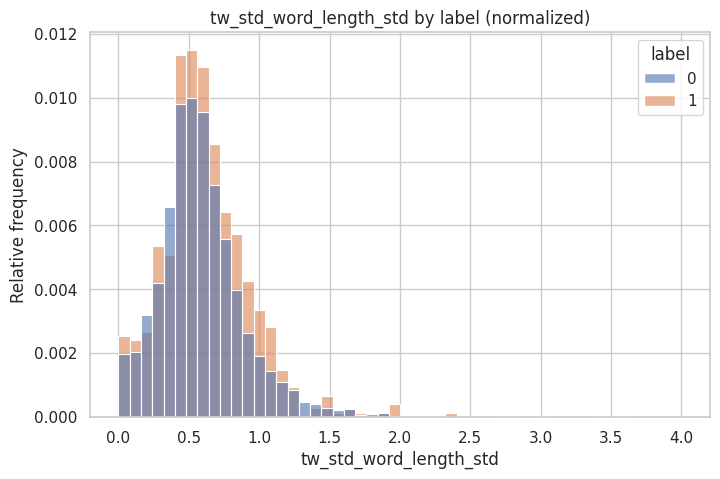

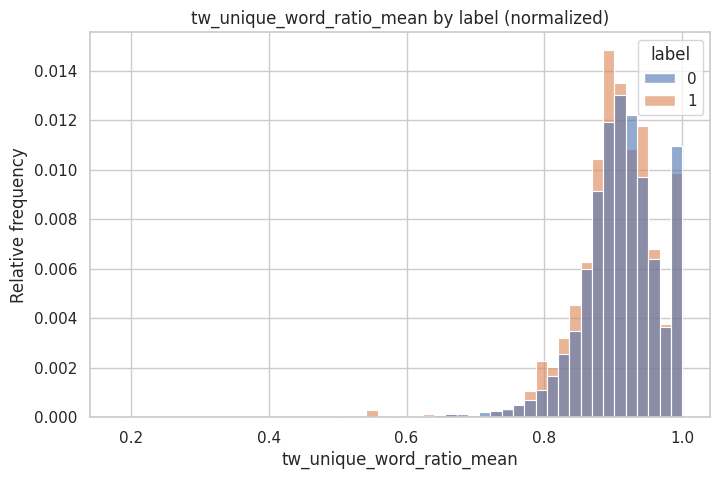

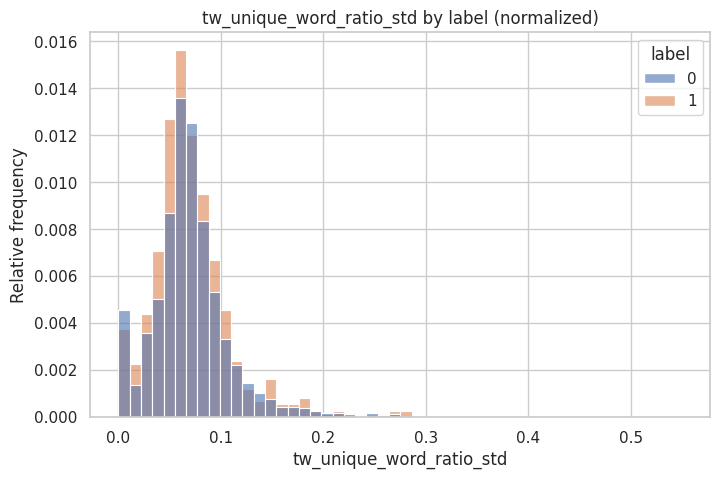

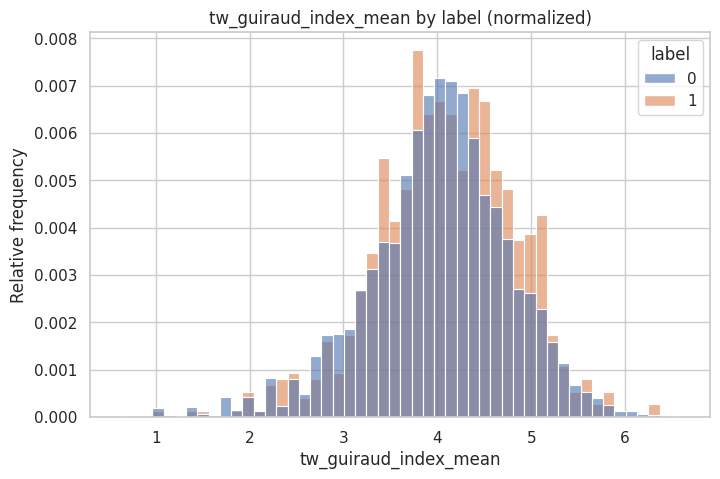

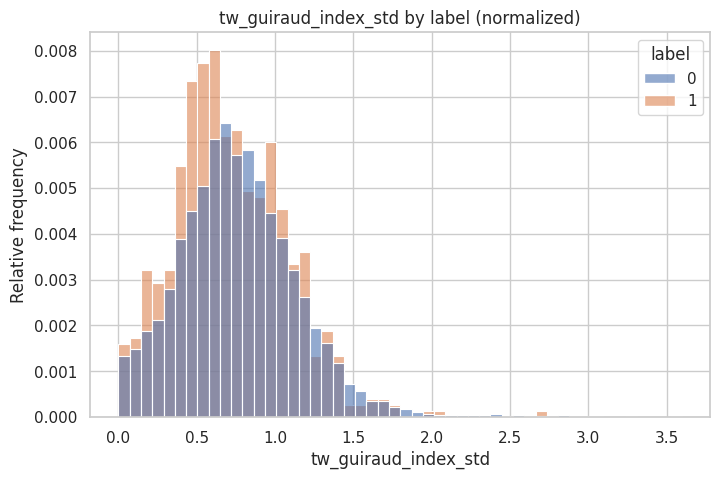

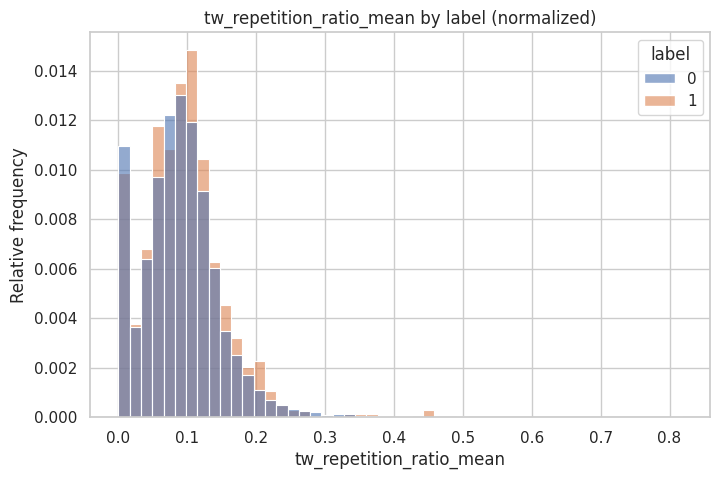

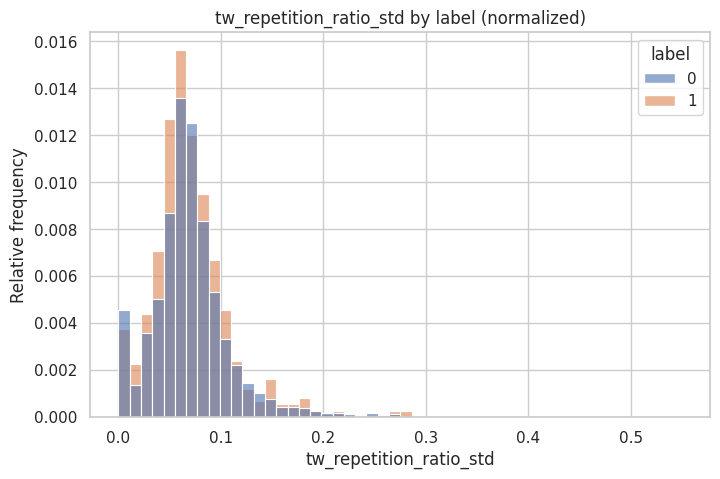

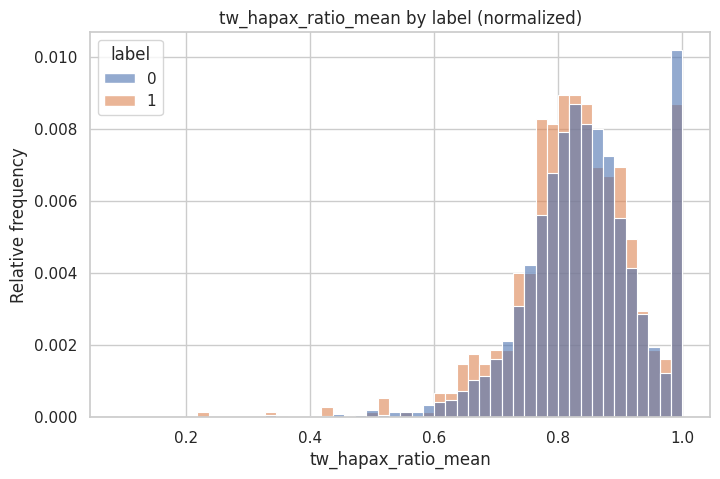

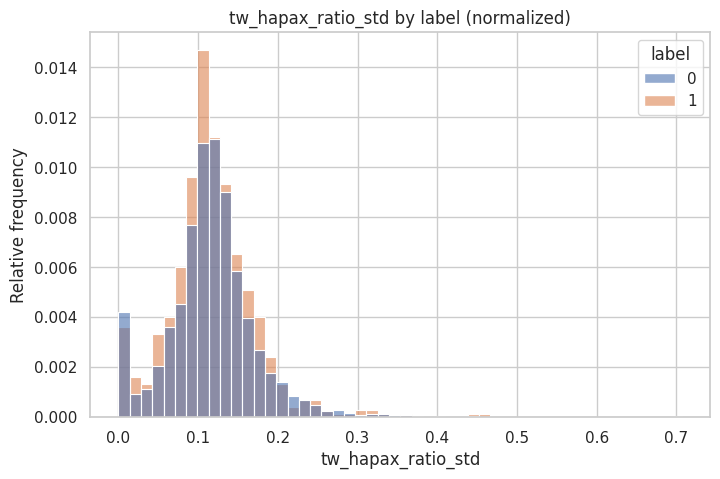

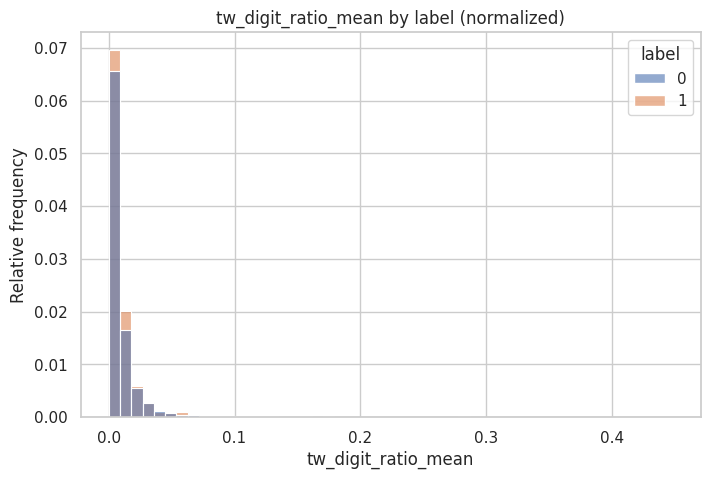

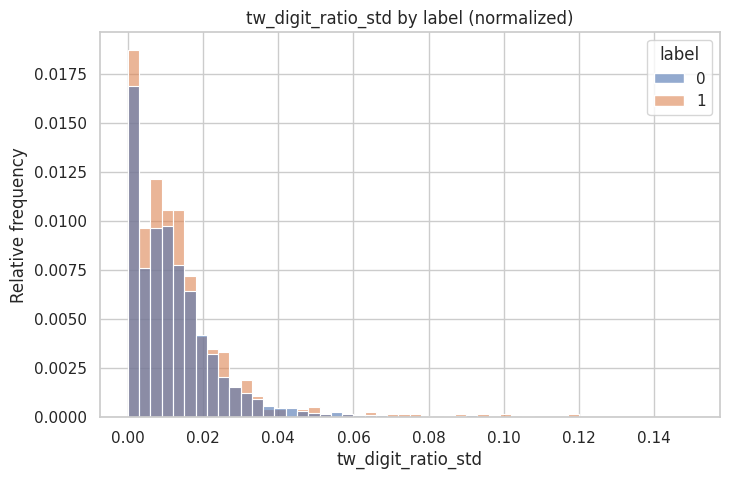

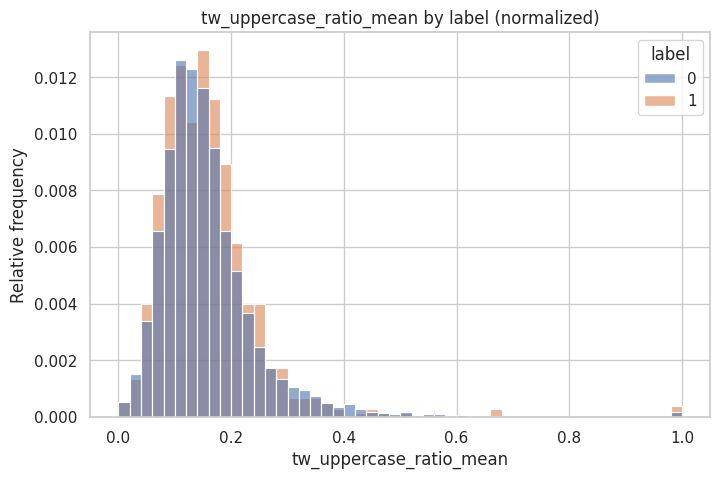

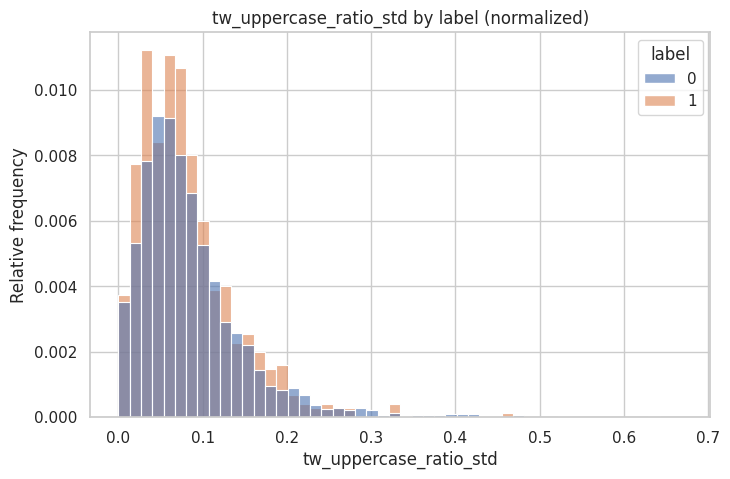

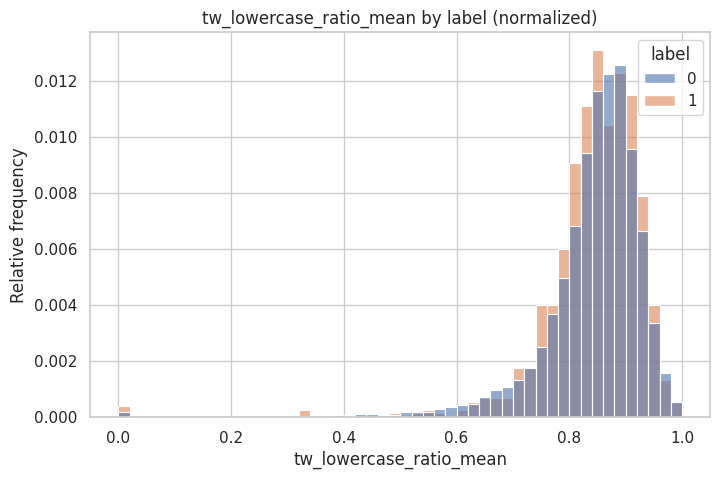

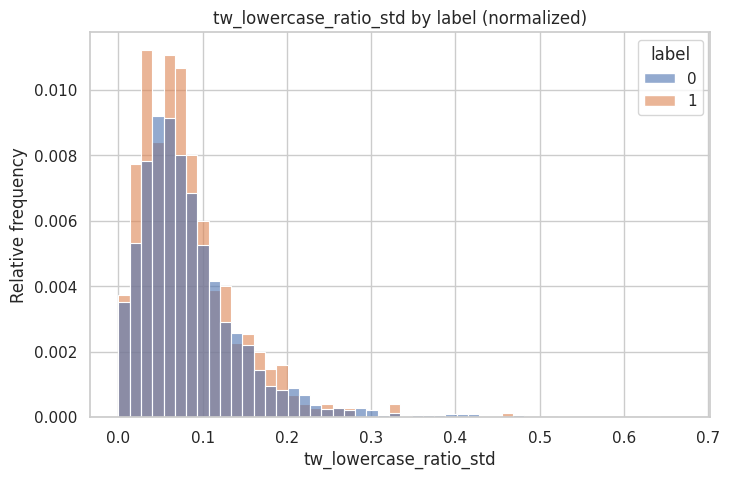

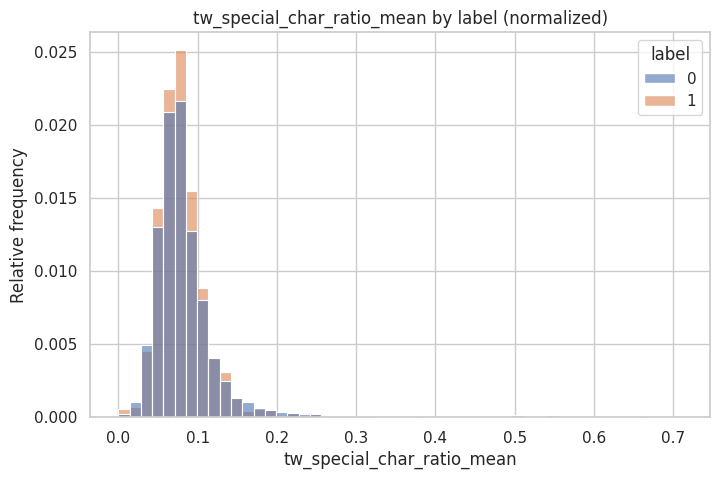

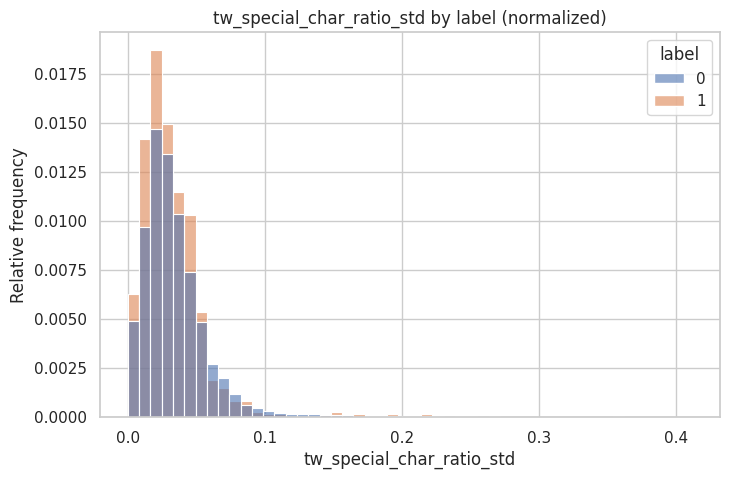

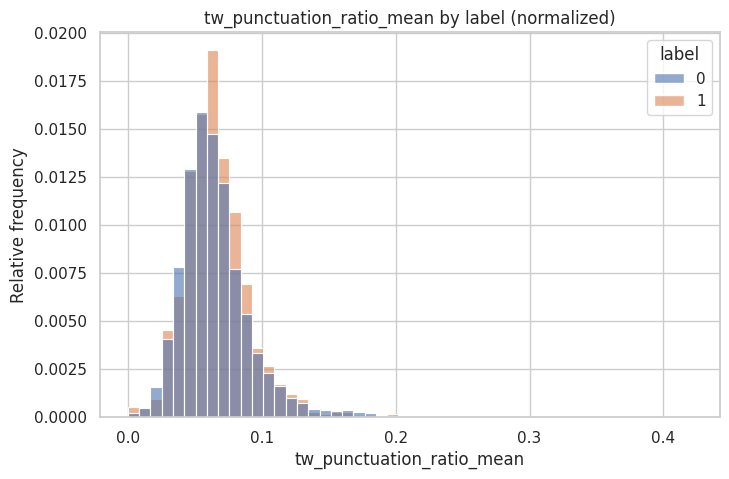

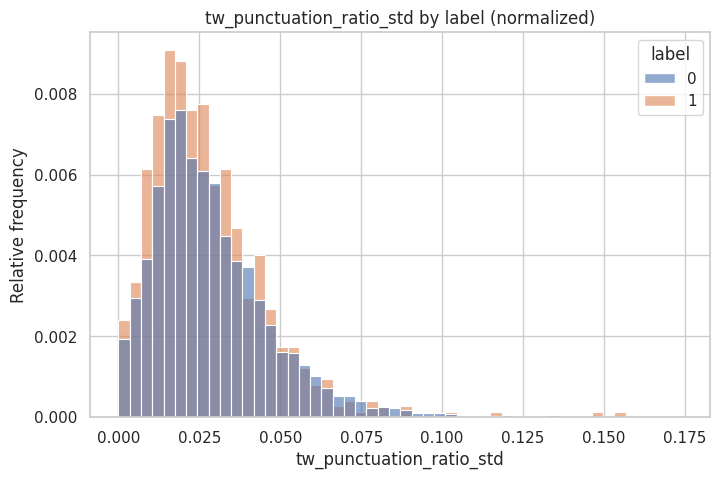

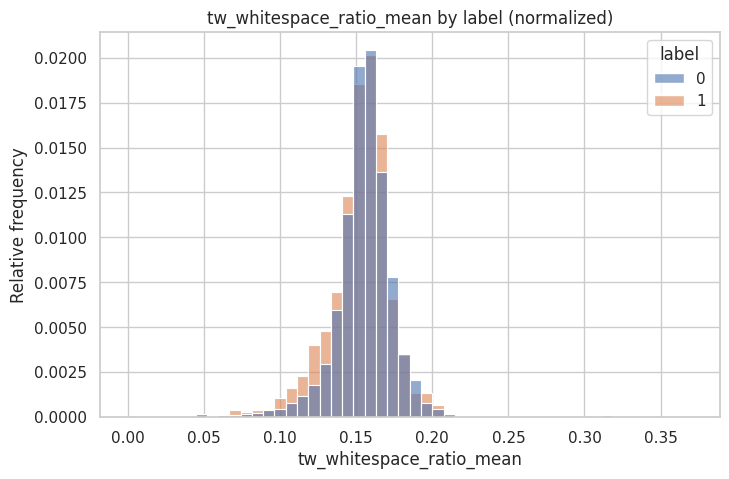

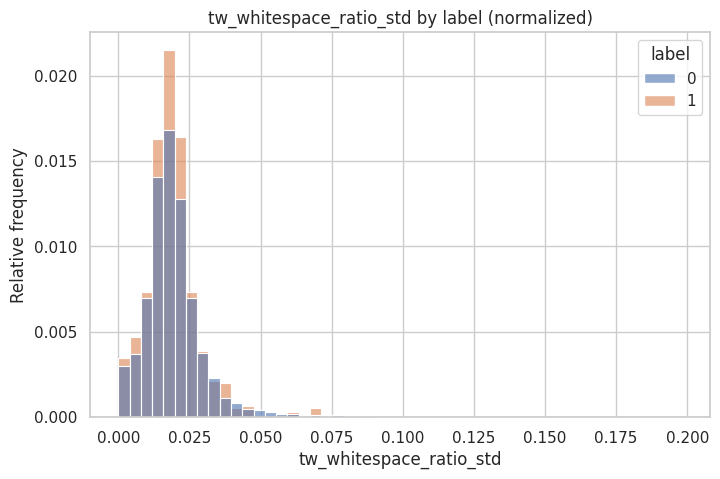

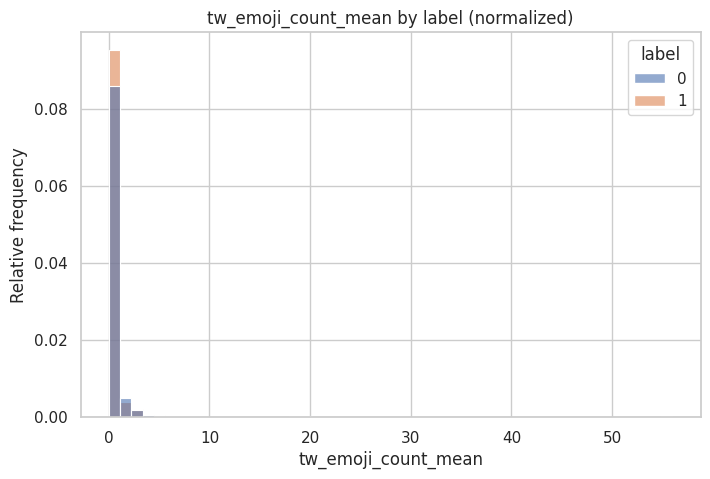

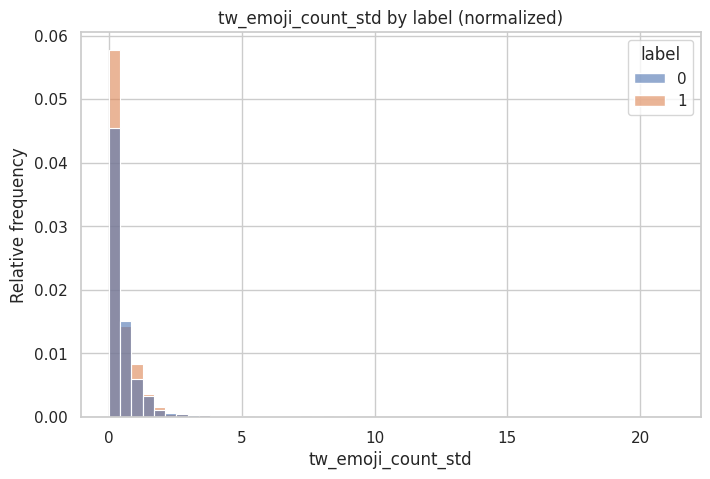

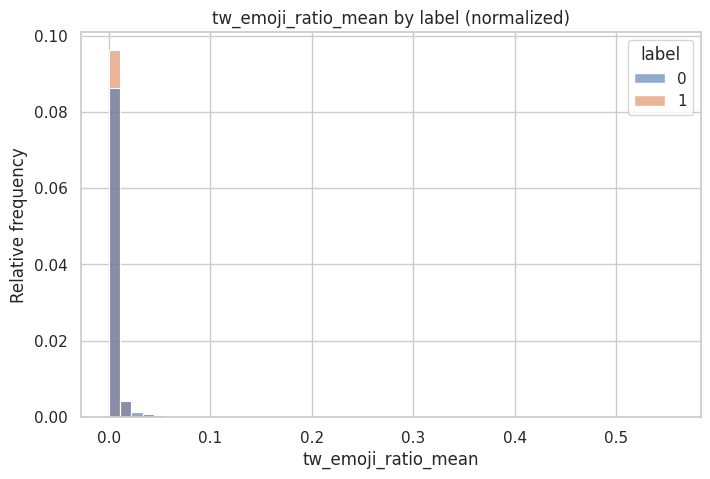

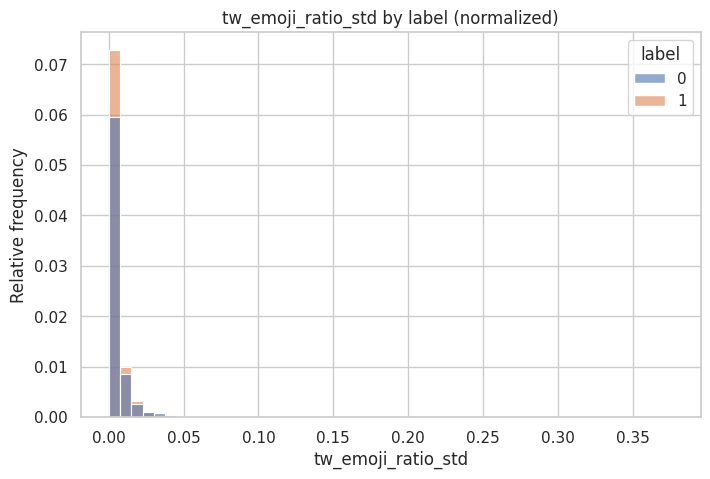

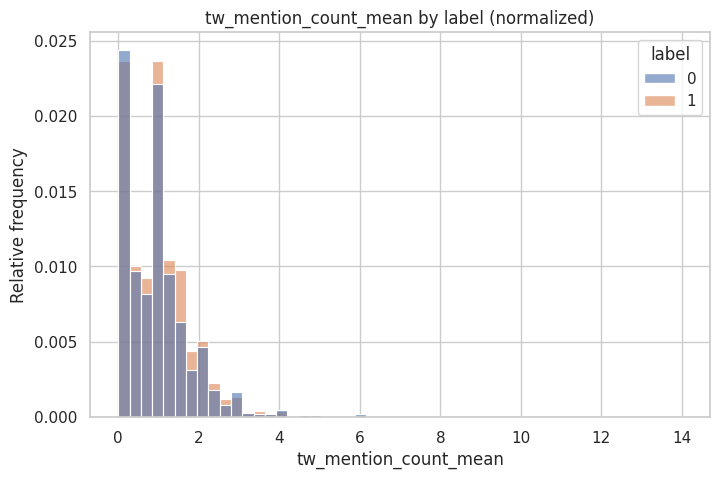

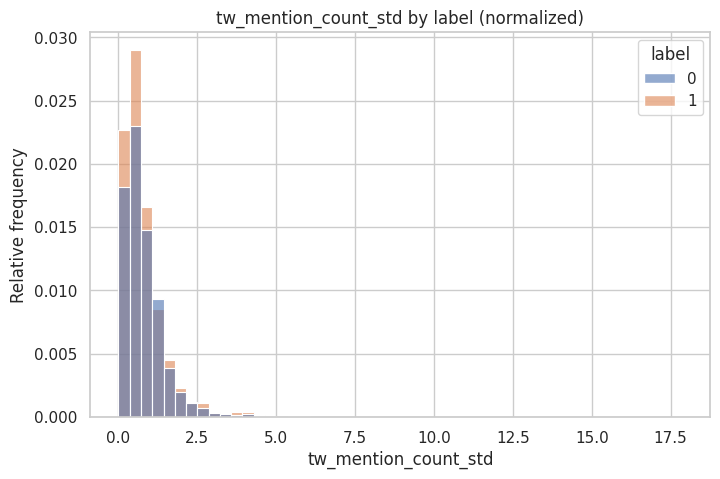

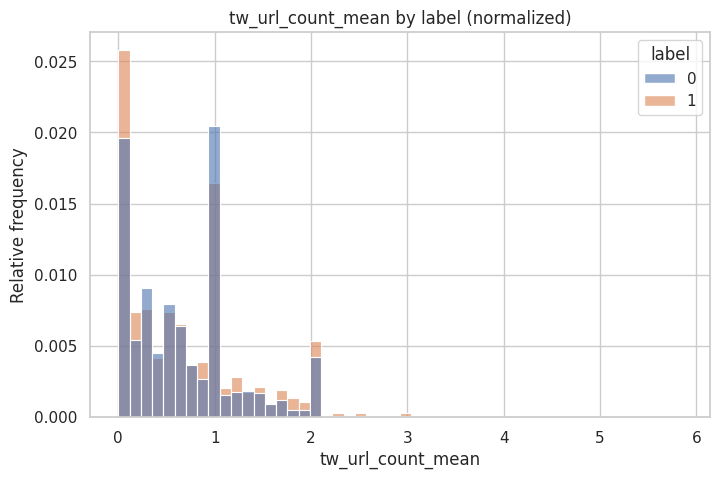

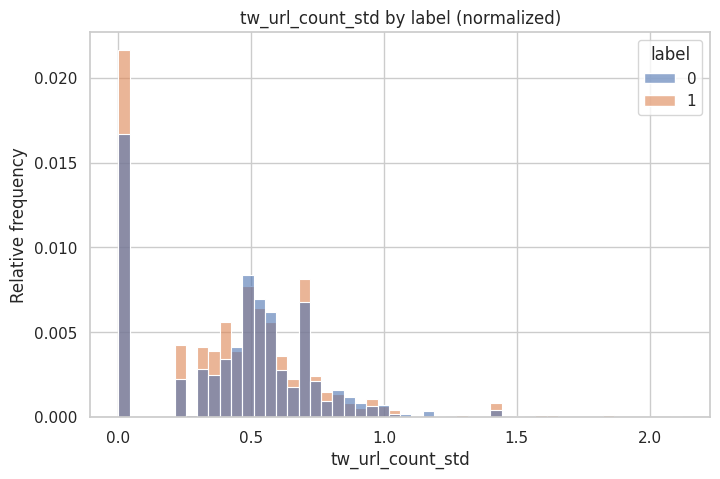

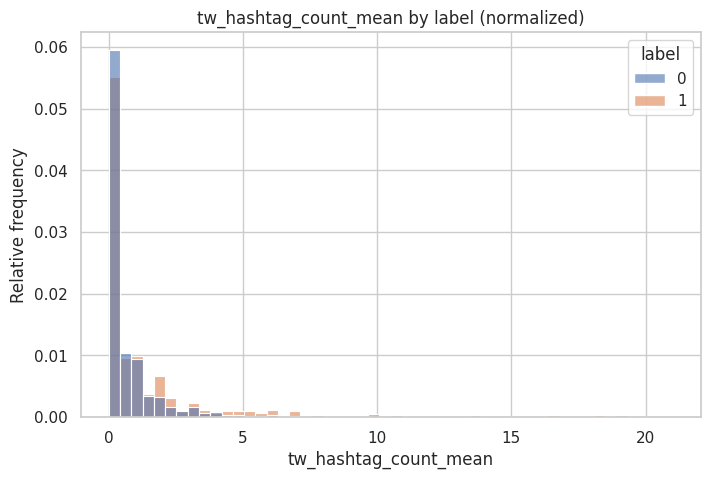

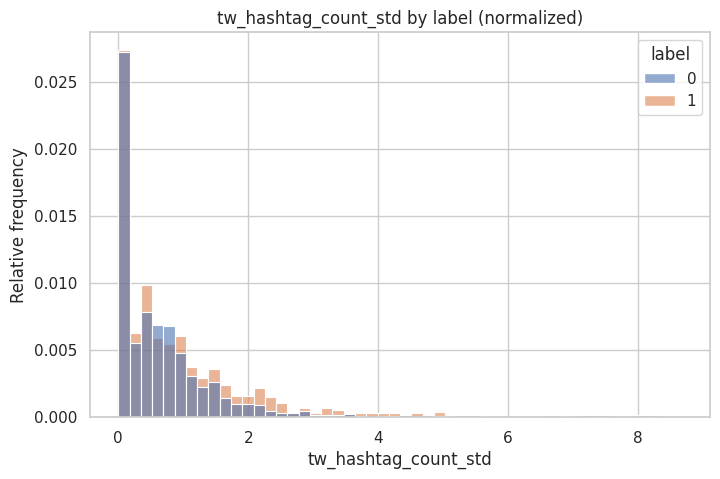

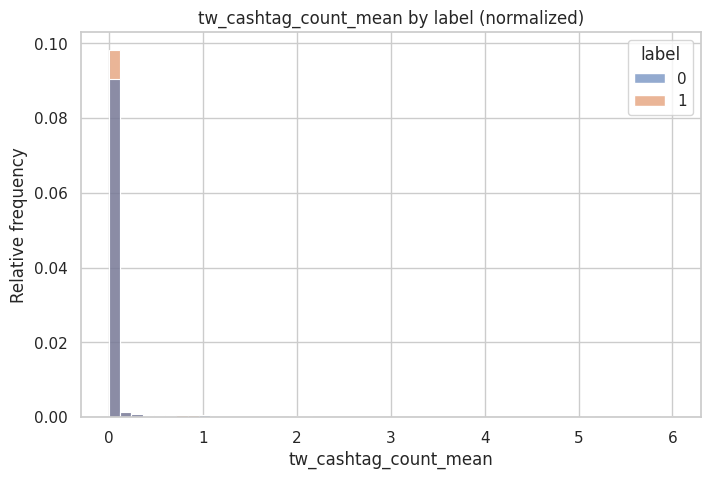

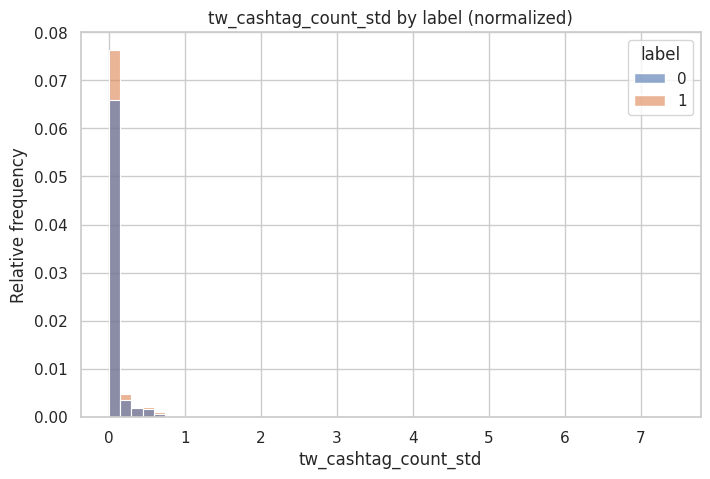

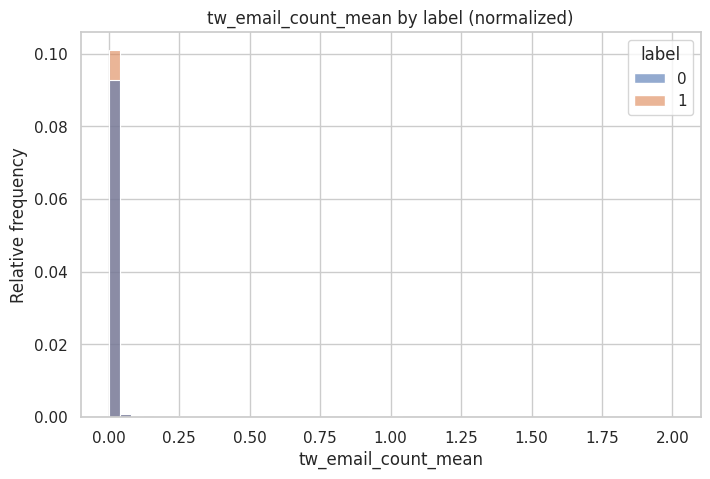

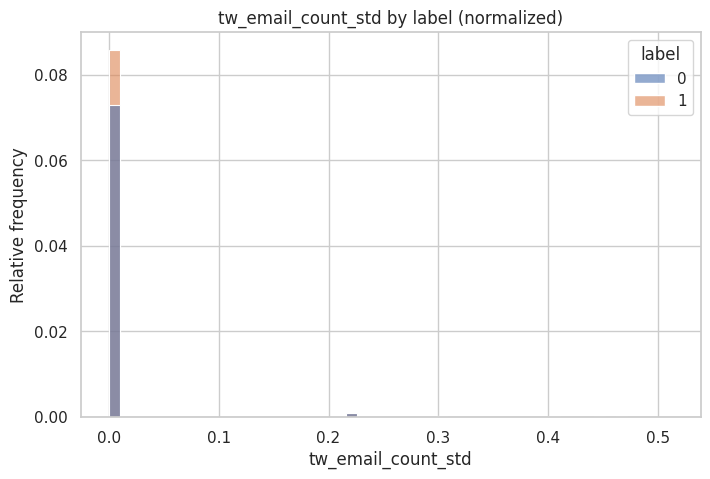

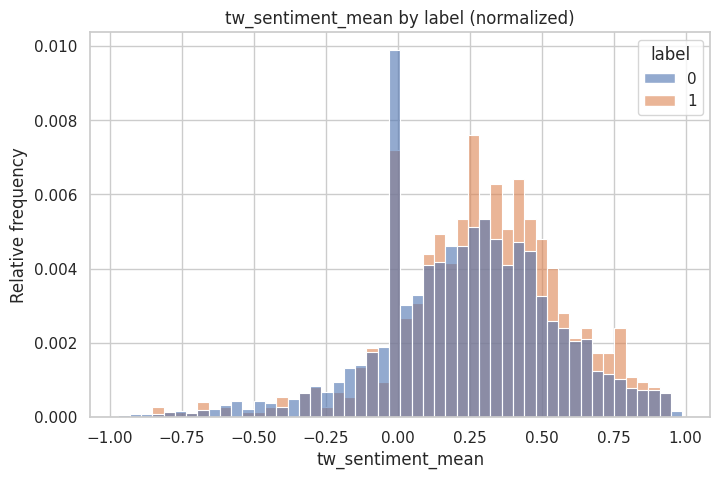

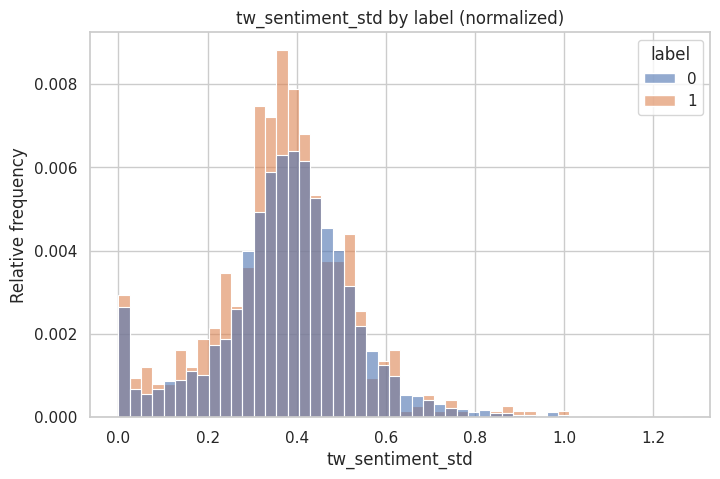

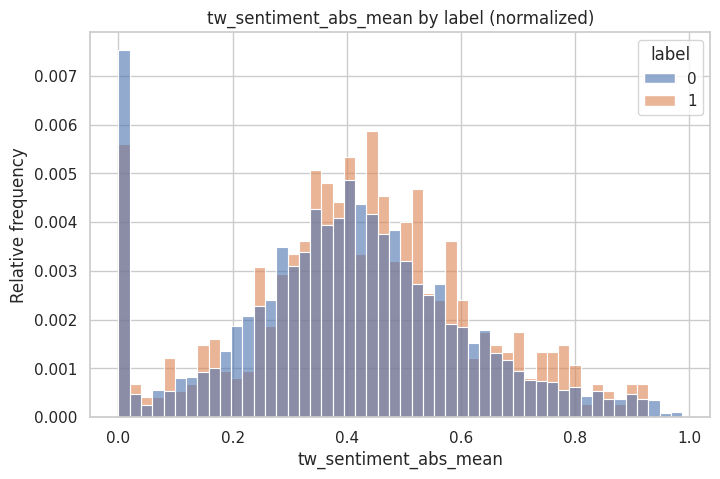

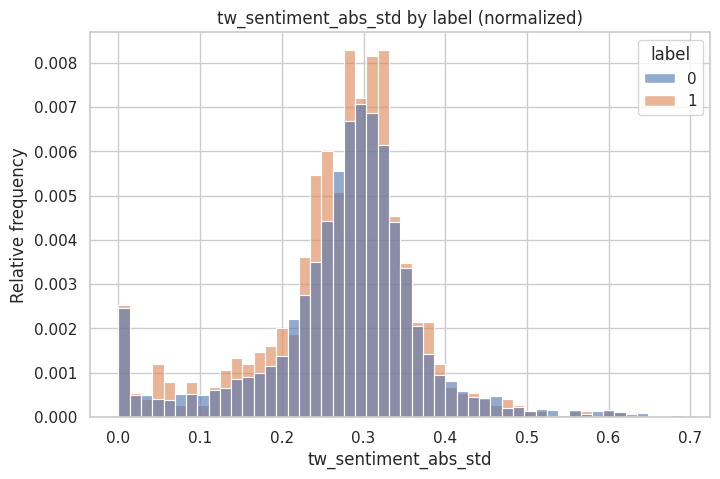

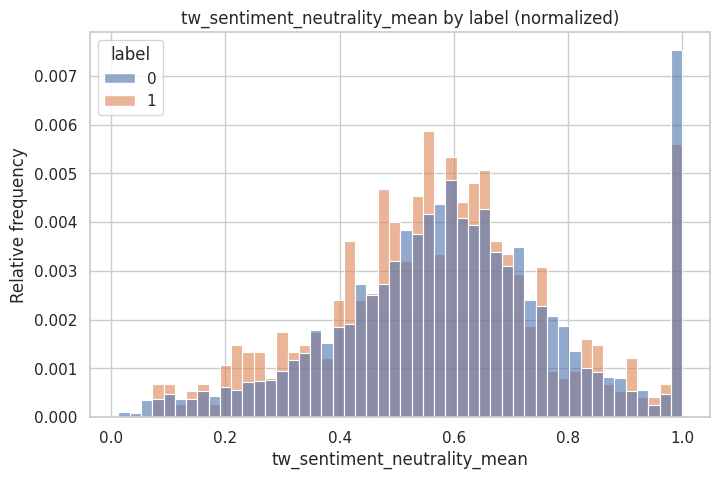

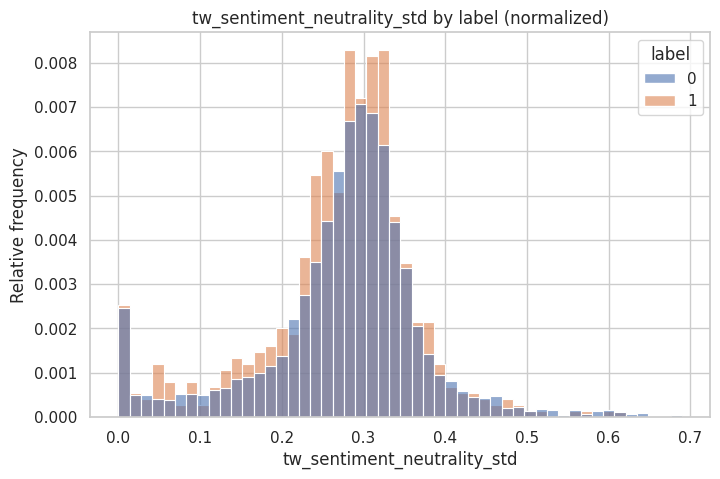

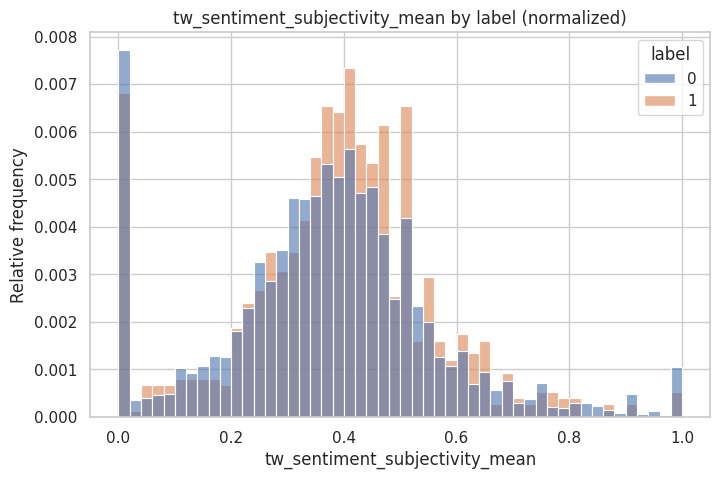

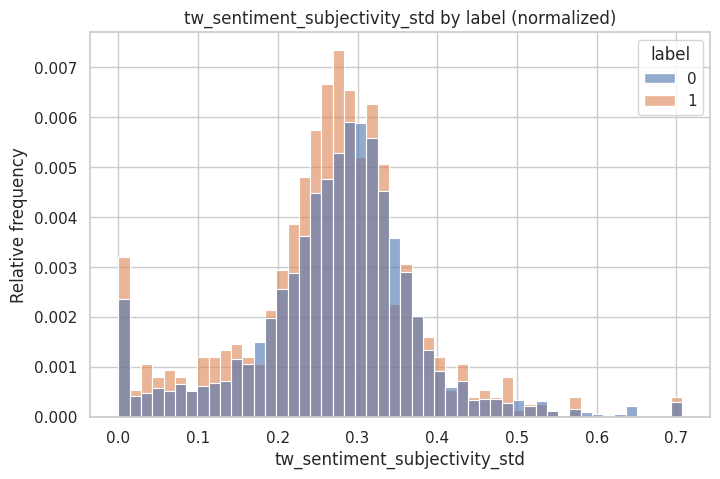

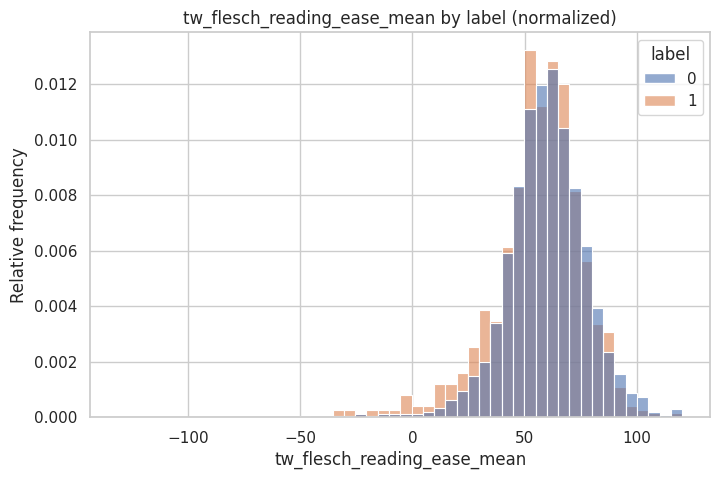

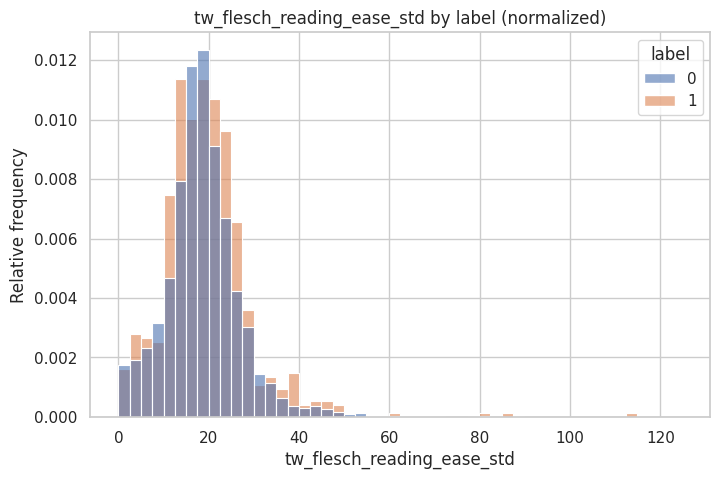

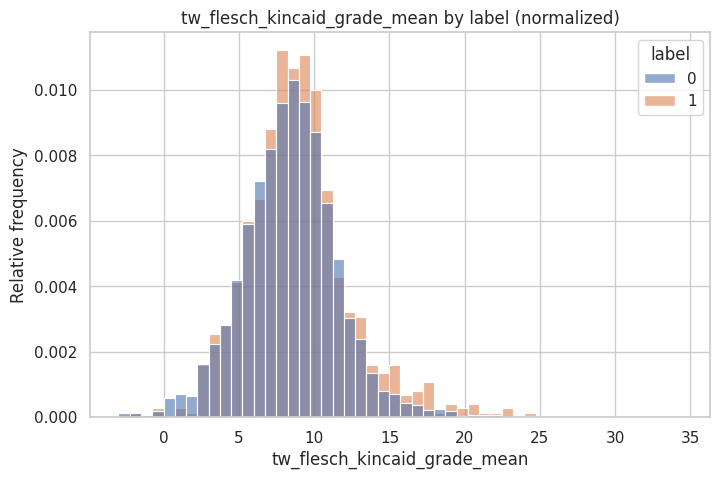

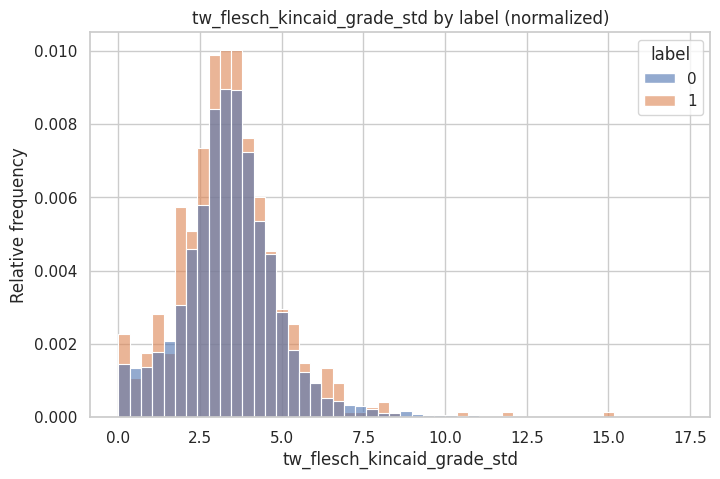

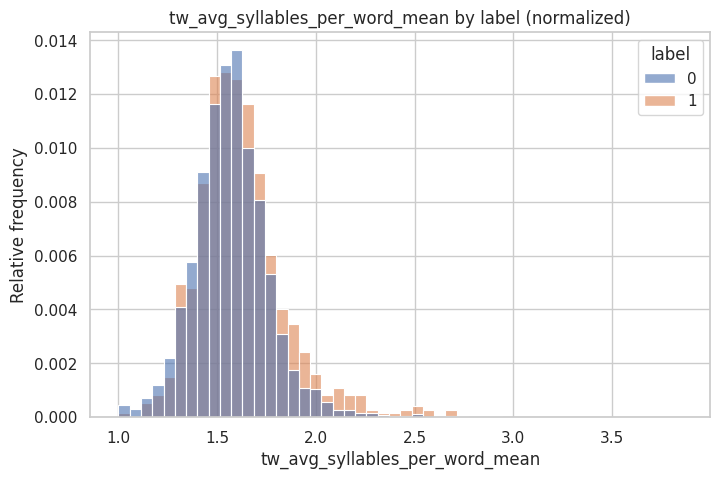

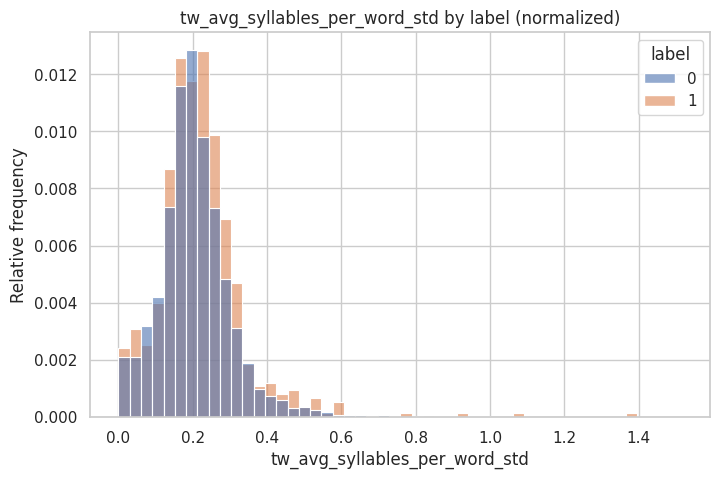

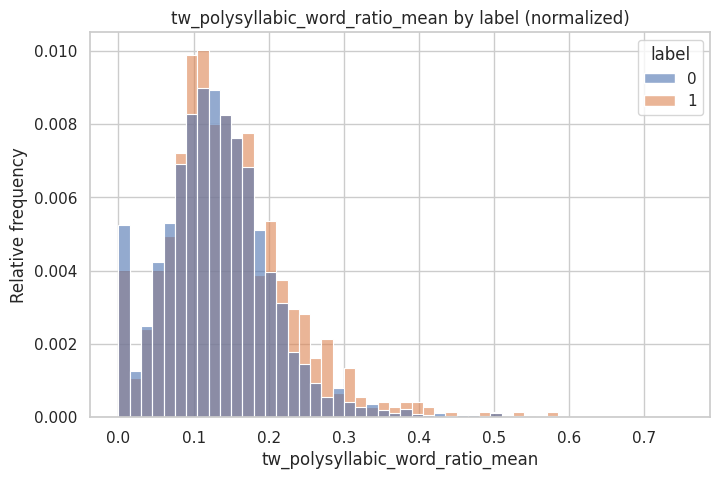

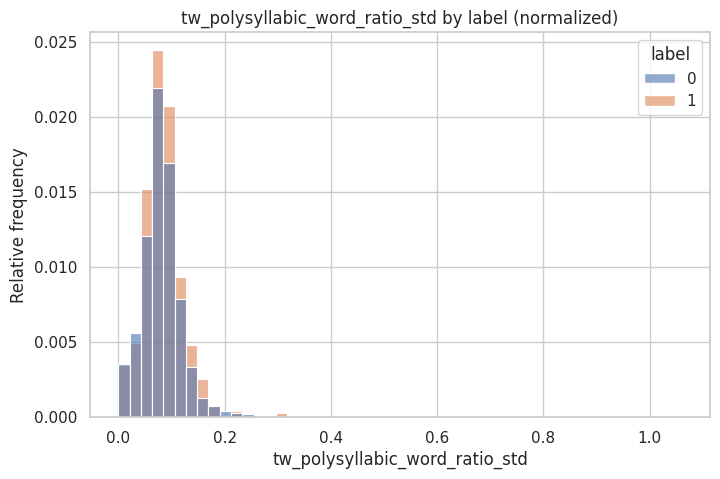

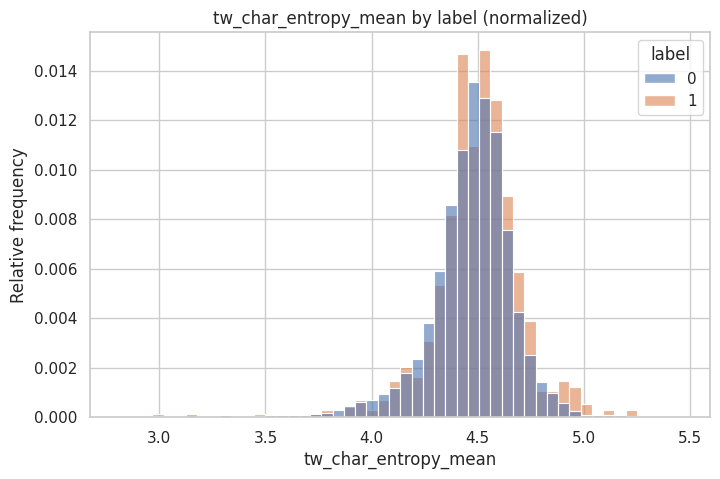

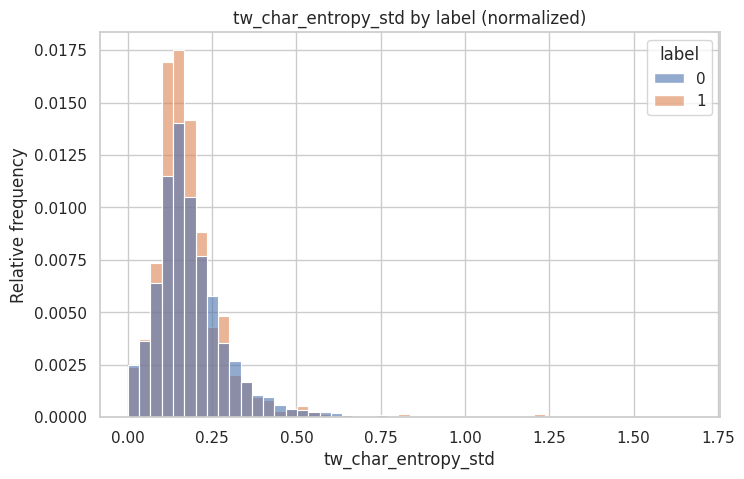

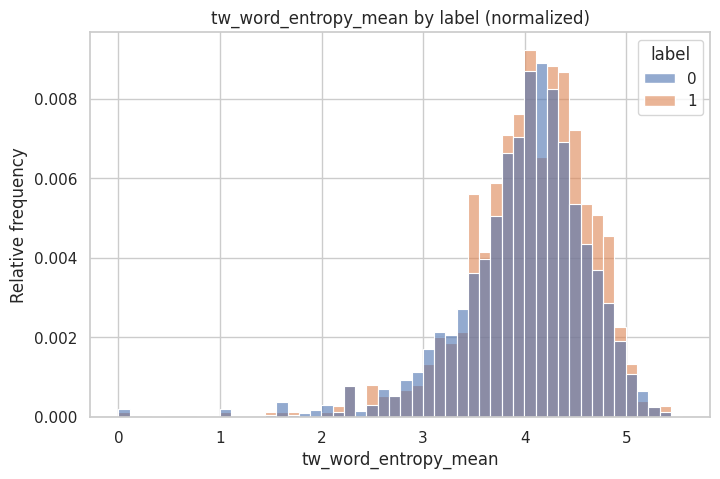

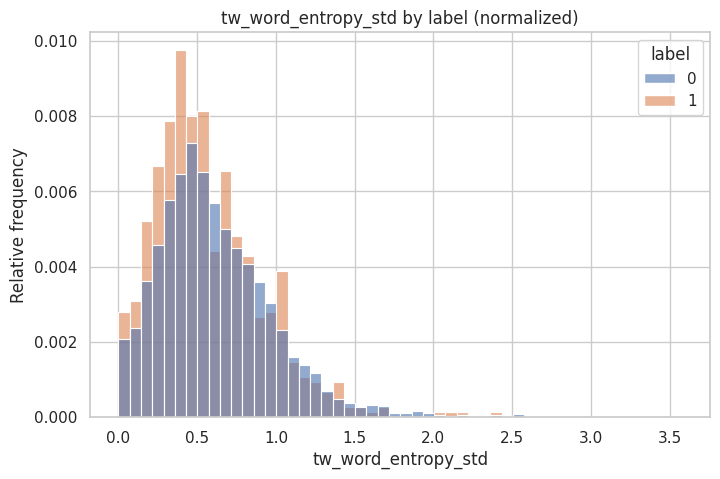

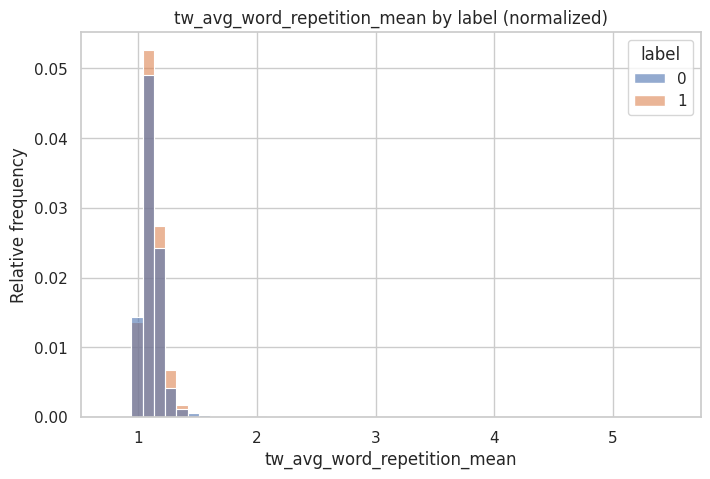

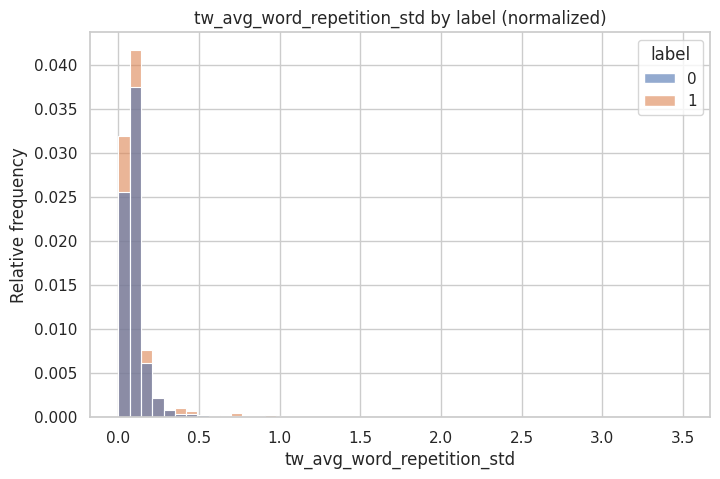

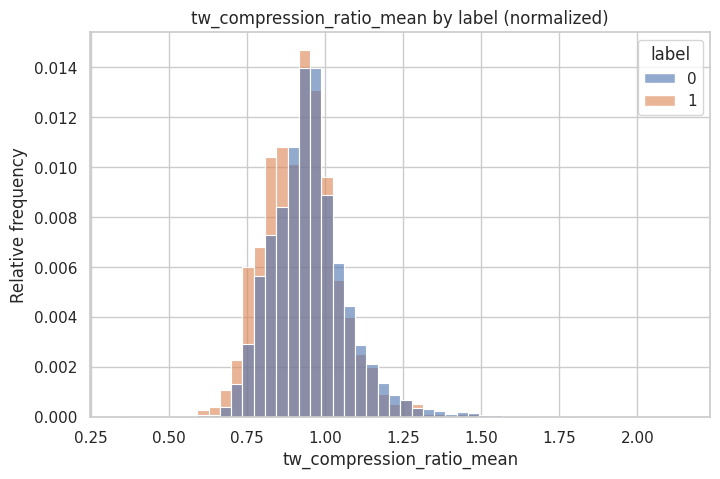

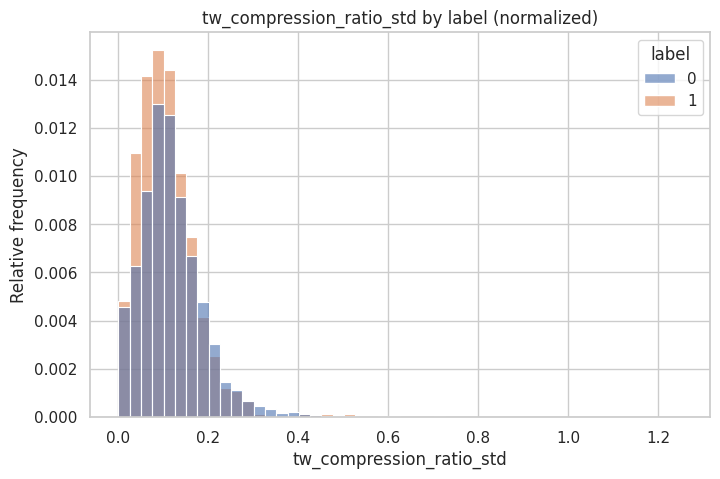

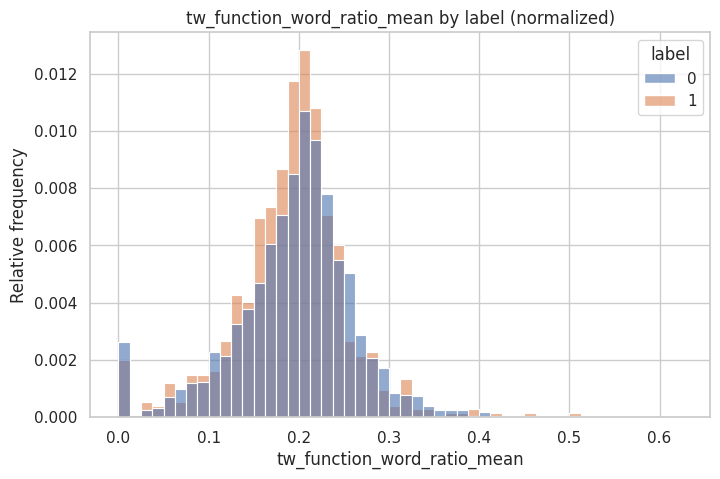

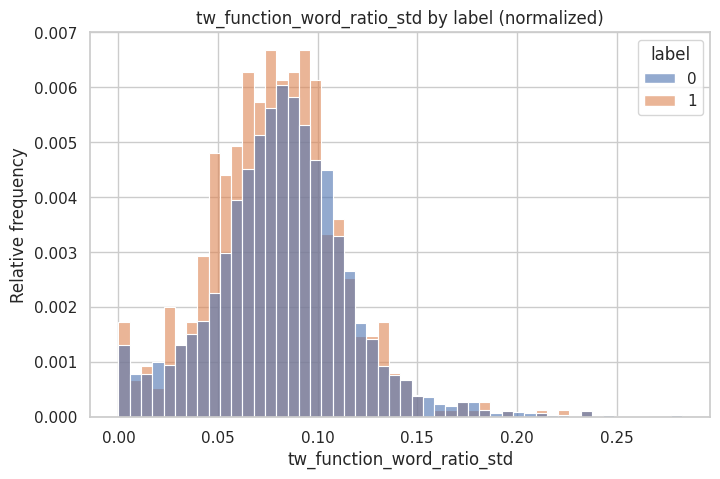

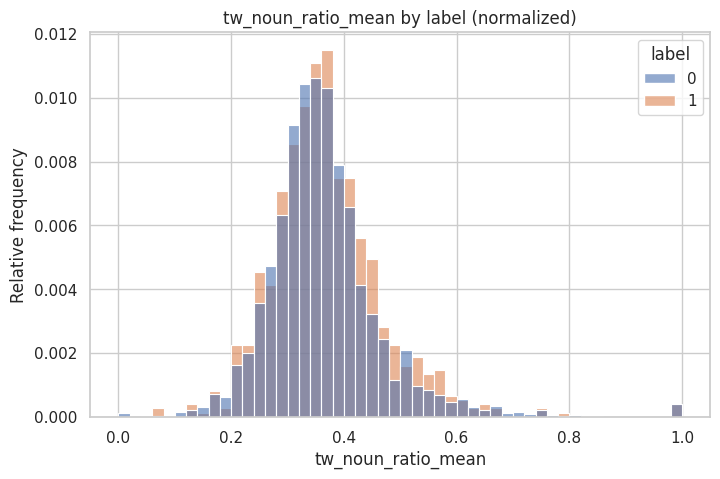

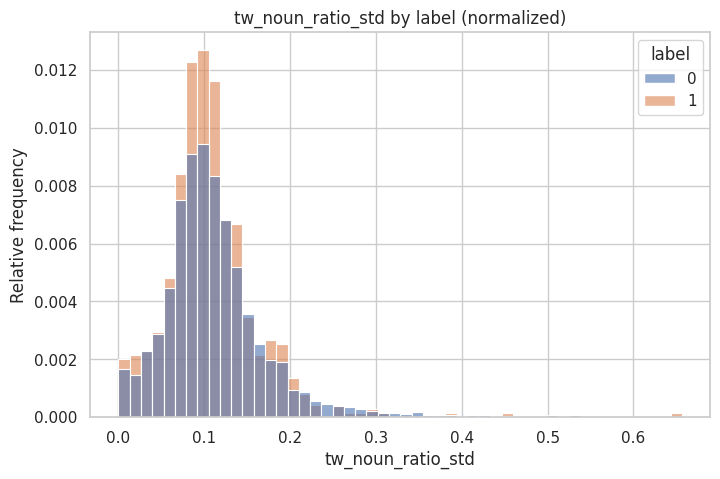

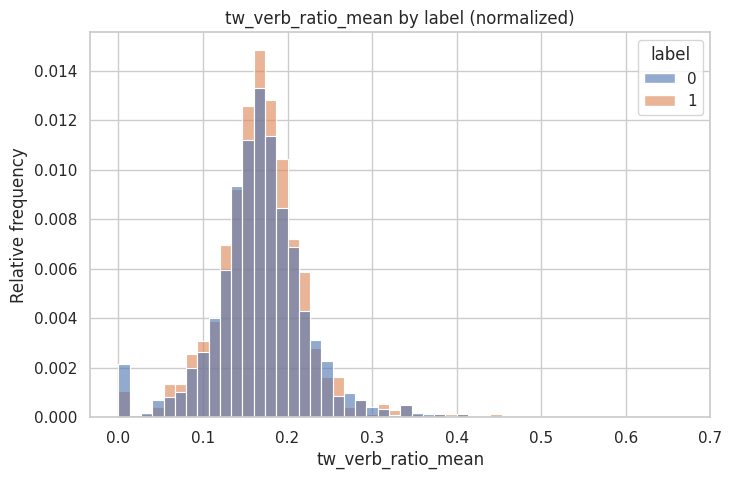

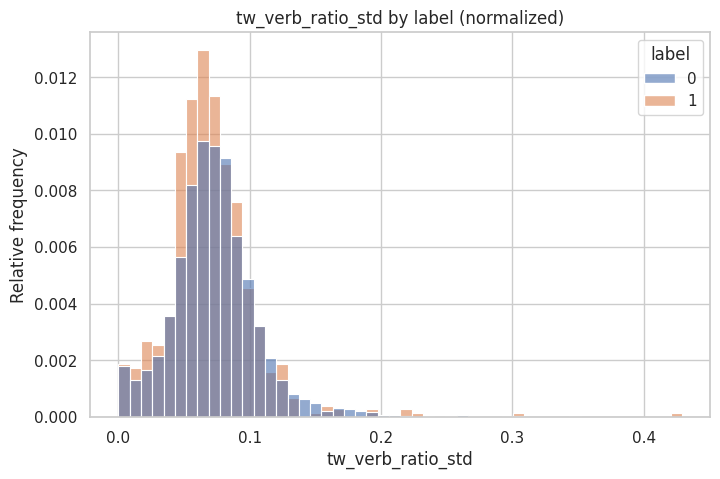

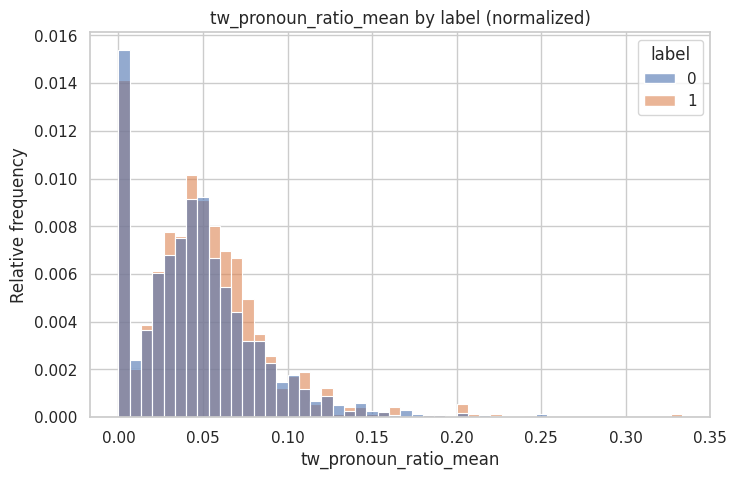

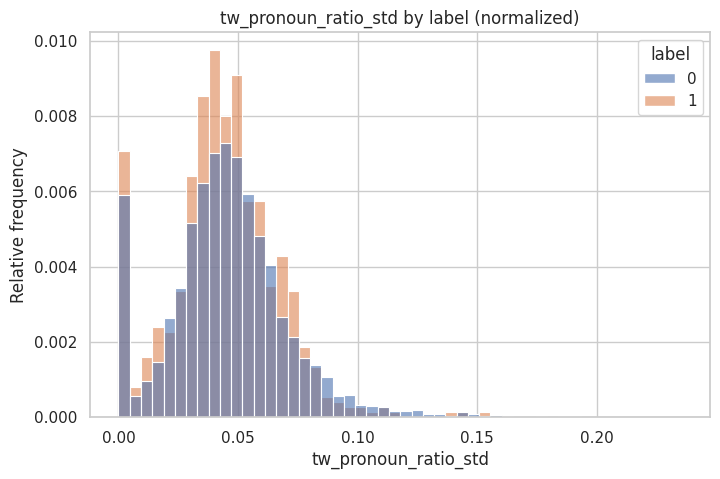

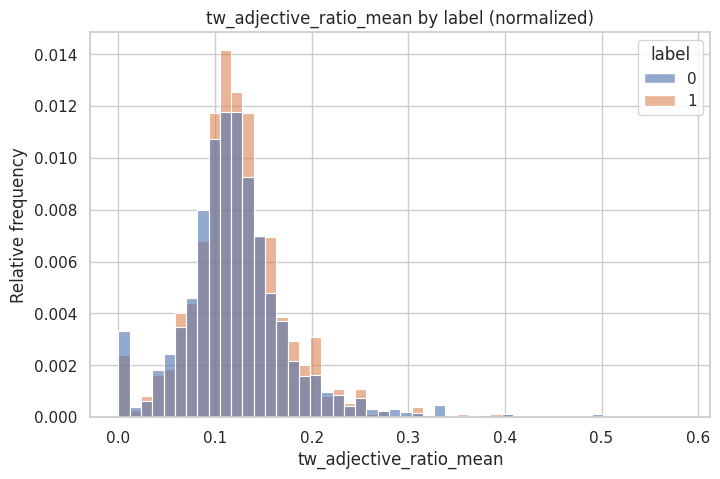

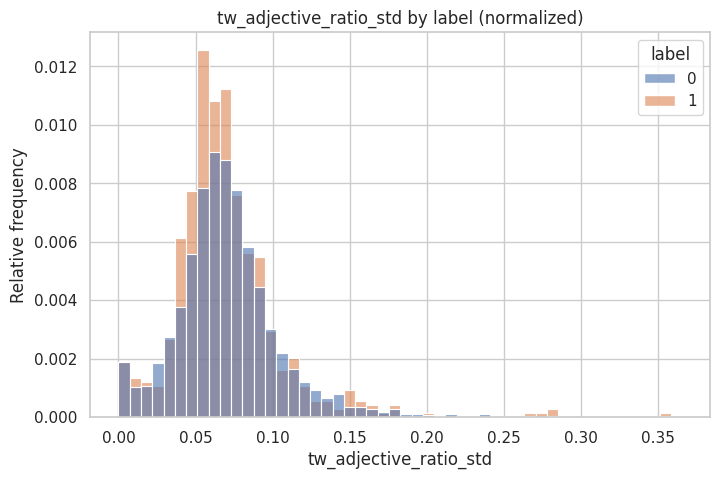

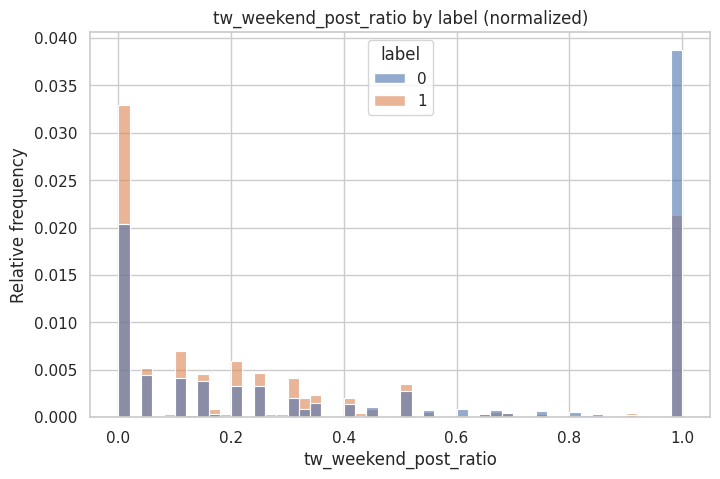

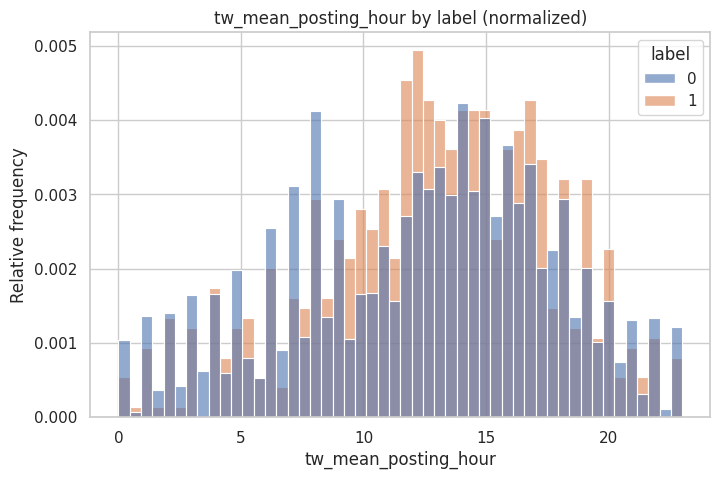

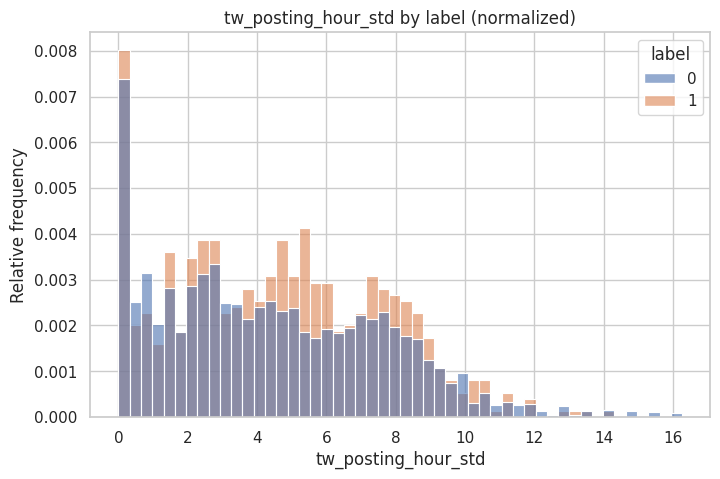

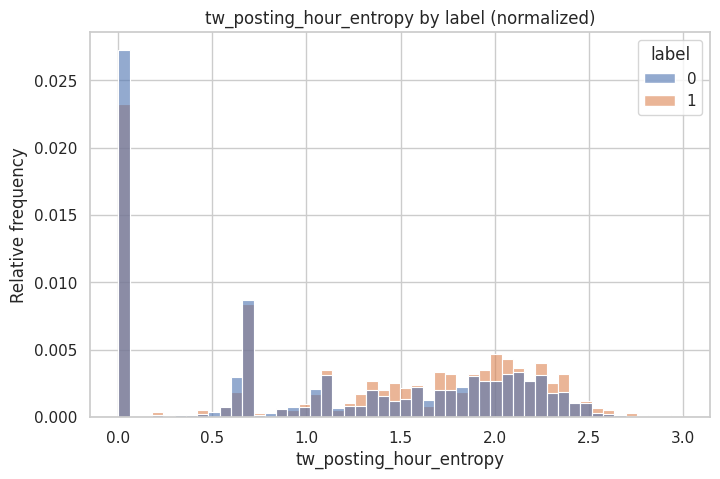

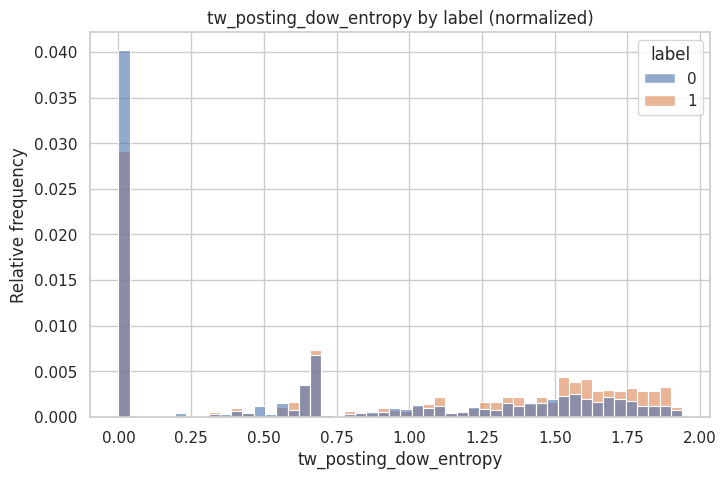

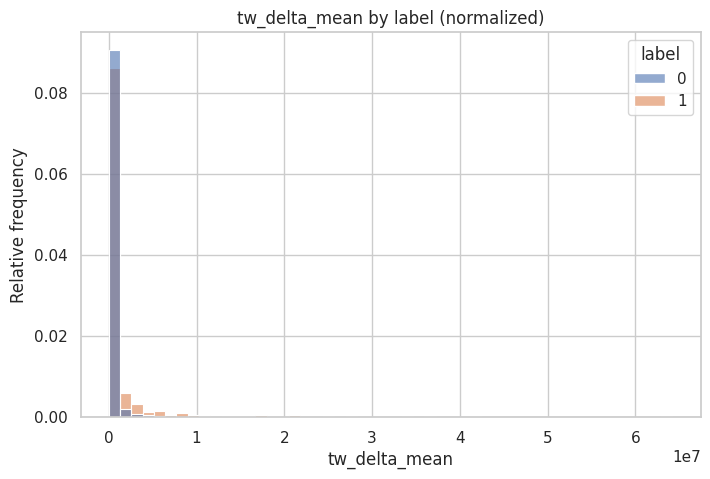

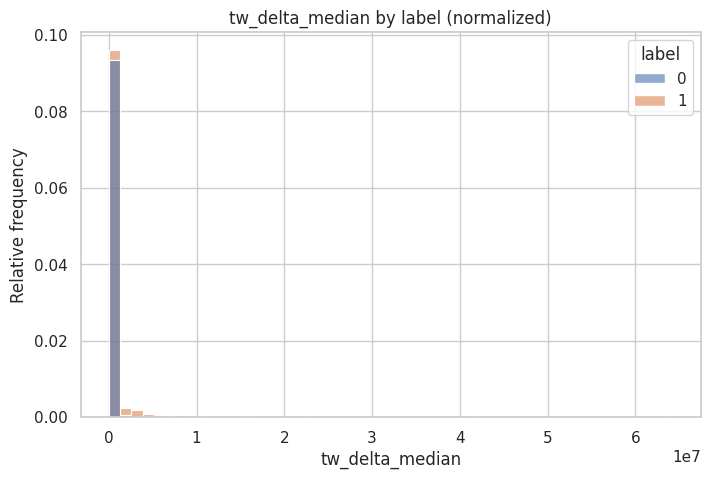

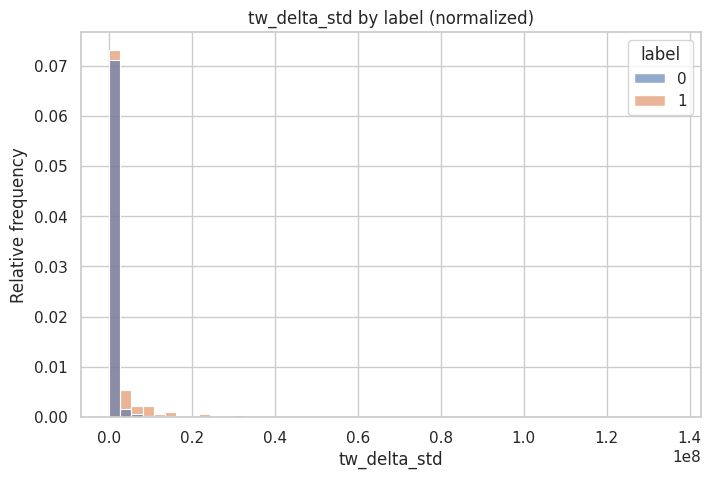

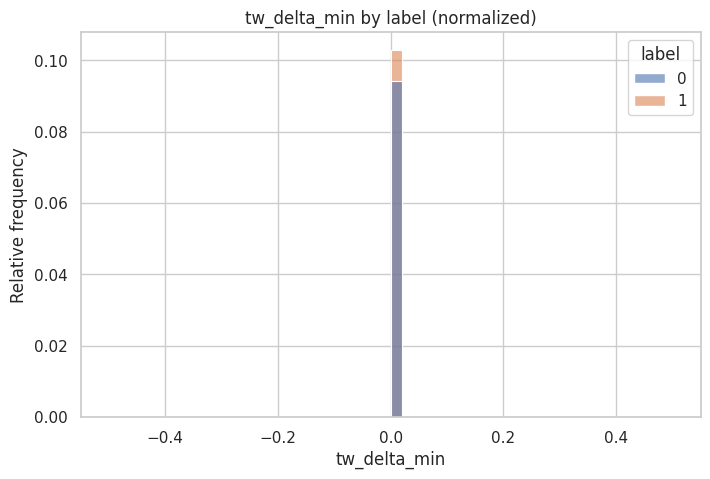

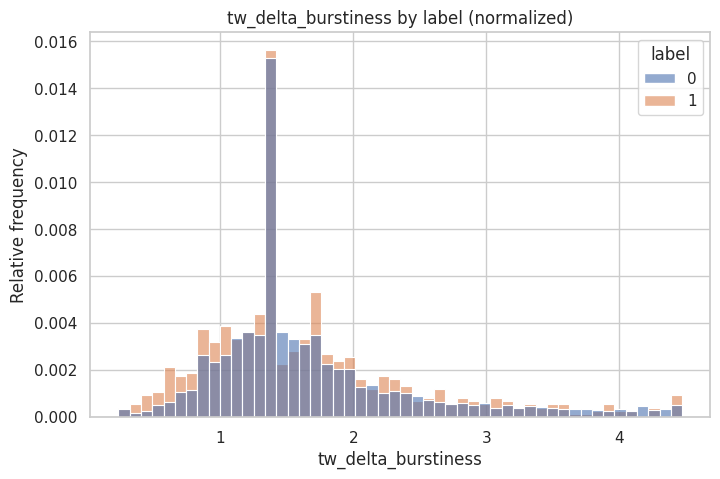

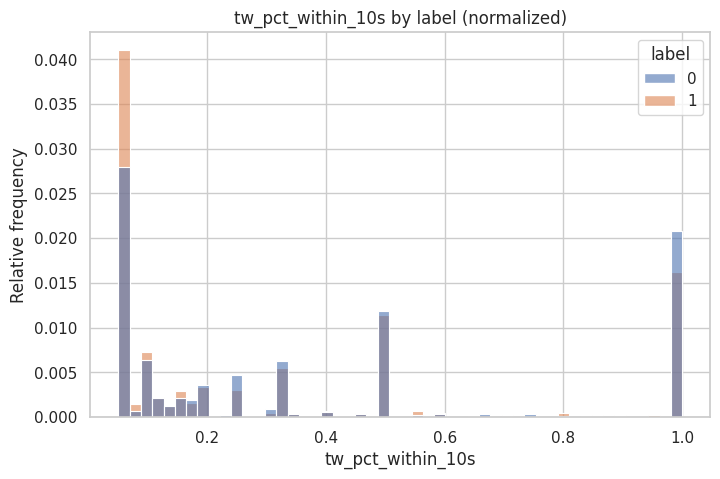

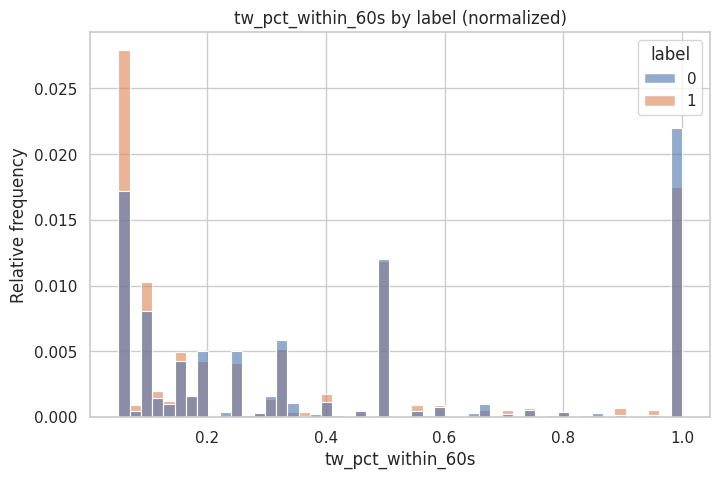

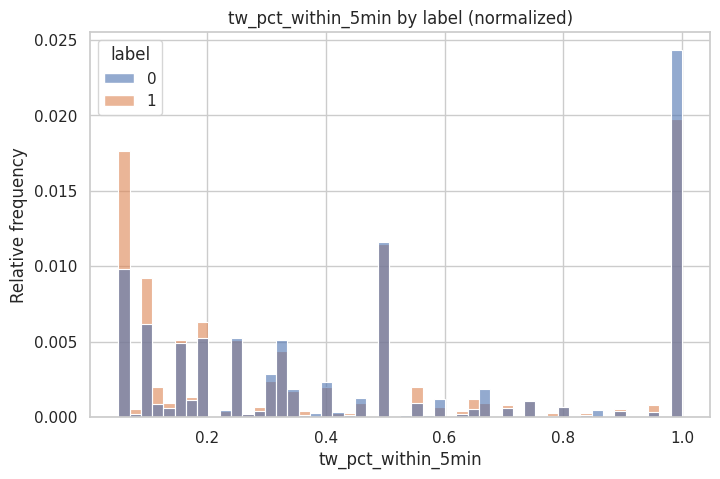

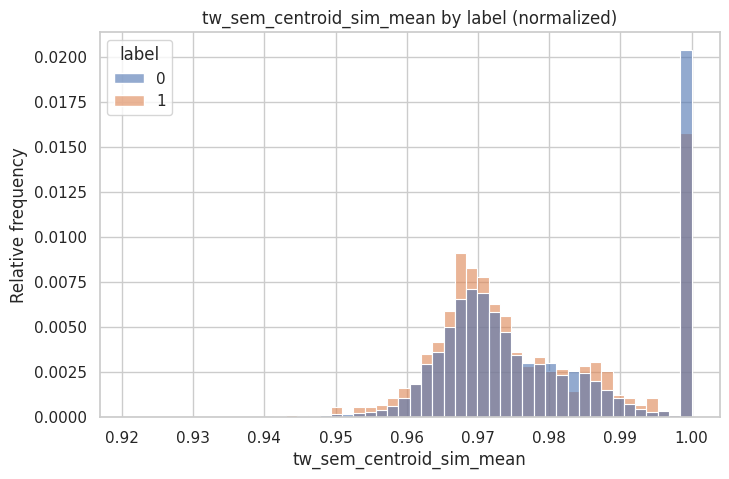

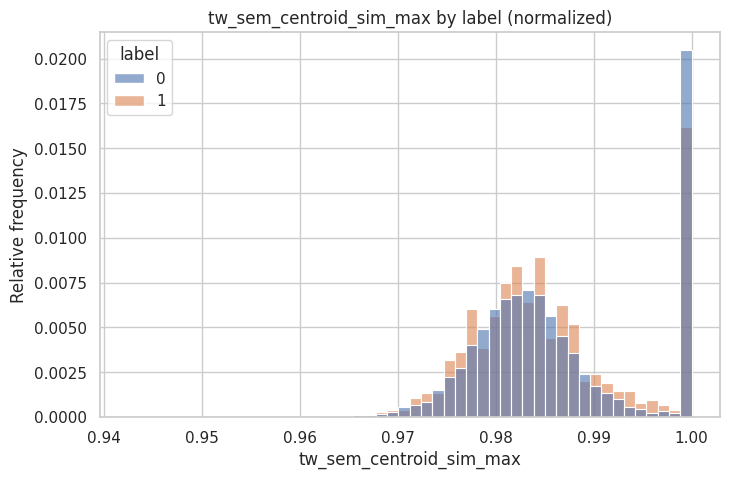

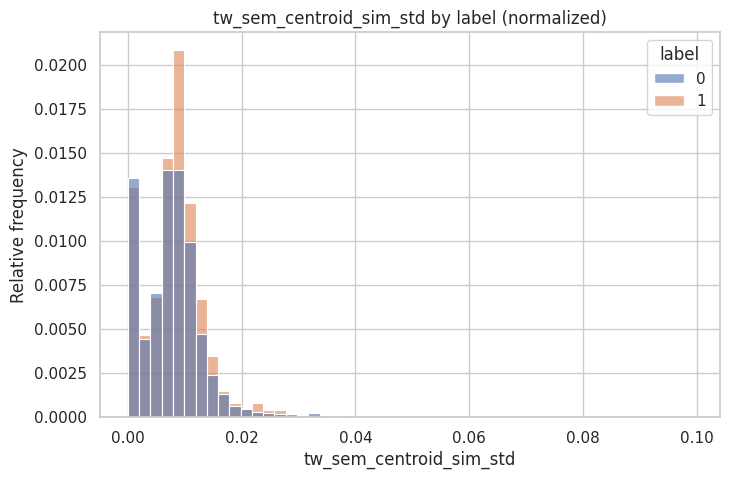

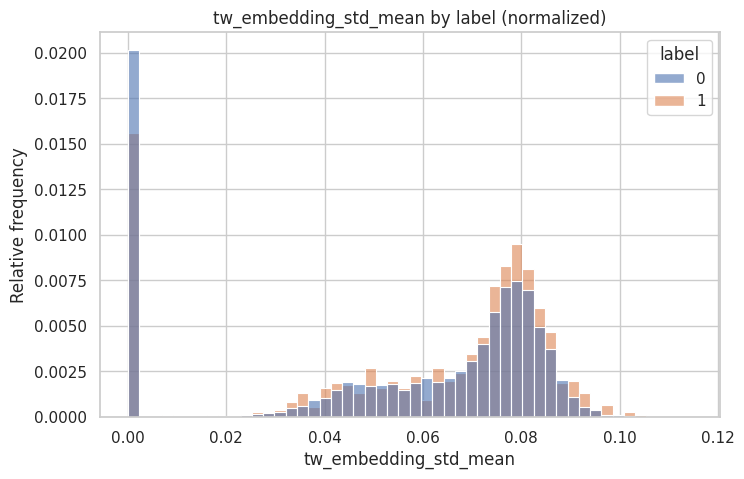

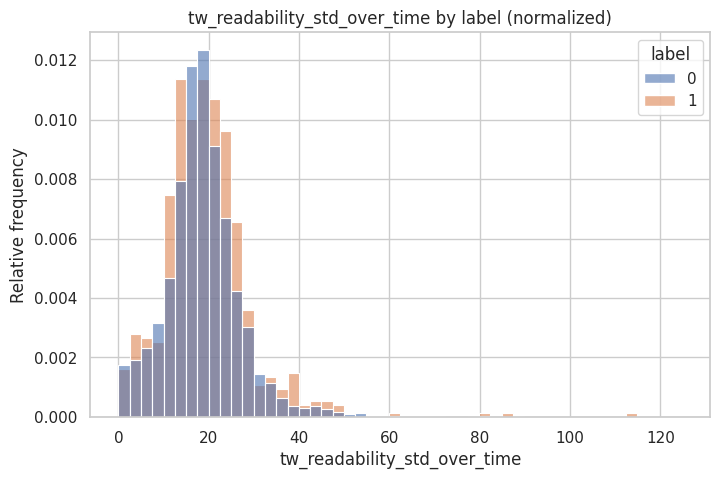

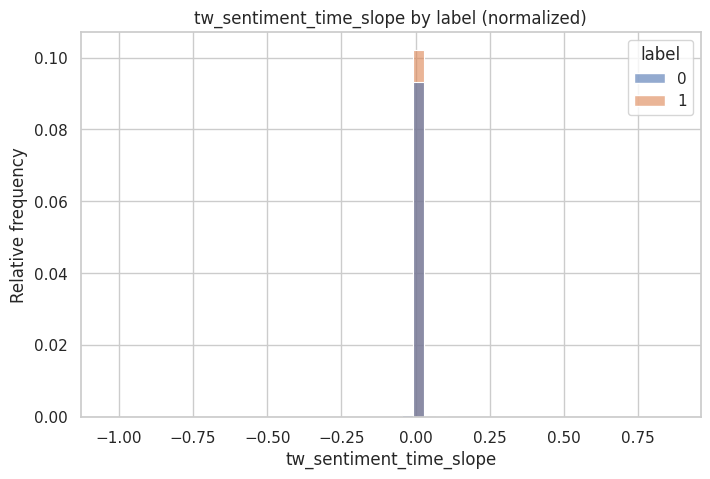

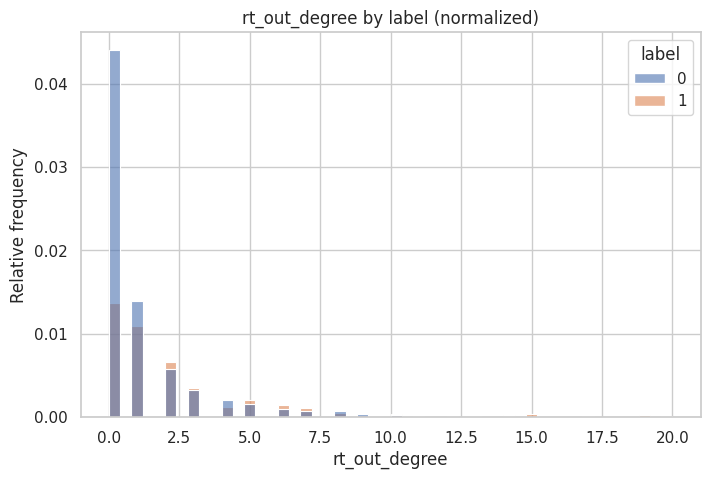

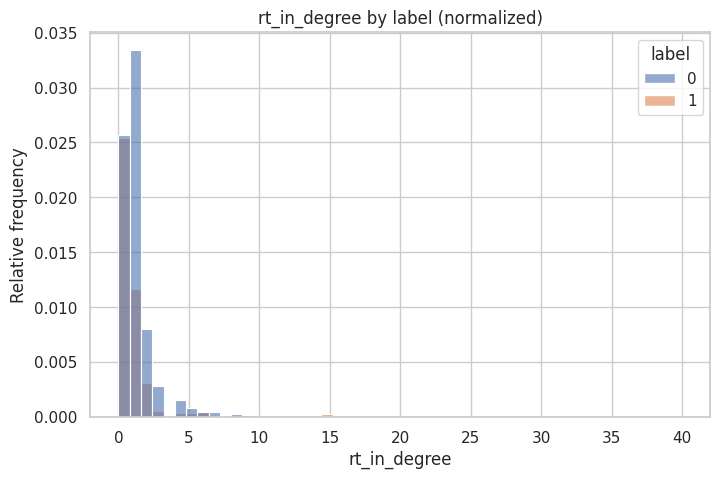

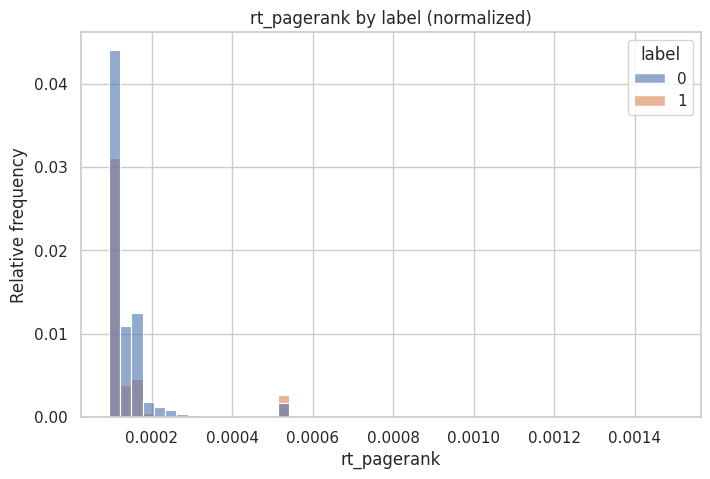

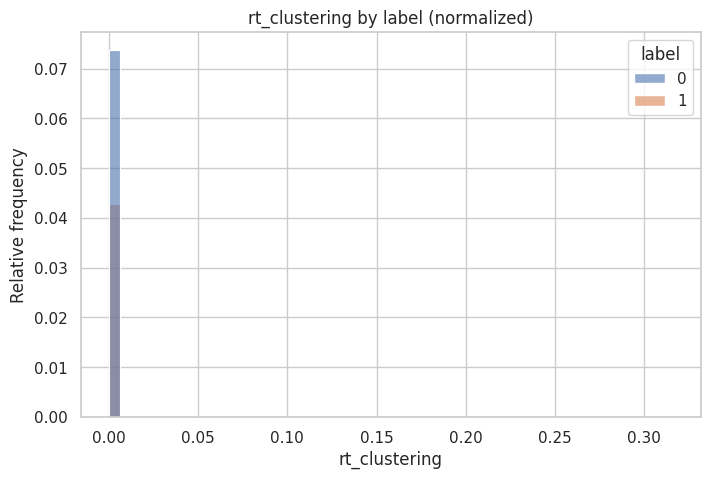

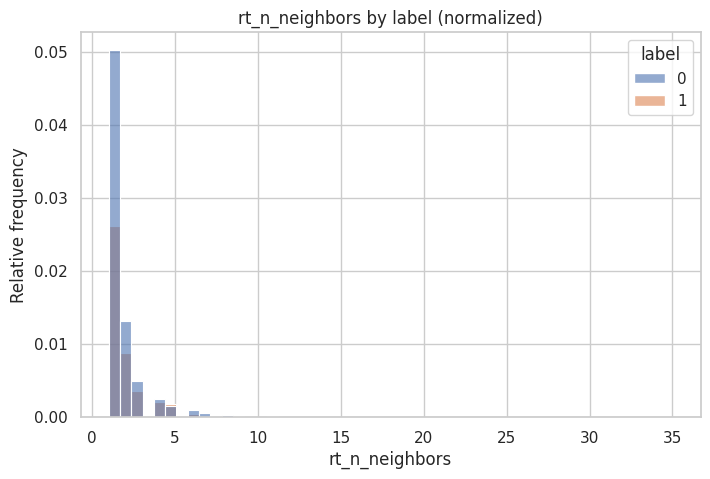

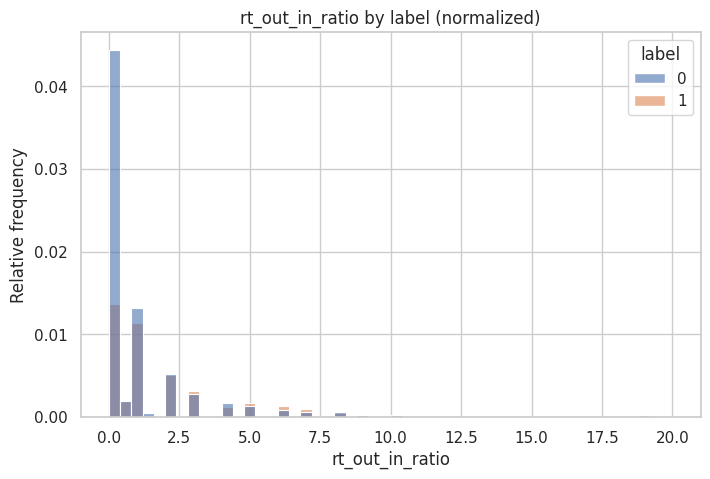

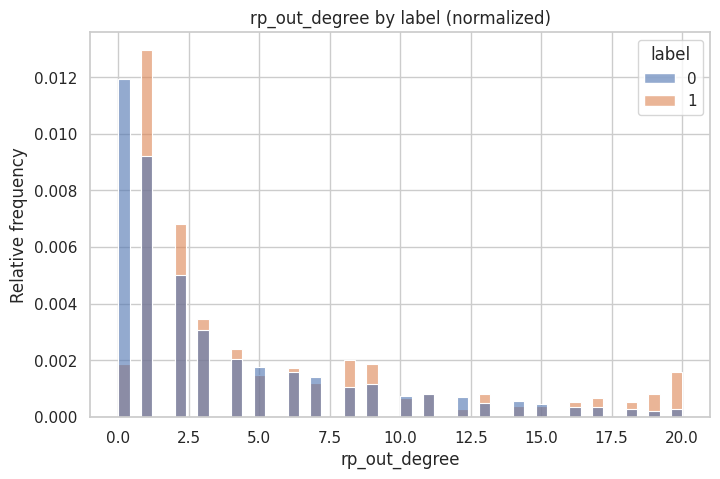

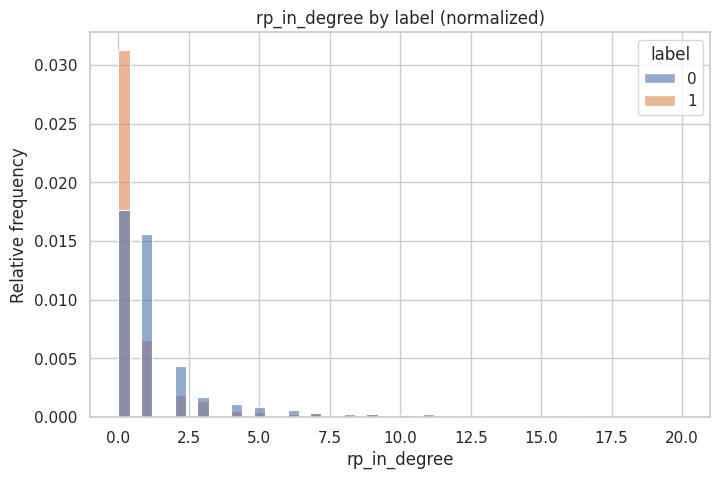

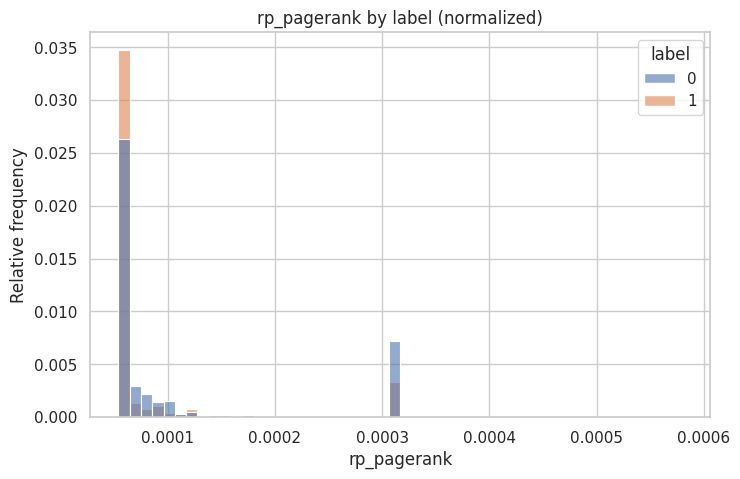

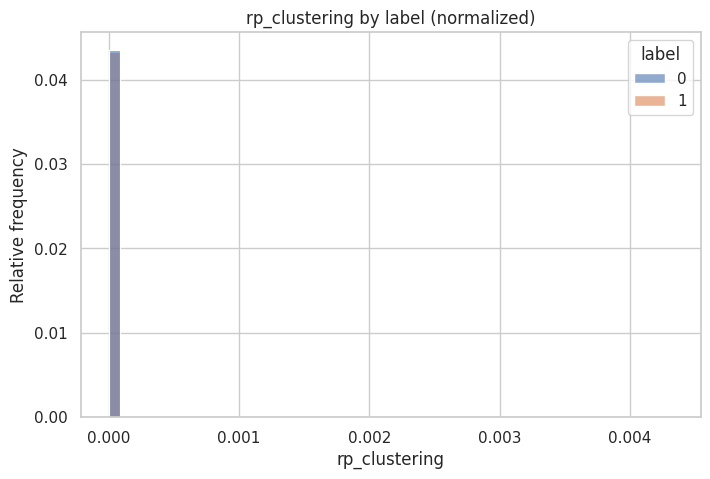

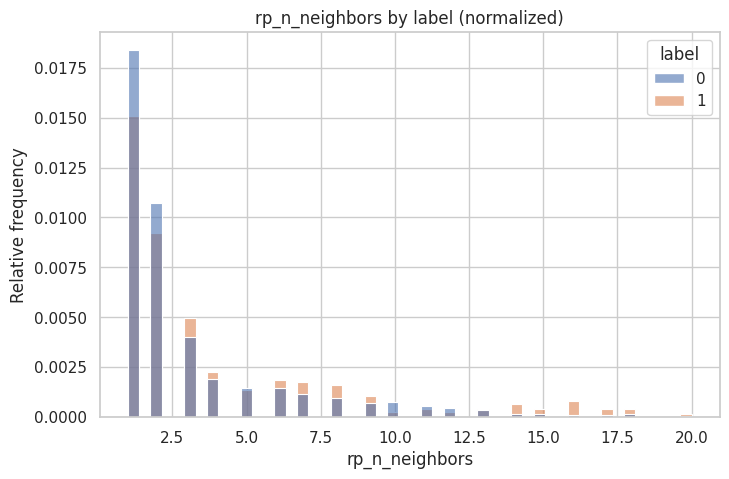

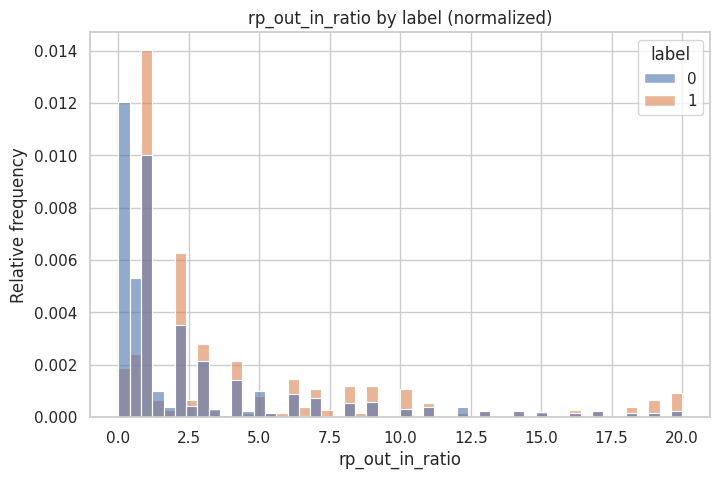

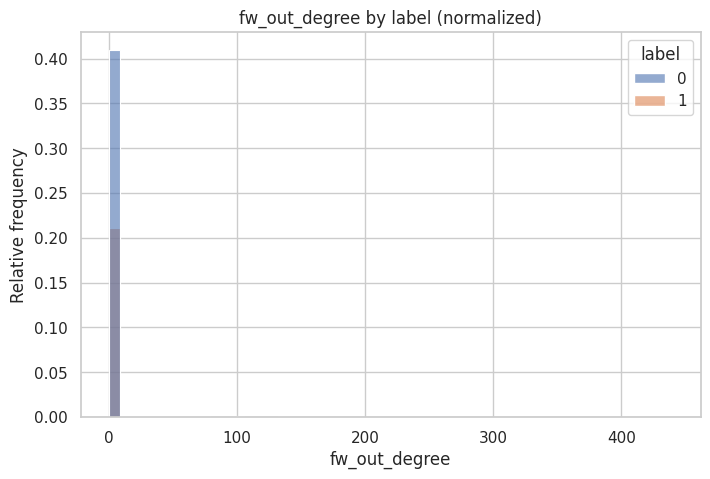

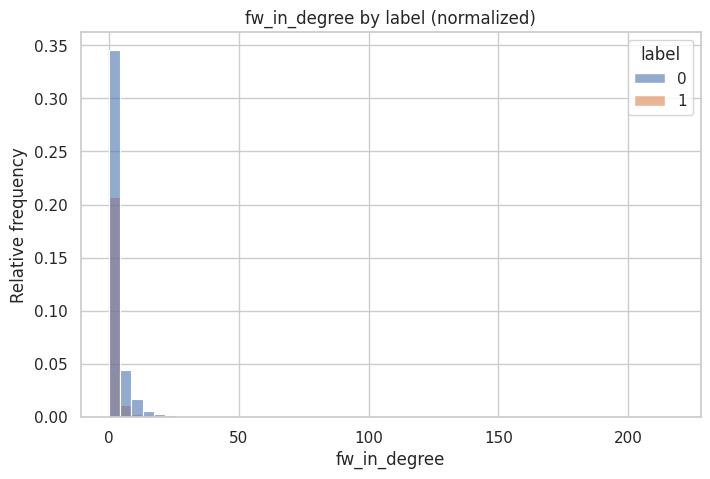

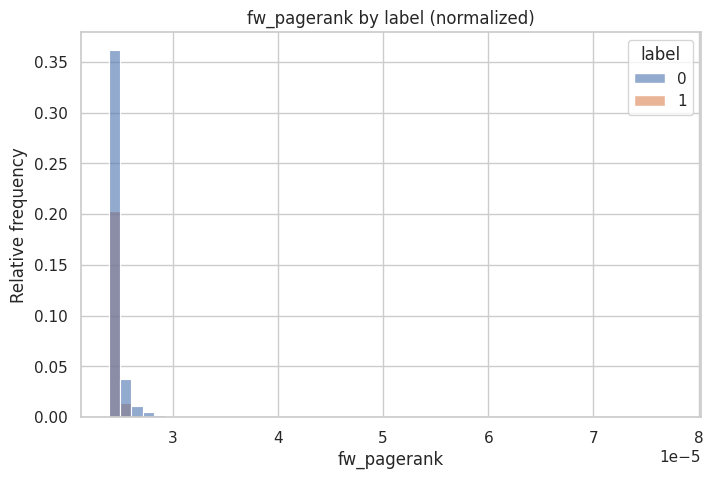

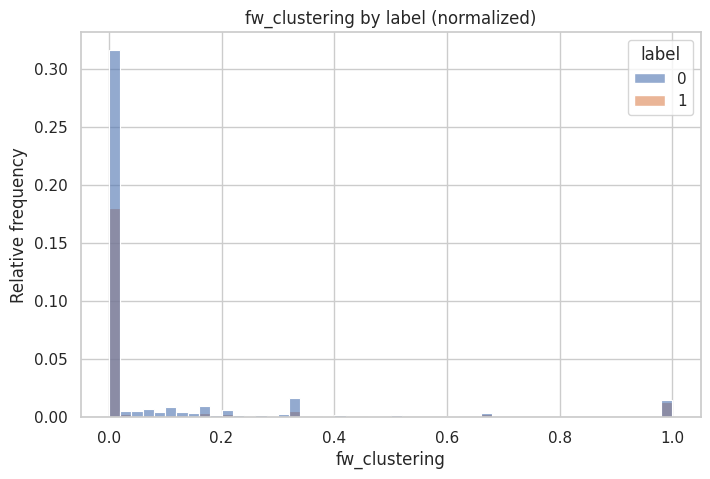

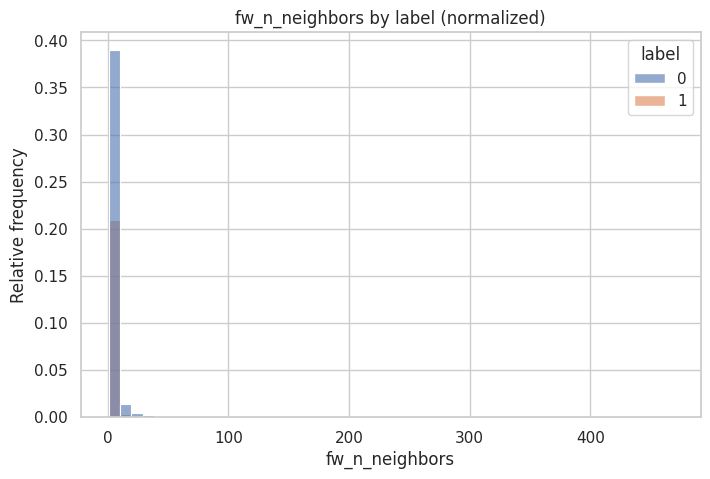

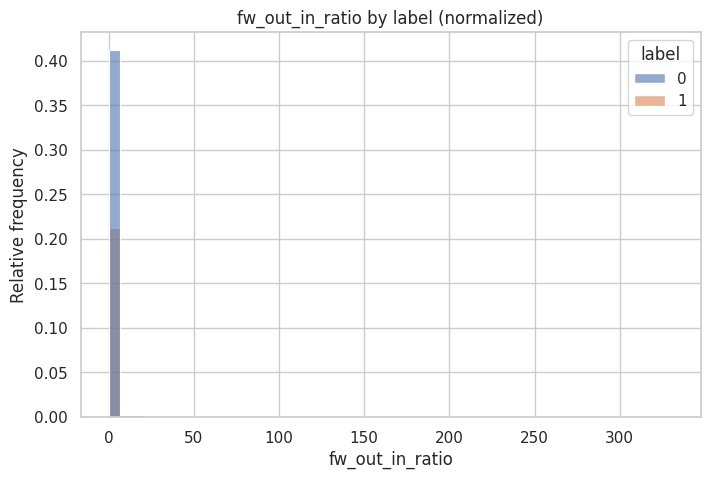

In [65]:
numeric_cols = user_features_2.select_dtypes(include=np.number).columns

for col in numeric_cols:
  plot_numeric(user_features_2, col)

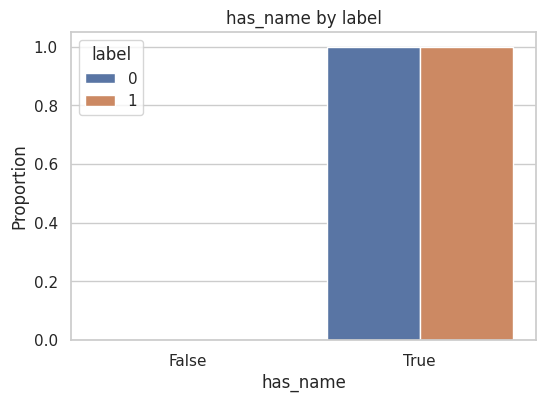

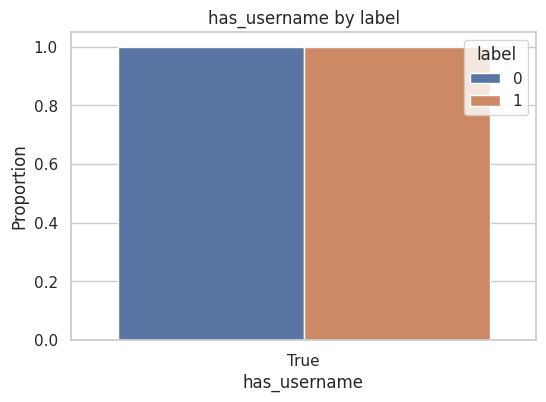

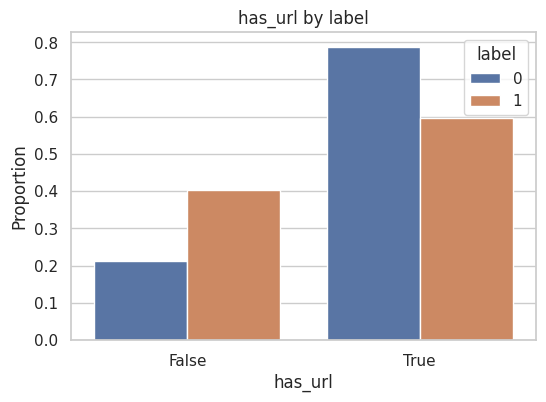

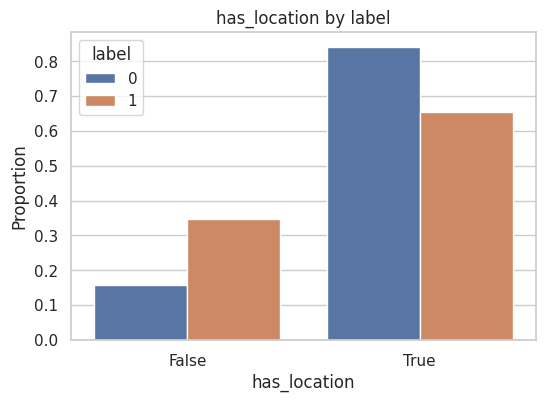

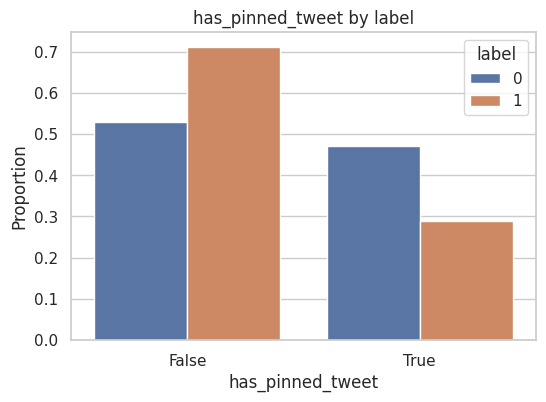

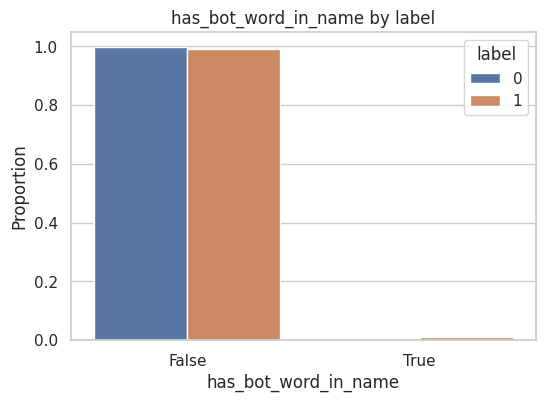

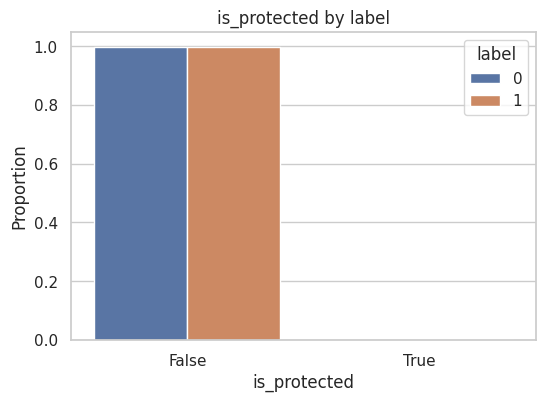

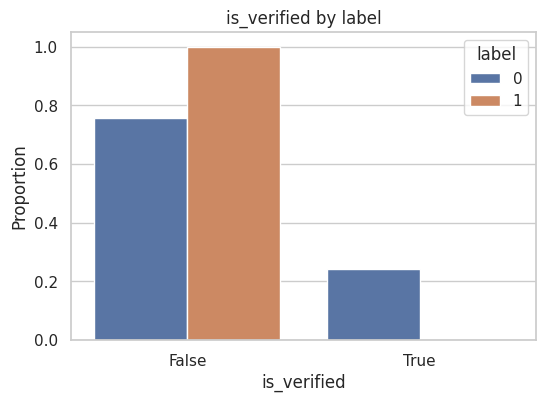

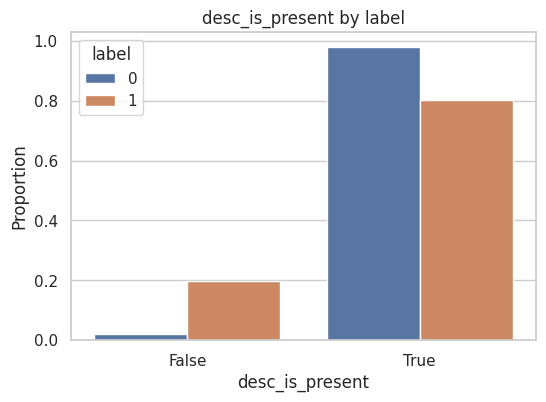

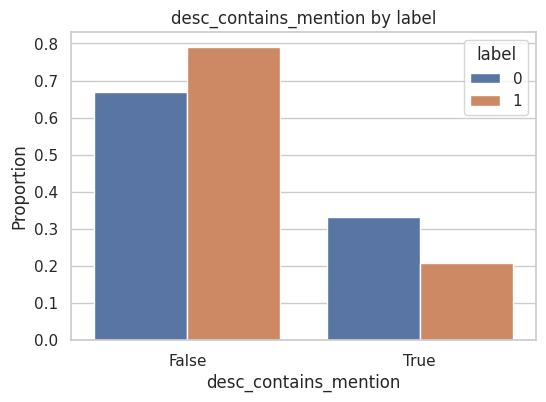

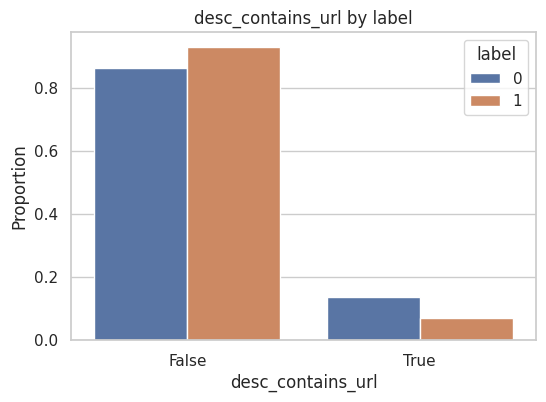

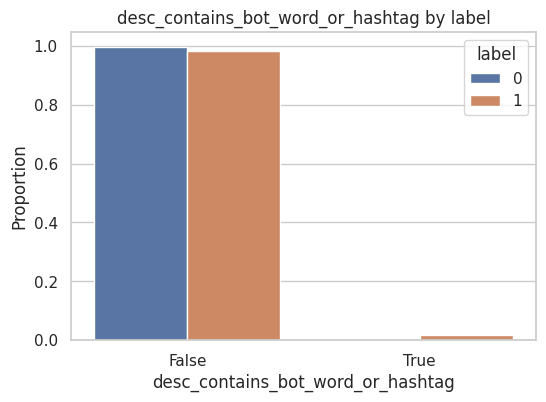

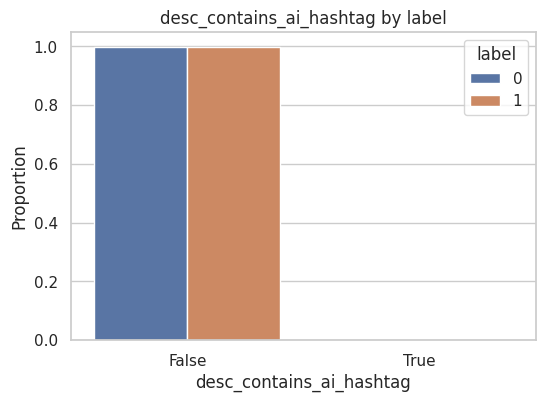

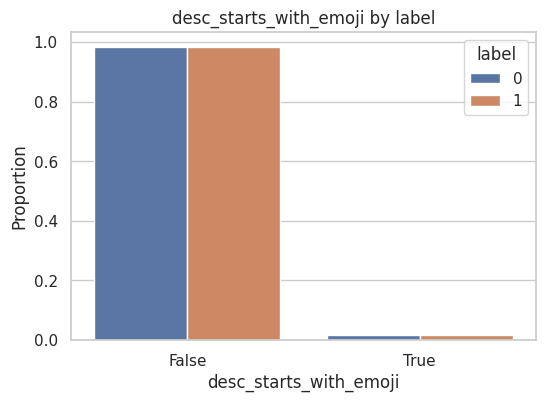

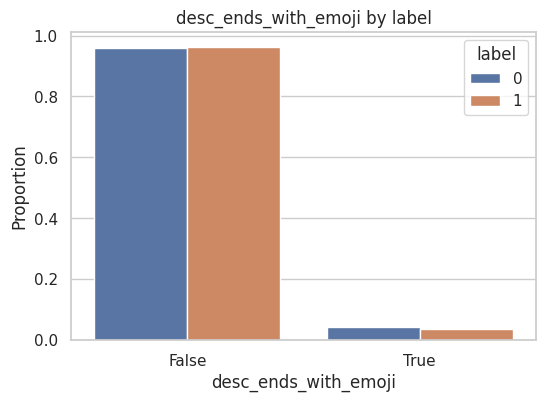

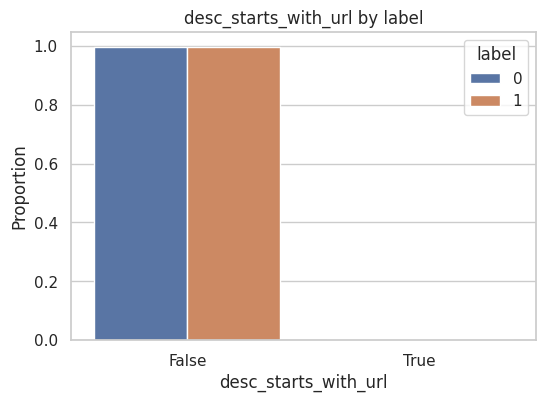

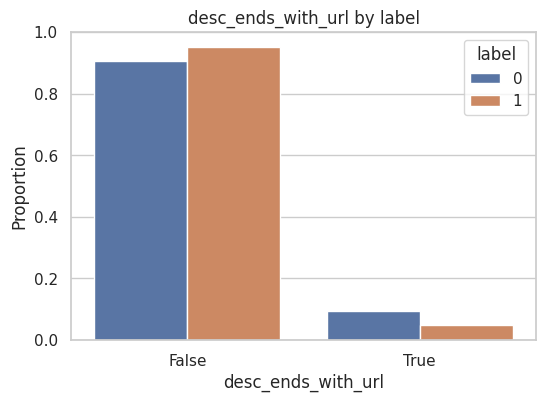

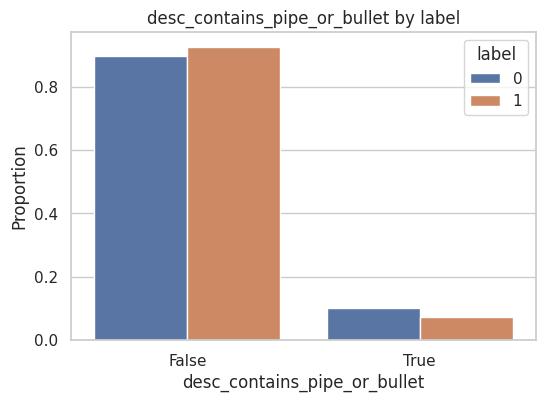

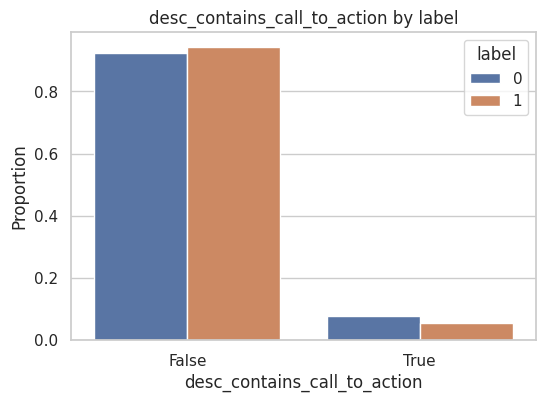

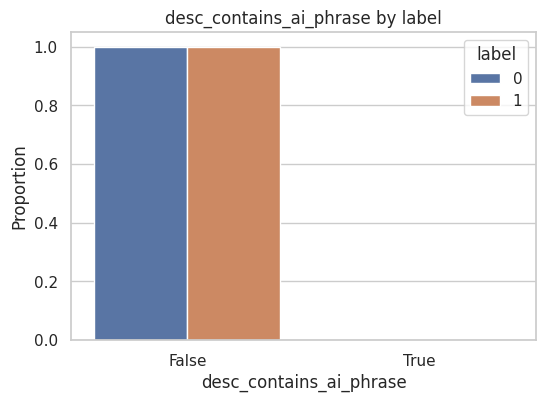

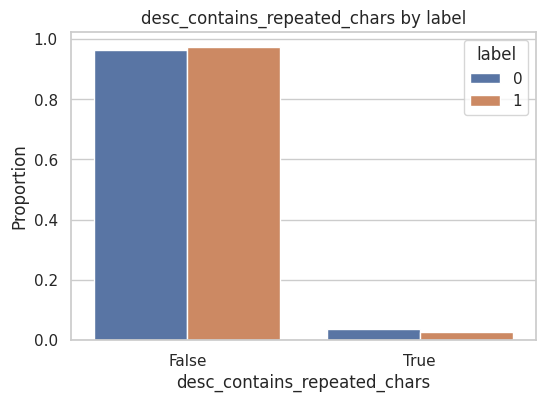

In [66]:
bool_cols = user_features_2.select_dtypes(include=['bool']).columns

for col in bool_cols:
  plot_boolean(user_features_2, col)

In [69]:
exclude_cols = [
    "id",
    "description",
    "description_normalized",
    "desc_embedding",
    "name",
    "username",
    "label"
    ]

X = user_features_2.drop(columns=exclude_cols)
y = user_features_2["label"]

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
    )

In [72]:
report_split(y_train, "Training")
report_split(y_test, "Test")

NameError: name 'enriched_user_features' is not defined

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_bool_cols = bool_cols = user_features_2.select_dtypes(include=[np.number, 'bool']).columns

numeric_bool_pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.01)),  # remove features with variance < 0.01
    ("model_sel", SelectFromModel(
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        threshold="median"  # keep features above median importance
    ))
])

preprocessor = ColumnTransformer([
    ("numeric_bool_pipeline", numeric_bool_pipeline, numeric_bool_cols)
    ], remainder="passthrough")

# Fit on training set
preprocessor.fit(X_train, y_train)

# Transform train/test sets
X_train_selected = preprocessor.transform(X_train)
X_test_selected = preprocessor.transform(X_test)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


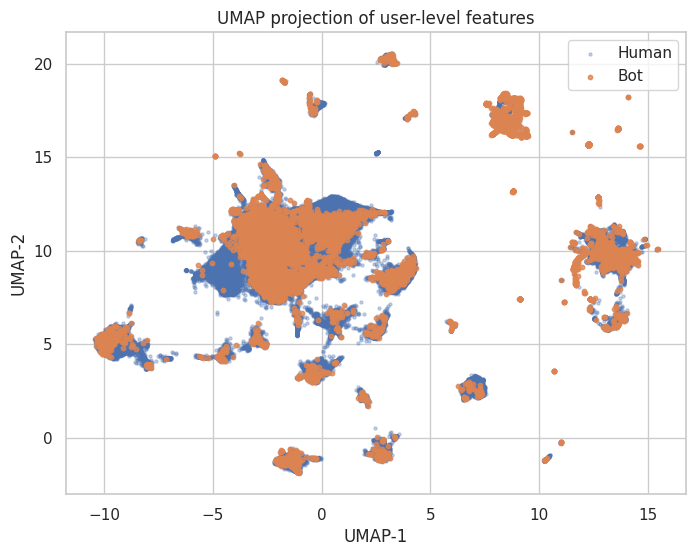

In [68]:
exclude_cols = [
    "id",
    "description",
    "description_normalized",
    "desc_embedding",
    "name",
    "username",
    "label"
    ]

X = user_features_2.drop(columns=exclude_cols)

X = X.select_dtypes(include=[bool, np.number])
y = user_features["label"]

X = (
    X.replace([np.inf, -np.inf], np.nan)
     .fillna(0)
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# humans first
mask_human = y == 0
plt.scatter(
    X_umap[mask_human, 0],
    X_umap[mask_human, 1],
    s=5,
    alpha=0.3,
    label="Human"
)

# bots on top
mask_bot = y == 1
plt.scatter(
    X_umap[mask_bot, 0],
    X_umap[mask_bot, 1],
    s=10,
    alpha=0.8,
    label="Bot"
)

plt.legend()
plt.title("UMAP projection of user-level features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()